## Import model and training sets

In [128]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(1, parent_dir+r'\Covariance and Adjacency Matrix')
from DataManager import dataManager



In [129]:
import h5py
import numpy as np
filepath = parent_dir+'\datasets\sample_patients\pat_FR_620.mat'
variables = {}
f = h5py.File(filepath, 'r')
for k, v in f.items():
    variables[k] = np.array(v)
for key in variables.keys():
    print("name:", key)
    print("shape:", variables[key].shape)
    print("-----------------------")
#print sample EGG signal from one node

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------


In [130]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
#dm.normalize()

--------data manager successfully initialized--------


In [131]:
print("Indices below are removed as they are trivial data:")
print(dm.train_indices)
print(dm.test_indices)

Indices below are removed as they are trivial data:
[86, 87, 88, 89, 90, 1015, 1355, 1356]
[242, 243, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 459, 830, 862, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1367, 1394]


In [132]:
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
sys.path.insert(1, parent_dir+r'\Unsupervised GCN')
from GCN import *


In [133]:
#model = torch.load(parent_dir+r'\Unsupervised GCN\models\draft_2l_GCN.pkl')
#torch.save(model.state_dict(), parent_dir+r'\Unsupervised GCN\models\draft_2l_GCNdict.pkl')

In [134]:
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
def show_heat_map(m):
    plt.imshow(m, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
    
def create_DAD(adj):
    np.fill_diagonal(adj, 1)
    rowsum = np.sum(adj, axis=1)
    d = np.diag_indices(adj.shape[0]) 
    D = np.zeros(adj.shape)
    D[d] = rowsum
    #print(rowsum)
    D = fractional_matrix_power(D, -0.5)
    #print(D)
    return D@adj@D

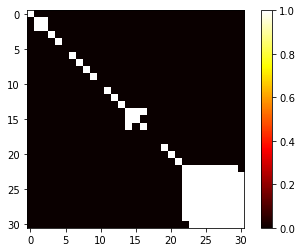

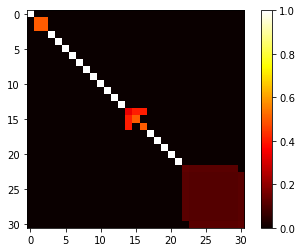

In [135]:
#first fine tune a good threshold n
n = 1*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))

In [136]:
from tqdm import tqdm

def load_ckp(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    return checkpoint

# get sim matrix from unsupervised model
def get_sim_matrix(dm, model_dir):
    checkpoint = load_ckp(model_dir)
    
    #preprocess inputs
    A = torch.from_numpy(create_DAD(dm.A_train)).float()
    X_train = torch.from_numpy(dm.X_train).float()
    X_test = torch.from_numpy(dm.X_test).float()
    device = torch.device('cpu')
    A = A.to(device)
    parameters = checkpoint['parameters']
    input_train = X_train.to(device)
    input_test = X_test.to(device)
    
    #initialize model
    model = Net(parameters['body'], parameters['n_layers'], F.relu, bias=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
    

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    model.eval()
    sim_train = []
    sim_test = []
    permutation = range(input_train.shape[0])
    batch_size = parameters['batch_size']
    
    sim1 = model(input_train, A).to(device)
    sim2 = model(input_test, A).to(device)
    return sim1.cpu().detach().numpy(), sim2.cpu().detach().numpy()
    '''
    for i in tqdm(range(0,input_train.shape[0], batch_size)):

        indices = permutation[i:i+batch_size] if i+batch_size < input_train.shape[0] else permutation[i:] 
        batch_train= input_train[indices, :,:]
        batch_test= input_test[indices, :,:]
        
        sim1 = model(batch_train, A).to(device)
        sim_train.append(sim1.cpu().detach().numpy())
        
        sim2 = model(batch_test, A).to(device)
        sim_test.append(sim2.cpu().detach().numpy())
    print()
    return np.vstack(sim_train), np.vstack(sim_test)
    '''

# get pretrained sim matrix
def load_flattened_sim_matrix(DIR, dm):
    
    sim_train = np.load(DIR + r"/pat_FR_620_Training_Similarities.npy")
    sim_test = np.load(DIR + r"/pat_FR_620_Testing_Similarities.npy")
    
    sim_train = np.delete(sim_train, np.s_[dm.train_indices], axis=0)
    sim_test = np.delete(sim_test, np.s_[dm.test_indices], axis=0)
    
    sim_train_list = []
    tri_indices = torch.triu_indices(31, 31)
    for j in range(sim_train.shape[0]):
        sim = np.zeros((1,31,31))
        for i in range(496):
            sim[0,int(tri_indices[0,i]), int(tri_indices[1,i])] = sim_train[j,i]
        sim_train_list.append(sim)    
    
    sim_test_list = []
    for j in range(sim_test.shape[0]):
        sim = np.zeros((1,31,31))
        for i in range(496):
            sim[0,int(tri_indices[0,i]), int(tri_indices[1,i])] = sim_test[j,i]
        sim_test_list.append(sim) 
        
    return np.vstack(sim_train_list), np.vstack(sim_test_list)
    

In [152]:

model_dir = parent_dir+r'\Unsupervised GCN\models/2layer_1epoch_Aavg_1e-3.pt'
sim_train, sim_test = get_sim_matrix(dm, model_dir)


In [ ]:
'''
# load the sim matrices
filepath = parent_dir+r'/datasets/sample_patients_embeddings'
sim_train, sim_test = load_flattened_sim_matrix(filepath, dm)
'''

In [153]:
print(sim_train.shape)
print(sim_test.shape)
sim_train_arch = sim_train
sim_test_arch = sim_test

(1387, 31, 31)
(1487, 31, 31)


In [141]:
#optional: normalize the sim_train and sim_test
mean = np.mean(sim_train)
sd = np.std(sim_train)
print(mean, sd)

sim_train = (sim_train - mean) / sd
sim_test = (sim_test - mean) / sd

0.00027806644 0.0109448675


ictal


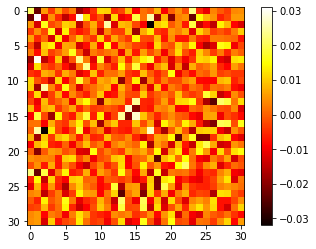

ictal


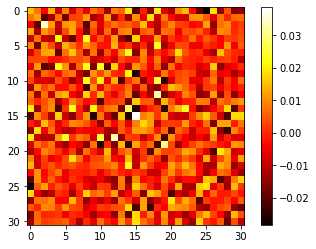

ictal


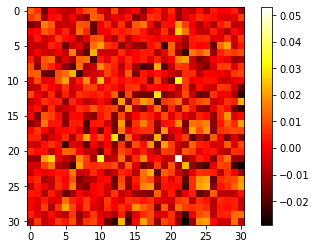

ictal


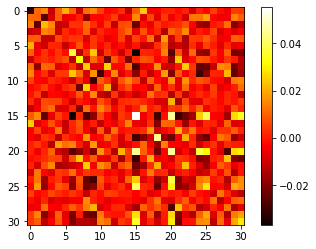

ictal


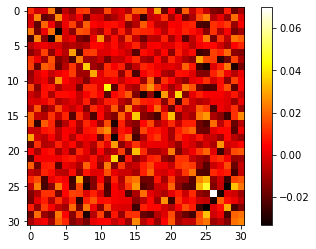

ictal


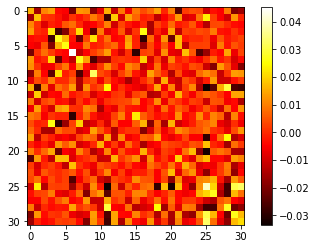

ictal


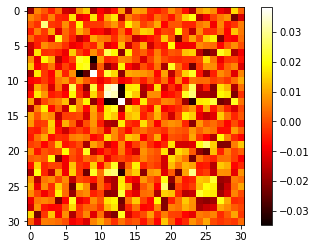

ictal


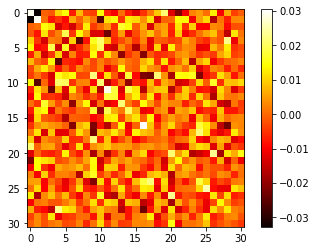

ictal


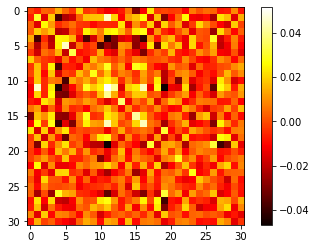

ictal


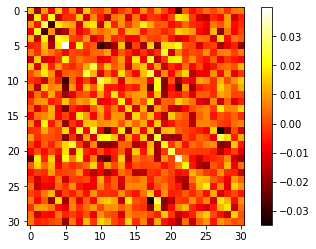

ictal


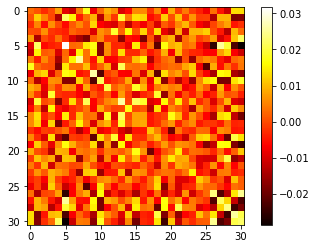

ictal


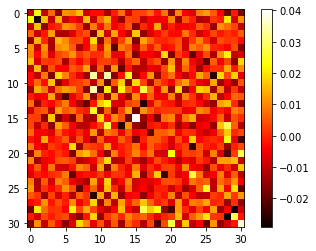

ictal


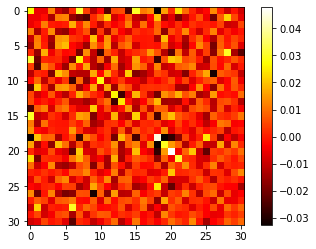

ictal


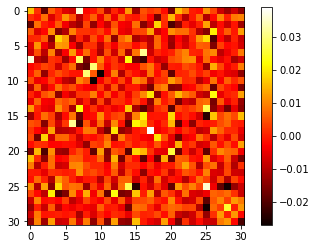

ictal


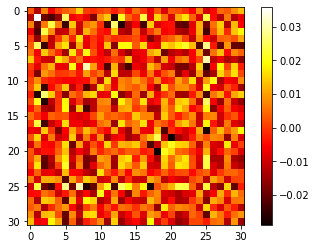

ictal


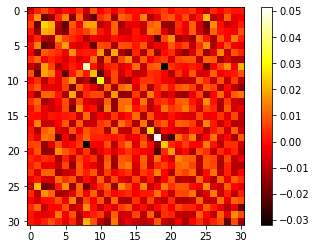

ictal


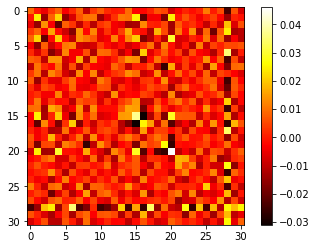

ictal


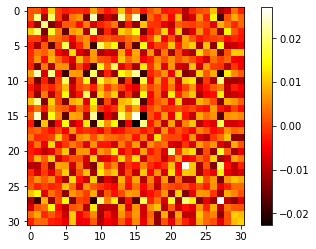

ictal


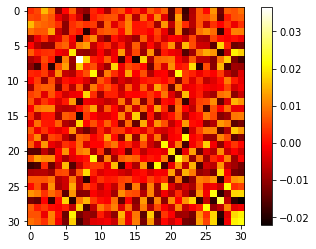

ictal


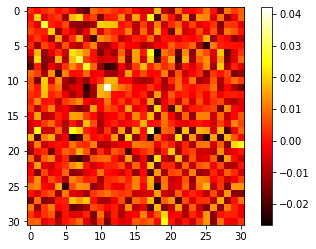

ictal


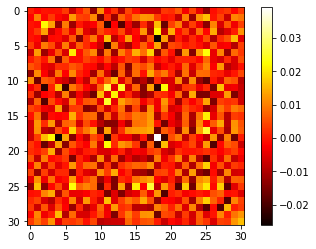

ictal


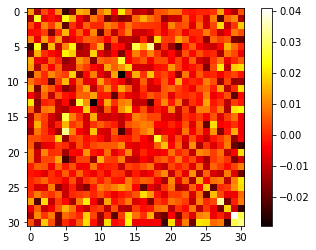

ictal


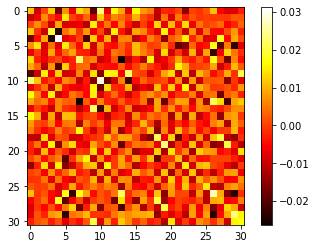

ictal


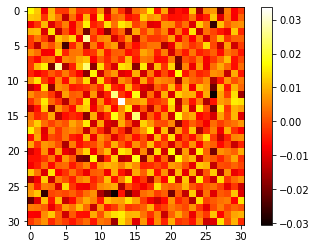

ictal


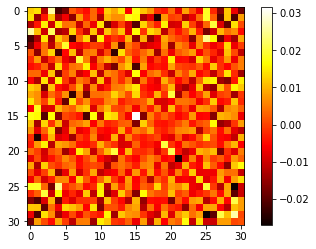

ictal


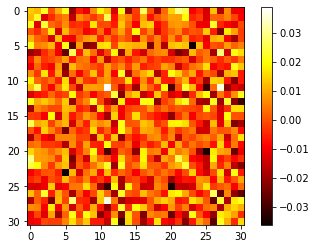

ictal


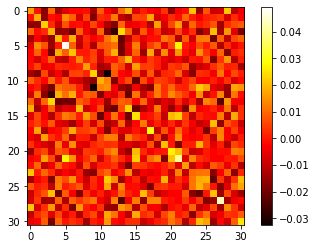

ictal


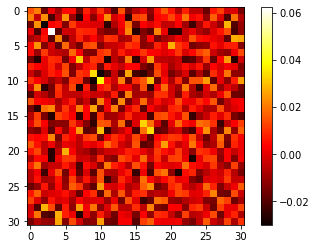

ictal


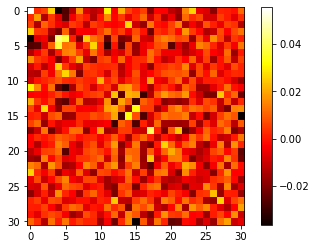

ictal


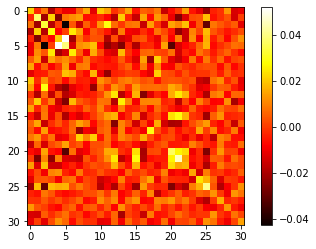

ictal


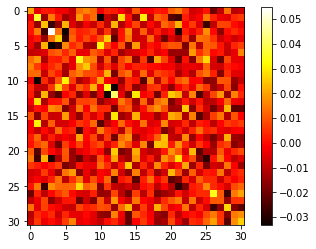

ictal


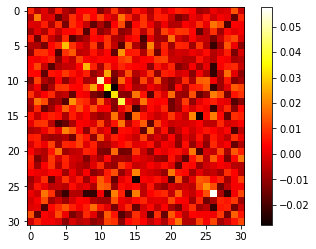

ictal


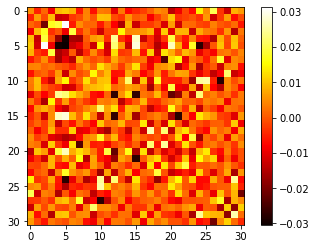

ictal


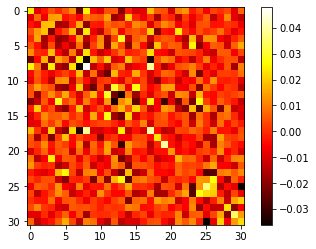

ictal


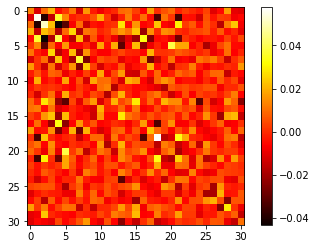

ictal


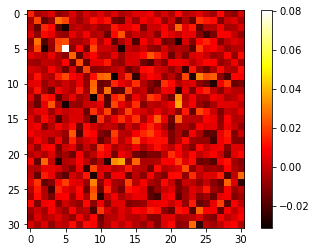

ictal


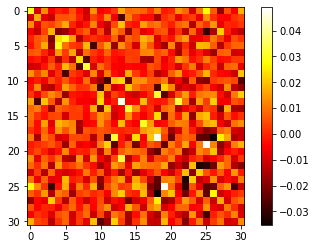

ictal


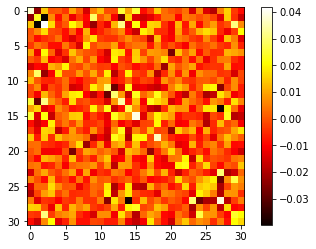

ictal


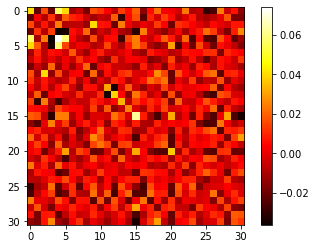

ictal


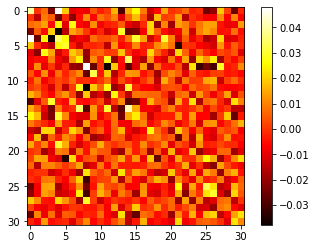

ictal


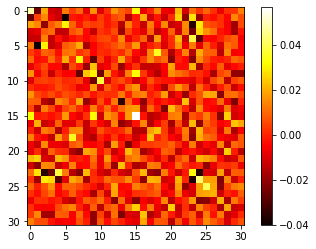

ictal


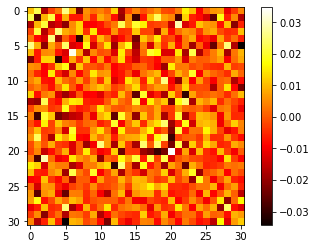

ictal


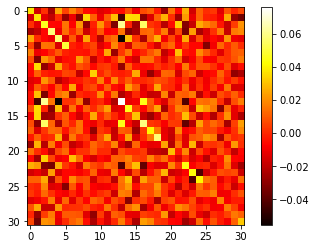

ictal


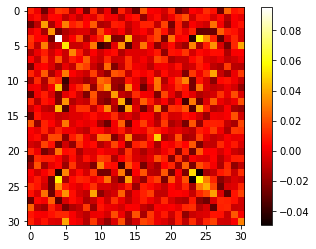

ictal


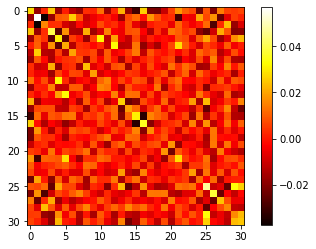

ictal


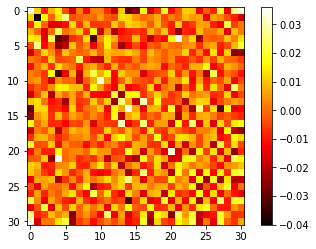

ictal


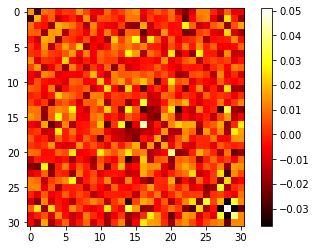

ictal


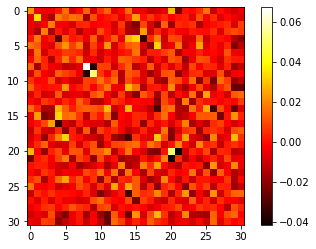

ictal


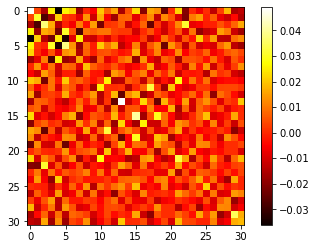

ictal


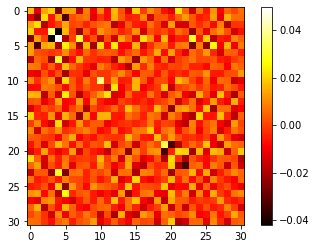

ictal


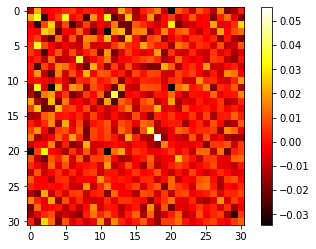

ictal


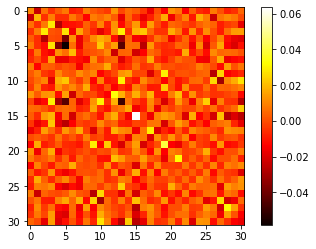

ictal


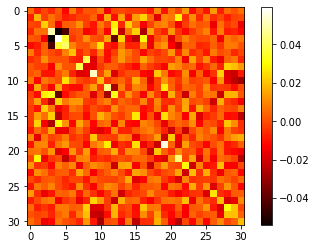

ictal


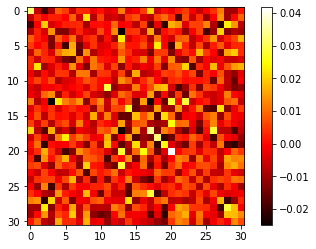

ictal


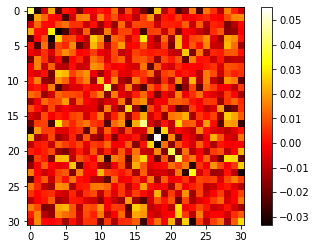

ictal


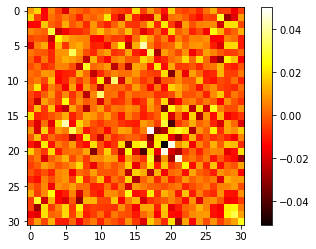

ictal


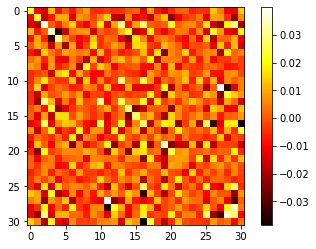

ictal


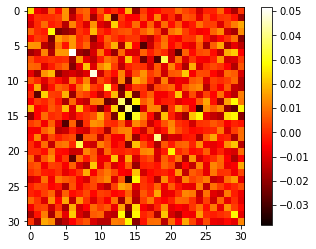

ictal


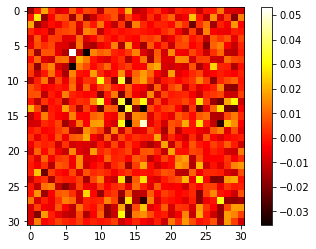

ictal


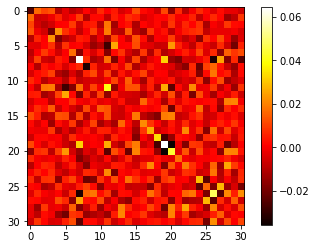

ictal


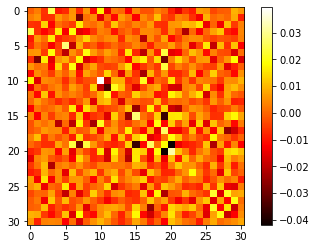

ictal


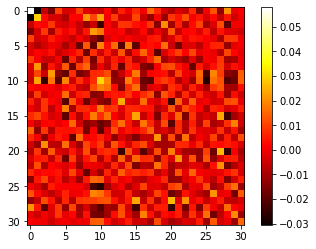

ictal


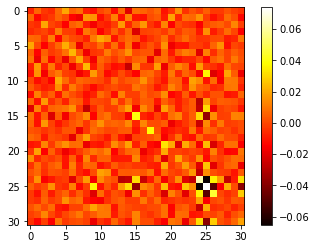

ictal


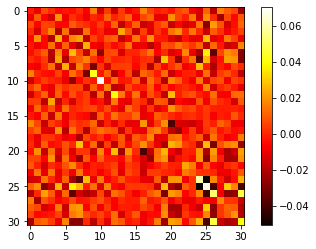

ictal


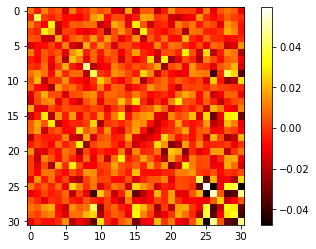

ictal


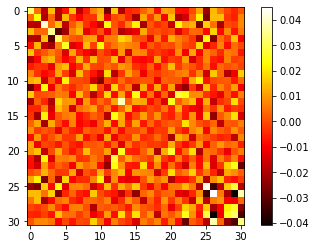

ictal


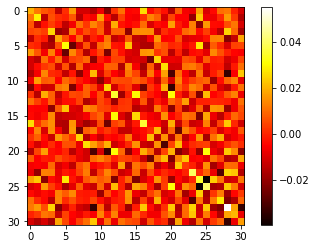

ictal


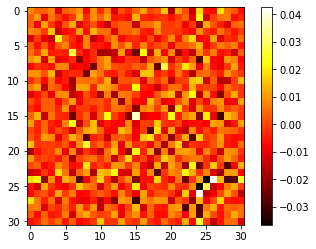

ictal


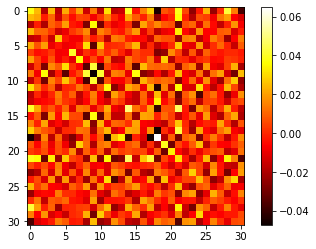

ictal


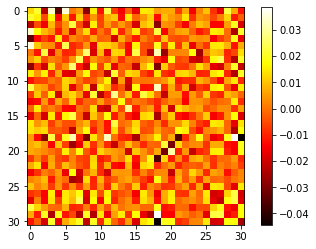

ictal


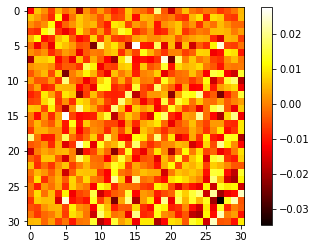

ictal


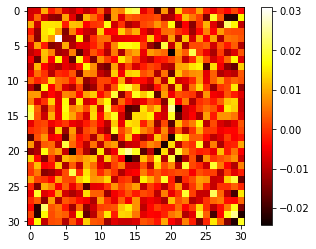

ictal


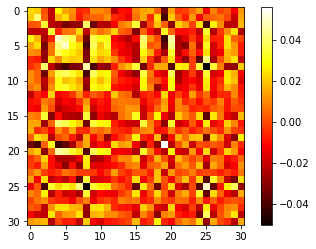

ictal


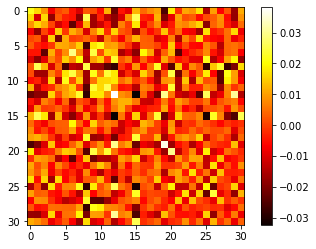

ictal


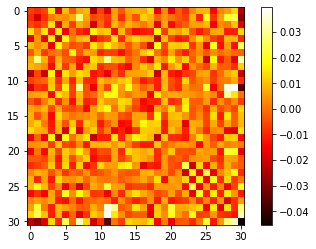

ictal


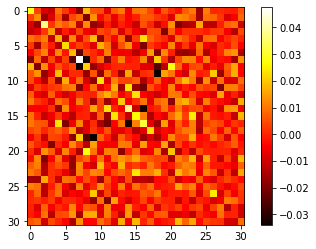

ictal


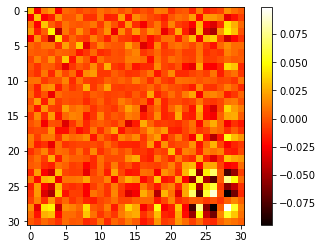

ictal


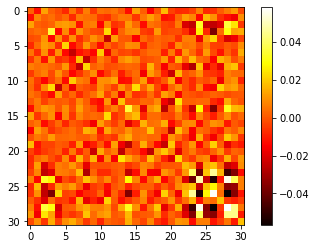

ictal


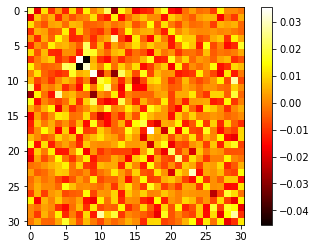

ictal


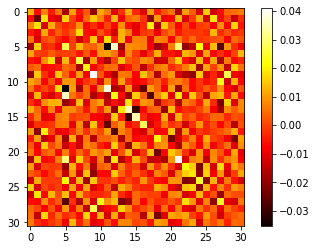

ictal


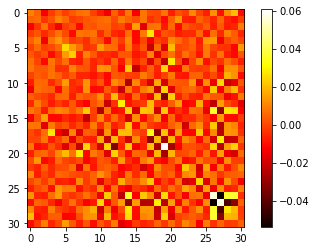

ictal


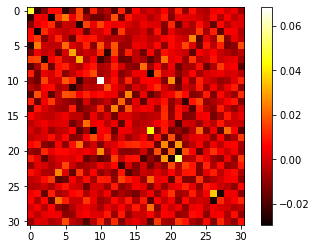

ictal


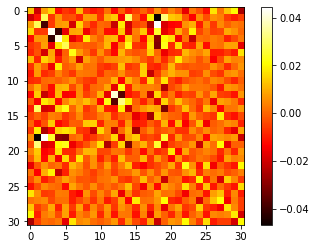

ictal


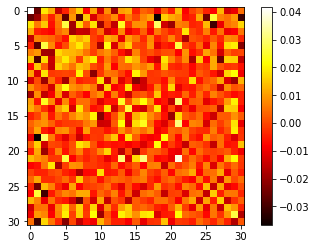

ictal


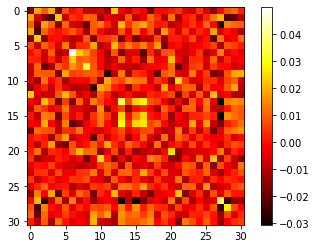

ictal


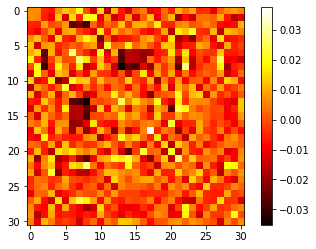

ictal


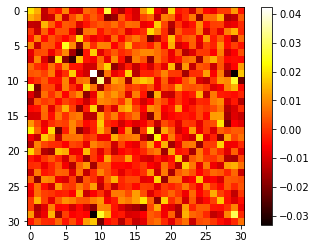

ictal


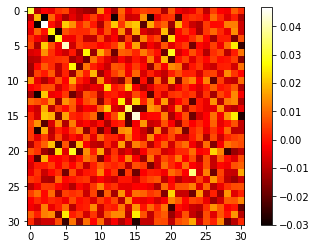

ictal


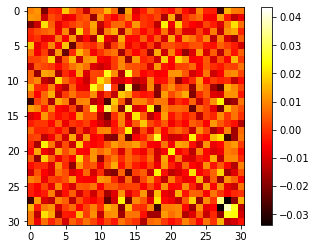

ictal


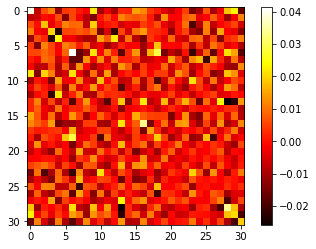

ictal


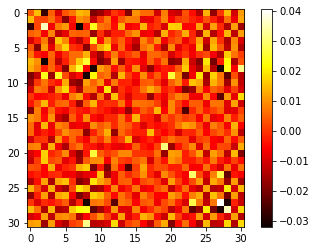

ictal


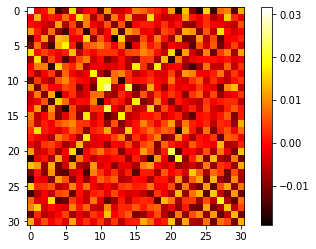

ictal


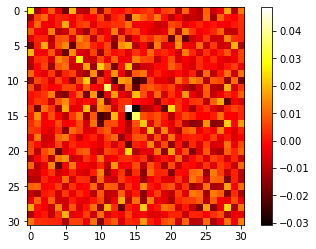

ictal


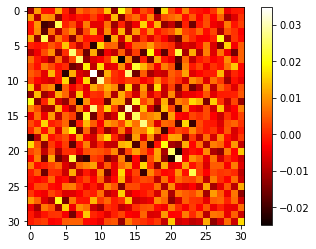

ictal


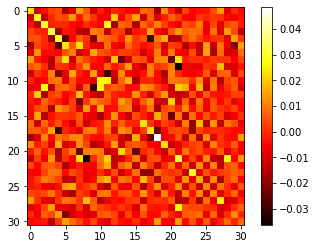

ictal


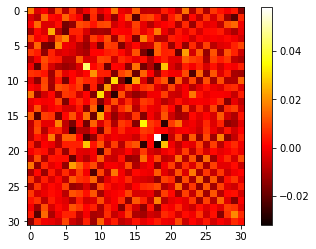

ictal


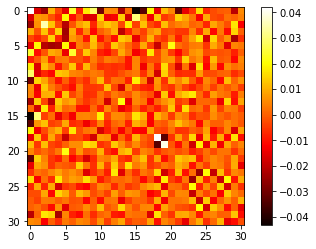

ictal


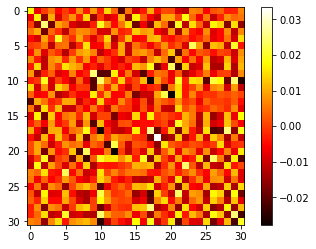

ictal


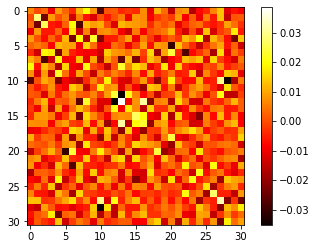

ictal


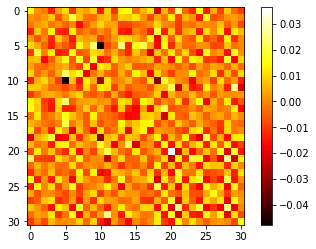

ictal


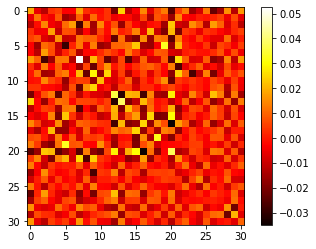

ictal


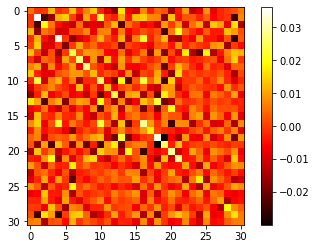

ictal


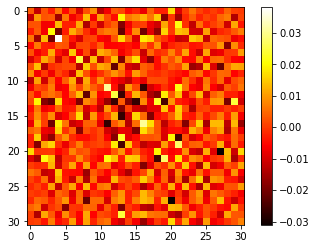

ictal


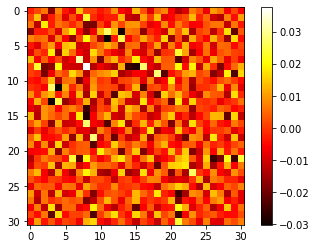

ictal


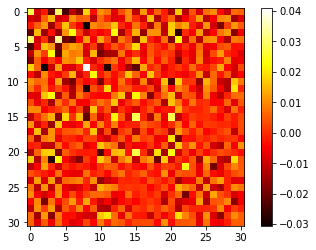

ictal


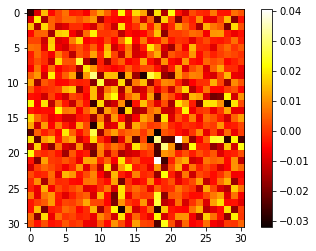

ictal


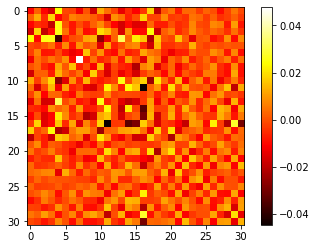

ictal


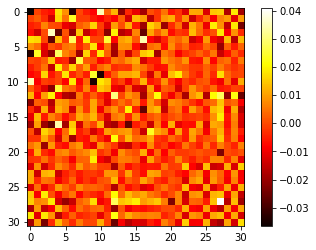

ictal


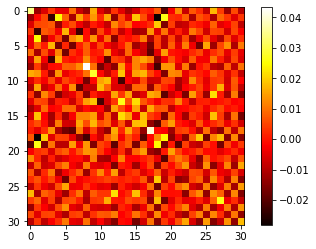

ictal


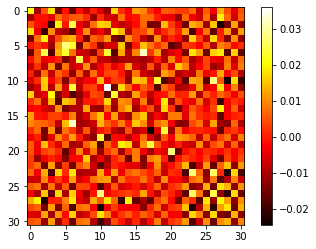

ictal


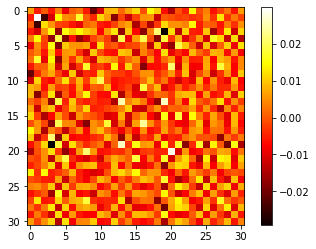

ictal


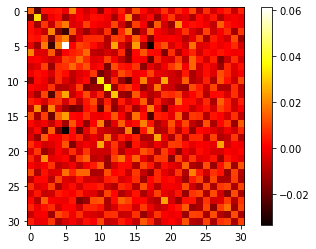

ictal


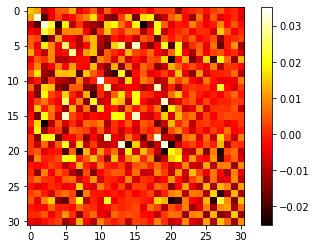

In [139]:

tc = 0

for i in range(sim_train.shape[0]):
    if dm.Y_train[i,0] == 1:
        print("ictal")
        show_heat_map(sim_train[i,:,:])
    else:
        pass
        #print("normal")
        #show_heat_map(sim_train[i,:,:])

average ictal


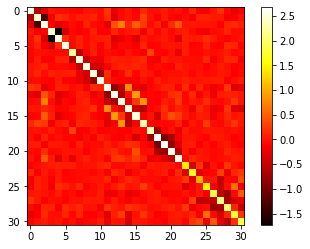

average normal


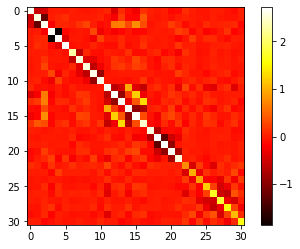

In [154]:
ictal_sum = np.zeros(sim_train[0][:,:].shape)
normal_sum = np.zeros(sim_train[0][:,:].shape)
tc = 0
ni = 0
nn = 0
for i in range(sim_train.shape[0]):
        if dm.Y_train[tc,0] == 1:
            ictal_sum = ictal_sum + sim_train[i,:,:]
            ni+=1
        else:
            normal_sum = normal_sum + sim_train[i,:,:]
            nn+=1
        tc+=1
ictal_sum = ictal_sum / ni
normal_sum = normal_sum / nn
print("average ictal")
show_heat_map(ictal_sum)
print("average normal")
show_heat_map(normal_sum)

## Multilayer Perceptron Network

In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [252]:
class MLP(nn.Module):
    def __init__(self, matrix_dim):
        super(MLP, self).__init__()
        feature_len = torch.triu_indices(matrix_dim, matrix_dim).shape[1]
        self.layers = nn.Sequential(
            nn.Linear(feature_len, feature_len//5 ),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(feature_len//5, 1),
            nn.Sigmoid()
            #nn.Linear(feature_len, 1),
            #nn.Sigmoid()
        )
        
    def flatten(self, sim_matrices):
        tri_indices = torch.triu_indices(sim_matrices.shape[1], sim_matrices.shape[2])
        return sim_matrices[:,tri_indices[0,:],tri_indices[1,:]]
        
    def forward(self, sim_matrices):
        x = self.flatten(sim_matrices)
        for layer in self.layers:
            x = layer(x)
        return x

In [263]:
from sklearn.metrics import f1_score as F1_score

def accuracy(X, Y, threshold = 0.5):
    X = (X>=threshold)
    num = torch.sum(X==Y)
    return float(num/Y.shape[0])

def F1(y_pred, y_true, threshold = 0.5):
    '''
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    '''
    y_pred = y_pred > threshold
    f1 = F1_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    return f1

In [274]:
from torchsummary import summary
def train_MLP(dm, sim_train, sim_test, parameters, acc_fn = F1, print_summary = True):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    MLPmodel = MLP(sim_train.shape[1]).to(device)
    X_train = torch.from_numpy(sim_train).float().to(device)
    X_test = torch.from_numpy(sim_test).float().to(device)
    Y_train = torch.from_numpy(dm.Y_train).float().to(device)
    Y_test = torch.from_numpy(dm.Y_test).float().to(device)

    optimizer = torch.optim.Adam(MLPmodel.parameters(), lr=parameters['learning_rate'],betas=parameters['betas'], eps=parameters['eps'], weight_decay=parameters['weight_decay'], amsgrad=False)
    criterion = nn.BCELoss()

    if print_summary:
        print(MLPmodel)
        summary(MLPmodel, (31,31))
    
    n_epochs = parameters['num_epochs']
    batch_size = parameters['batch_size']
    for epoch in range(1, n_epochs+1):

        # X is a torch Variable
        permutation = torch.randperm(X_train.shape[0])
        t_l = 0
        v_l = 0
        t_a = 0
        v_a = 0
        n_b=0

        for i in range(0,X_train.shape[0], batch_size):
            optimizer.zero_grad()


            indices = permutation[i:i+batch_size] if i+batch_size < X_train.shape[0] else permutation[i:] 
            batch_x_train= X_train[indices, :,:]
            batch_y_train= Y_train[indices,:]
            batch_x_test= X_test[indices, :,:]
            batch_y_test= Y_test[indices,:]

            MLPmodel.train()
            train_pred = MLPmodel(batch_x_train)
            train_loss = criterion(train_pred, batch_y_train)
            train_loss.backward()
            optimizer.step()
            train_acc=acc_fn(train_pred, batch_y_train)

            MLPmodel.eval()
            val_pred = MLPmodel(batch_x_test)
            val_loss = criterion(val_pred, batch_y_test)
            val_acc = acc_fn(val_pred, batch_y_test)

            #print("Epoch:", epoch,"  Train loss:", round(float(train_loss),4),"  Train accuracy:", round(float(train_acc),2),"  Val loss:", round(float(val_loss),4),"  Val accuracy:", round(float(val_acc),2),  end="\r")

            t_l += float(train_loss)
            v_l += float(val_loss)
            t_a += float(train_acc)
            v_a += float(val_acc)
            n_b += 1

        print("Epoch:", epoch,"  Train loss:", round(t_l/n_b,4),"  Train accuracy:", round(t_a/n_b,2),"  Val loss:", round(v_l/n_b,4),"  Val accuracy:", round(v_a/n_b,2))
    print()
    
    return MLPmodel
        

In [281]:
parameters = {
    'batch_size': 128,
    'num_epochs': 200,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
print(parameters)

{'batch_size': 128, 'num_epochs': 200, 'learning_rate': 0.001, 'weight_decay': 0.005, 'betas': (0.9, 0.999), 'eps': 1e-08}


In [282]:
train_MLP(dm, sim_train, sim_test, parameters, print_summary = True)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=99, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=99, out_features=1, bias=True)
    (4): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 99]          49,203
              ReLU-2                   [-1, 99]               0
           Dropout-3                   [-1, 99]               0
            Linear-4                    [-1, 1]             100
           Sigmoid-5                    [-1, 1]               0
Total params: 49,303
Trainable params: 49,303
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.19
----------------------------------------------------------------
Epoch: 

Epoch: 78   Train loss: 0.0166   Train accuracy: 0.99   Val loss: 0.4579   Val accuracy: 0.47
Epoch: 79   Train loss: 0.0179   Train accuracy: 0.99   Val loss: 0.4507   Val accuracy: 0.48
Epoch: 80   Train loss: 0.0164   Train accuracy: 0.98   Val loss: 0.4367   Val accuracy: 0.48
Epoch: 81   Train loss: 0.015   Train accuracy: 0.99   Val loss: 0.4458   Val accuracy: 0.47
Epoch: 82   Train loss: 0.016   Train accuracy: 0.98   Val loss: 0.4338   Val accuracy: 0.51
Epoch: 83   Train loss: 0.0165   Train accuracy: 0.98   Val loss: 0.4403   Val accuracy: 0.48
Epoch: 84   Train loss: 0.018   Train accuracy: 0.98   Val loss: 0.441   Val accuracy: 0.47
Epoch: 85   Train loss: 0.0173   Train accuracy: 0.99   Val loss: 0.4652   Val accuracy: 0.48
Epoch: 86   Train loss: 0.0182   Train accuracy: 0.98   Val loss: 0.4239   Val accuracy: 0.5
Epoch: 87   Train loss: 0.0168   Train accuracy: 0.99   Val loss: 0.4699   Val accuracy: 0.48
Epoch: 88   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0

Epoch: 166   Train loss: 0.0137   Train accuracy: 0.98   Val loss: 0.4829   Val accuracy: 0.47
Epoch: 167   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4732   Val accuracy: 0.47
Epoch: 168   Train loss: 0.0115   Train accuracy: 0.99   Val loss: 0.4651   Val accuracy: 0.49
Epoch: 169   Train loss: 0.0135   Train accuracy: 0.99   Val loss: 0.4567   Val accuracy: 0.46
Epoch: 170   Train loss: 0.0122   Train accuracy: 0.99   Val loss: 0.446   Val accuracy: 0.48
Epoch: 171   Train loss: 0.0145   Train accuracy: 0.99   Val loss: 0.4725   Val accuracy: 0.49
Epoch: 172   Train loss: 0.0131   Train accuracy: 0.99   Val loss: 0.4704   Val accuracy: 0.48
Epoch: 173   Train loss: 0.0137   Train accuracy: 0.99   Val loss: 0.4619   Val accuracy: 0.47
Epoch: 174   Train loss: 0.0141   Train accuracy: 0.98   Val loss: 0.4825   Val accuracy: 0.46
Epoch: 175   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.4694   Val accuracy: 0.48
Epoch: 176   Train loss: 0.0137   Train accuracy: 1.0

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=99, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=99, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

#### Training result on 2 layer 1 epoch on unsupervised learning. n = 1e-3 

In [121]:
parameters = {
    'batch_size': 128,
    'num_epochs': 2000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)

{'batch_size': 128, 'num_epochs': 2000, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [122]:
train_MLP(dm, sim_train, sim_test, parameters, print_summary = True)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]          11,928
              ReLU-2                   [-1, 24]               0
            Linear-3                    [-1, 1]              25
           Sigmoid-4                    [-1, 1]               0
Total params: 11,953
Trainable params: 11,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
Epoch: 1   Train loss: 0.4297   Train accuracy: 0.01   Val loss: 0.4499   Val accuracy: 0.01
Epoch: 2   Train 

Epoch: 82   Train loss: 0.0093   Train accuracy: 1.0   Val loss: 0.4253   Val accuracy: 0.48
Epoch: 83   Train loss: 0.0094   Train accuracy: 1.0   Val loss: 0.4042   Val accuracy: 0.5
Epoch: 84   Train loss: 0.0093   Train accuracy: 1.0   Val loss: 0.4167   Val accuracy: 0.51
Epoch: 85   Train loss: 0.0091   Train accuracy: 1.0   Val loss: 0.4248   Val accuracy: 0.49
Epoch: 86   Train loss: 0.0092   Train accuracy: 1.0   Val loss: 0.4152   Val accuracy: 0.5
Epoch: 87   Train loss: 0.0089   Train accuracy: 1.0   Val loss: 0.4153   Val accuracy: 0.5
Epoch: 88   Train loss: 0.009   Train accuracy: 1.0   Val loss: 0.4176   Val accuracy: 0.5
Epoch: 89   Train loss: 0.0088   Train accuracy: 1.0   Val loss: 0.4304   Val accuracy: 0.48
Epoch: 90   Train loss: 0.01   Train accuracy: 1.0   Val loss: 0.4273   Val accuracy: 0.49
Epoch: 91   Train loss: 0.0098   Train accuracy: 1.0   Val loss: 0.4083   Val accuracy: 0.5
Epoch: 92   Train loss: 0.0089   Train accuracy: 1.0   Val loss: 0.426   Val a

Epoch: 171   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.4407   Val accuracy: 0.51
Epoch: 172   Train loss: 0.0073   Train accuracy: 1.0   Val loss: 0.4428   Val accuracy: 0.49
Epoch: 173   Train loss: 0.0075   Train accuracy: 1.0   Val loss: 0.4352   Val accuracy: 0.5
Epoch: 174   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.4474   Val accuracy: 0.5
Epoch: 175   Train loss: 0.0072   Train accuracy: 1.0   Val loss: 0.4542   Val accuracy: 0.47
Epoch: 176   Train loss: 0.0081   Train accuracy: 1.0   Val loss: 0.4574   Val accuracy: 0.49
Epoch: 177   Train loss: 0.0073   Train accuracy: 1.0   Val loss: 0.4354   Val accuracy: 0.5
Epoch: 178   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4407   Val accuracy: 0.51
Epoch: 179   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.451   Val accuracy: 0.51
Epoch: 180   Train loss: 0.007   Train accuracy: 1.0   Val loss: 0.4305   Val accuracy: 0.51
Epoch: 181   Train loss: 0.0075   Train accuracy: 1.0   Val loss:

Epoch: 262   Train loss: 0.0077   Train accuracy: 1.0   Val loss: 0.475   Val accuracy: 0.48
Epoch: 263   Train loss: 0.007   Train accuracy: 1.0   Val loss: 0.4487   Val accuracy: 0.5
Epoch: 264   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4629   Val accuracy: 0.49
Epoch: 265   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4462   Val accuracy: 0.5
Epoch: 266   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4487   Val accuracy: 0.5
Epoch: 267   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4696   Val accuracy: 0.47
Epoch: 268   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4531   Val accuracy: 0.48
Epoch: 269   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4509   Val accuracy: 0.49
Epoch: 270   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4514   Val accuracy: 0.49
Epoch: 271   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4498   Val accuracy: 0.5
Epoch: 272   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 

Epoch: 351   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4628   Val accuracy: 0.47
Epoch: 352   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4573   Val accuracy: 0.49
Epoch: 353   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4661   Val accuracy: 0.48
Epoch: 354   Train loss: 0.0072   Train accuracy: 1.0   Val loss: 0.4766   Val accuracy: 0.49
Epoch: 355   Train loss: 0.0076   Train accuracy: 1.0   Val loss: 0.4825   Val accuracy: 0.49
Epoch: 356   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4666   Val accuracy: 0.47
Epoch: 357   Train loss: 0.0076   Train accuracy: 1.0   Val loss: 0.4561   Val accuracy: 0.48
Epoch: 358   Train loss: 0.0073   Train accuracy: 1.0   Val loss: 0.4721   Val accuracy: 0.48
Epoch: 359   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.462   Val accuracy: 0.48
Epoch: 360   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4621   Val accuracy: 0.5
Epoch: 361   Train loss: 0.0065   Train accuracy: 1.0   Val lo

Epoch: 440   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4631   Val accuracy: 0.5
Epoch: 441   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.4747   Val accuracy: 0.48
Epoch: 442   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4584   Val accuracy: 0.49
Epoch: 443   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4687   Val accuracy: 0.47
Epoch: 444   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4571   Val accuracy: 0.49
Epoch: 445   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.4605   Val accuracy: 0.48
Epoch: 446   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.472   Val accuracy: 0.48
Epoch: 447   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.4647   Val accuracy: 0.5
Epoch: 448   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4605   Val accuracy: 0.49
Epoch: 449   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.4725   Val accuracy: 0.5
Epoch: 450   Train loss: 0.0068   Train accuracy: 1.0   Val loss

Epoch: 531   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4645   Val accuracy: 0.48
Epoch: 532   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4549   Val accuracy: 0.49
Epoch: 533   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.473   Val accuracy: 0.49
Epoch: 534   Train loss: 0.0072   Train accuracy: 1.0   Val loss: 0.4696   Val accuracy: 0.47
Epoch: 535   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.4898   Val accuracy: 0.48
Epoch: 536   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.482   Val accuracy: 0.49
Epoch: 537   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4625   Val accuracy: 0.48
Epoch: 538   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4822   Val accuracy: 0.47
Epoch: 539   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4639   Val accuracy: 0.48
Epoch: 540   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4609   Val accuracy: 0.49
Epoch: 541   Train loss: 0.0066   Train accuracy: 1.0   Val lo

Epoch: 622   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4812   Val accuracy: 0.48
Epoch: 623   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4679   Val accuracy: 0.49
Epoch: 624   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4681   Val accuracy: 0.48
Epoch: 625   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4701   Val accuracy: 0.49
Epoch: 626   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4642   Val accuracy: 0.49
Epoch: 627   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4665   Val accuracy: 0.48
Epoch: 628   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4875   Val accuracy: 0.47
Epoch: 629   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4777   Val accuracy: 0.48
Epoch: 630   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.4642   Val accuracy: 0.5
Epoch: 631   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.491   Val accuracy: 0.47
Epoch: 632   Train loss: 0.0067   Train accuracy: 1.0   Val lo

Epoch: 712   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4735   Val accuracy: 0.48
Epoch: 713   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4876   Val accuracy: 0.49
Epoch: 714   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.4798   Val accuracy: 0.49
Epoch: 715   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4628   Val accuracy: 0.49
Epoch: 716   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.471   Val accuracy: 0.47
Epoch: 717   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4888   Val accuracy: 0.48
Epoch: 718   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4793   Val accuracy: 0.49
Epoch: 719   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4688   Val accuracy: 0.49
Epoch: 720   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4722   Val accuracy: 0.49
Epoch: 721   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4825   Val accuracy: 0.47
Epoch: 722   Train loss: 0.0072   Train accuracy: 1.0   Val l

Epoch: 803   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4824   Val accuracy: 0.49
Epoch: 804   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.4756   Val accuracy: 0.48
Epoch: 805   Train loss: 0.0074   Train accuracy: 1.0   Val loss: 0.4767   Val accuracy: 0.49
Epoch: 806   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4777   Val accuracy: 0.49
Epoch: 807   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4797   Val accuracy: 0.48
Epoch: 808   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4955   Val accuracy: 0.47
Epoch: 809   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4798   Val accuracy: 0.47
Epoch: 810   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4832   Val accuracy: 0.47
Epoch: 811   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4794   Val accuracy: 0.47
Epoch: 812   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4651   Val accuracy: 0.49
Epoch: 813   Train loss: 0.0067   Train accuracy: 1.0   Val 

Epoch: 891   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4718   Val accuracy: 0.48
Epoch: 892   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4806   Val accuracy: 0.48
Epoch: 893   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4877   Val accuracy: 0.48
Epoch: 894   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4737   Val accuracy: 0.49
Epoch: 895   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4753   Val accuracy: 0.48
Epoch: 896   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4769   Val accuracy: 0.48
Epoch: 897   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4723   Val accuracy: 0.49
Epoch: 898   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4862   Val accuracy: 0.5
Epoch: 899   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.476   Val accuracy: 0.48
Epoch: 900   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.472   Val accuracy: 0.49
Epoch: 901   Train loss: 0.0066   Train accuracy: 1.0   Val los

Epoch: 980   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4836   Val accuracy: 0.47
Epoch: 981   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4855   Val accuracy: 0.48
Epoch: 982   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4827   Val accuracy: 0.49
Epoch: 983   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4781   Val accuracy: 0.48
Epoch: 984   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.4954   Val accuracy: 0.49
Epoch: 985   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4684   Val accuracy: 0.49
Epoch: 986   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4856   Val accuracy: 0.48
Epoch: 987   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.4729   Val accuracy: 0.48
Epoch: 988   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4804   Val accuracy: 0.48
Epoch: 989   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4888   Val accuracy: 0.47
Epoch: 990   Train loss: 0.0067   Train accuracy: 1.0   Val 

Epoch: 1068   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4829   Val accuracy: 0.48
Epoch: 1069   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4896   Val accuracy: 0.47
Epoch: 1070   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4682   Val accuracy: 0.48
Epoch: 1071   Train loss: 0.0079   Train accuracy: 1.0   Val loss: 0.4814   Val accuracy: 0.47
Epoch: 1072   Train loss: 0.0075   Train accuracy: 1.0   Val loss: 0.5172   Val accuracy: 0.47
Epoch: 1073   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.4924   Val accuracy: 0.49
Epoch: 1074   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4872   Val accuracy: 0.5
Epoch: 1075   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4861   Val accuracy: 0.48
Epoch: 1076   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4763   Val accuracy: 0.48
Epoch: 1077   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4936   Val accuracy: 0.47
Epoch: 1078   Train loss: 0.0062   Train accuracy: 

Epoch: 1160   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.4832   Val accuracy: 0.47
Epoch: 1161   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4714   Val accuracy: 0.49
Epoch: 1162   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.4886   Val accuracy: 0.49
Epoch: 1163   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.492   Val accuracy: 0.48
Epoch: 1164   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4731   Val accuracy: 0.48
Epoch: 1165   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4831   Val accuracy: 0.46
Epoch: 1166   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4874   Val accuracy: 0.48
Epoch: 1167   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.475   Val accuracy: 0.49
Epoch: 1168   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.472   Val accuracy: 0.48
Epoch: 1169   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.4863   Val accuracy: 0.49
Epoch: 1170   Train loss: 0.0065   Train accuracy: 1.

Epoch: 1249   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.476   Val accuracy: 0.49
Epoch: 1250   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.483   Val accuracy: 0.48
Epoch: 1251   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4746   Val accuracy: 0.5
Epoch: 1252   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.475   Val accuracy: 0.48
Epoch: 1253   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4657   Val accuracy: 0.48
Epoch: 1254   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.476   Val accuracy: 0.48
Epoch: 1255   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4745   Val accuracy: 0.49
Epoch: 1256   Train loss: 0.0071   Train accuracy: 1.0   Val loss: 0.4528   Val accuracy: 0.49
Epoch: 1257   Train loss: 0.0076   Train accuracy: 1.0   Val loss: 0.4784   Val accuracy: 0.48
Epoch: 1258   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4872   Val accuracy: 0.49
Epoch: 1259   Train loss: 0.0065   Train accuracy: 1.0 

Epoch: 1336   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.4641   Val accuracy: 0.49
Epoch: 1337   Train loss: 0.0075   Train accuracy: 1.0   Val loss: 0.4867   Val accuracy: 0.47
Epoch: 1338   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4671   Val accuracy: 0.49
Epoch: 1339   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4749   Val accuracy: 0.49
Epoch: 1340   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.473   Val accuracy: 0.5
Epoch: 1341   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4635   Val accuracy: 0.48
Epoch: 1342   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.448   Val accuracy: 0.48
Epoch: 1343   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4687   Val accuracy: 0.47
Epoch: 1344   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4772   Val accuracy: 0.48
Epoch: 1345   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4679   Val accuracy: 0.49
Epoch: 1346   Train loss: 0.0066   Train accuracy: 1.

Epoch: 1425   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4705   Val accuracy: 0.49
Epoch: 1426   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4547   Val accuracy: 0.5
Epoch: 1427   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4552   Val accuracy: 0.5
Epoch: 1428   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.46   Val accuracy: 0.49
Epoch: 1429   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4585   Val accuracy: 0.5
Epoch: 1430   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4626   Val accuracy: 0.48
Epoch: 1431   Train loss: 0.007   Train accuracy: 1.0   Val loss: 0.4736   Val accuracy: 0.48
Epoch: 1432   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4587   Val accuracy: 0.49
Epoch: 1433   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4625   Val accuracy: 0.49
Epoch: 1434   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.46   Val accuracy: 0.49
Epoch: 1435   Train loss: 0.0065   Train accuracy: 1.0   V

Epoch: 1516   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4668   Val accuracy: 0.49
Epoch: 1517   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.4537   Val accuracy: 0.48
Epoch: 1518   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4502   Val accuracy: 0.5
Epoch: 1519   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4521   Val accuracy: 0.5
Epoch: 1520   Train loss: 0.0075   Train accuracy: 1.0   Val loss: 0.4763   Val accuracy: 0.48
Epoch: 1521   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4588   Val accuracy: 0.49
Epoch: 1522   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4757   Val accuracy: 0.48
Epoch: 1523   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4633   Val accuracy: 0.5
Epoch: 1524   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4523   Val accuracy: 0.49
Epoch: 1525   Train loss: 0.0069   Train accuracy: 1.0   Val loss: 0.4458   Val accuracy: 0.48
Epoch: 1526   Train loss: 0.0063   Train accuracy: 1.

Epoch: 1607   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4553   Val accuracy: 0.5
Epoch: 1608   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4511   Val accuracy: 0.5
Epoch: 1609   Train loss: 0.007   Train accuracy: 1.0   Val loss: 0.468   Val accuracy: 0.49
Epoch: 1610   Train loss: 0.0068   Train accuracy: 1.0   Val loss: 0.4405   Val accuracy: 0.49
Epoch: 1611   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4432   Val accuracy: 0.5
Epoch: 1612   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4481   Val accuracy: 0.5
Epoch: 1613   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.438   Val accuracy: 0.5
Epoch: 1614   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.452   Val accuracy: 0.5
Epoch: 1615   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.4573   Val accuracy: 0.49
Epoch: 1616   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4503   Val accuracy: 0.5
Epoch: 1617   Train loss: 0.0062   Train accuracy: 1.0   Val 

Epoch: 1699   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4439   Val accuracy: 0.49
Epoch: 1700   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4394   Val accuracy: 0.5
Epoch: 1701   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4423   Val accuracy: 0.5
Epoch: 1702   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4469   Val accuracy: 0.5
Epoch: 1703   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4459   Val accuracy: 0.5
Epoch: 1704   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4341   Val accuracy: 0.49
Epoch: 1705   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4449   Val accuracy: 0.49
Epoch: 1706   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4384   Val accuracy: 0.5
Epoch: 1707   Train loss: 0.0066   Train accuracy: 1.0   Val loss: 0.4546   Val accuracy: 0.49
Epoch: 1708   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4493   Val accuracy: 0.5
Epoch: 1709   Train loss: 0.0062   Train accuracy: 1.0  

Epoch: 1791   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4393   Val accuracy: 0.51
Epoch: 1792   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.457   Val accuracy: 0.49
Epoch: 1793   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4369   Val accuracy: 0.49
Epoch: 1794   Train loss: 0.0072   Train accuracy: 1.0   Val loss: 0.4406   Val accuracy: 0.48
Epoch: 1795   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.4455   Val accuracy: 0.49
Epoch: 1796   Train loss: 0.0067   Train accuracy: 1.0   Val loss: 0.454   Val accuracy: 0.48
Epoch: 1797   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4444   Val accuracy: 0.5
Epoch: 1798   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.4317   Val accuracy: 0.51
Epoch: 1799   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4446   Val accuracy: 0.5
Epoch: 1800   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4366   Val accuracy: 0.5
Epoch: 1801   Train loss: 0.0063   Train accuracy: 1.0 

Epoch: 1882   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.438   Val accuracy: 0.49
Epoch: 1883   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4414   Val accuracy: 0.51
Epoch: 1884   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4409   Val accuracy: 0.5
Epoch: 1885   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4382   Val accuracy: 0.5
Epoch: 1886   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.4375   Val accuracy: 0.49
Epoch: 1887   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4374   Val accuracy: 0.5
Epoch: 1888   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.4328   Val accuracy: 0.5
Epoch: 1889   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.4351   Val accuracy: 0.49
Epoch: 1890   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4352   Val accuracy: 0.49
Epoch: 1891   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.425   Val accuracy: 0.5
Epoch: 1892   Train loss: 0.0062   Train accuracy: 1.0   

Epoch: 1974   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.437   Val accuracy: 0.49
Epoch: 1975   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.4326   Val accuracy: 0.51
Epoch: 1976   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.436   Val accuracy: 0.48
Epoch: 1977   Train loss: 0.0063   Train accuracy: 1.0   Val loss: 0.44   Val accuracy: 0.5
Epoch: 1978   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4395   Val accuracy: 0.5
Epoch: 1979   Train loss: 0.0062   Train accuracy: 1.0   Val loss: 0.4361   Val accuracy: 0.47
Epoch: 1980   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4406   Val accuracy: 0.49
Epoch: 1981   Train loss: 0.0064   Train accuracy: 1.0   Val loss: 0.4239   Val accuracy: 0.5
Epoch: 1982   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4358   Val accuracy: 0.5
Epoch: 1983   Train loss: 0.0065   Train accuracy: 1.0   Val loss: 0.4405   Val accuracy: 0.5
Epoch: 1984   Train loss: 0.0068   Train accuracy: 1.0   Va

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

#### Training result on 2 layer 1000 epoch on unsupervised learning. n = 1e-3 

In [101]:
parameters = {
    'batch_size': 128,
    'num_epochs': 2000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)

{'batch_size': 128, 'num_epochs': 2000, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [102]:
train_MLP(dm, sim_train, sim_test, parameters, print_summary = True)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]          11,928
              ReLU-2                   [-1, 24]               0
            Linear-3                    [-1, 1]              25
           Sigmoid-4                    [-1, 1]               0
Total params: 11,953
Trainable params: 11,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
Epoch: 1   Train loss: 0.3779   Train accuracy: 0.03   Val loss: 0.4171   Val accuracy: 0.02
Epoch: 2   Train 

Epoch: 82   Train loss: 0.0342   Train accuracy: 0.97   Val loss: 0.5023   Val accuracy: 0.43
Epoch: 83   Train loss: 0.0357   Train accuracy: 0.95   Val loss: 0.5124   Val accuracy: 0.41
Epoch: 84   Train loss: 0.0358   Train accuracy: 0.95   Val loss: 0.5206   Val accuracy: 0.4
Epoch: 85   Train loss: 0.0352   Train accuracy: 0.93   Val loss: 0.5065   Val accuracy: 0.41
Epoch: 86   Train loss: 0.0364   Train accuracy: 0.93   Val loss: 0.521   Val accuracy: 0.44
Epoch: 87   Train loss: 0.035   Train accuracy: 0.98   Val loss: 0.5145   Val accuracy: 0.42
Epoch: 88   Train loss: 0.0339   Train accuracy: 0.96   Val loss: 0.5171   Val accuracy: 0.42
Epoch: 89   Train loss: 0.032   Train accuracy: 0.96   Val loss: 0.5136   Val accuracy: 0.43
Epoch: 90   Train loss: 0.0311   Train accuracy: 0.95   Val loss: 0.5108   Val accuracy: 0.42
Epoch: 91   Train loss: 0.0308   Train accuracy: 0.96   Val loss: 0.5076   Val accuracy: 0.43
Epoch: 92   Train loss: 0.0303   Train accuracy: 0.96   Val loss

Epoch: 173   Train loss: 0.0178   Train accuracy: 1.0   Val loss: 0.5441   Val accuracy: 0.44
Epoch: 174   Train loss: 0.0176   Train accuracy: 1.0   Val loss: 0.5406   Val accuracy: 0.43
Epoch: 175   Train loss: 0.0176   Train accuracy: 1.0   Val loss: 0.5422   Val accuracy: 0.43
Epoch: 176   Train loss: 0.017   Train accuracy: 1.0   Val loss: 0.5414   Val accuracy: 0.43
Epoch: 177   Train loss: 0.0181   Train accuracy: 1.0   Val loss: 0.5257   Val accuracy: 0.4
Epoch: 178   Train loss: 0.0185   Train accuracy: 0.98   Val loss: 0.5442   Val accuracy: 0.45
Epoch: 179   Train loss: 0.0198   Train accuracy: 1.0   Val loss: 0.5487   Val accuracy: 0.42
Epoch: 180   Train loss: 0.017   Train accuracy: 1.0   Val loss: 0.5447   Val accuracy: 0.43
Epoch: 181   Train loss: 0.0182   Train accuracy: 1.0   Val loss: 0.5397   Val accuracy: 0.45
Epoch: 182   Train loss: 0.0188   Train accuracy: 1.0   Val loss: 0.5527   Val accuracy: 0.44
Epoch: 183   Train loss: 0.0172   Train accuracy: 1.0   Val lo

Epoch: 264   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.5437   Val accuracy: 0.43
Epoch: 265   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.5428   Val accuracy: 0.45
Epoch: 266   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.5475   Val accuracy: 0.44
Epoch: 267   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.539   Val accuracy: 0.43
Epoch: 268   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.5498   Val accuracy: 0.45
Epoch: 269   Train loss: 0.0156   Train accuracy: 1.0   Val loss: 0.5444   Val accuracy: 0.44
Epoch: 270   Train loss: 0.0163   Train accuracy: 1.0   Val loss: 0.5535   Val accuracy: 0.45
Epoch: 271   Train loss: 0.0163   Train accuracy: 1.0   Val loss: 0.5453   Val accuracy: 0.45
Epoch: 272   Train loss: 0.0202   Train accuracy: 0.97   Val loss: 0.5551   Val accuracy: 0.4
Epoch: 273   Train loss: 0.019   Train accuracy: 1.0   Val loss: 0.5406   Val accuracy: 0.43
Epoch: 274   Train loss: 0.015   Train accuracy: 0.99   Val los

Epoch: 352   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.547   Val accuracy: 0.43
Epoch: 353   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.5467   Val accuracy: 0.43
Epoch: 354   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.5434   Val accuracy: 0.43
Epoch: 355   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.5412   Val accuracy: 0.45
Epoch: 356   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.5407   Val accuracy: 0.43
Epoch: 357   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.5475   Val accuracy: 0.42
Epoch: 358   Train loss: 0.0167   Train accuracy: 0.99   Val loss: 0.5638   Val accuracy: 0.44
Epoch: 359   Train loss: 0.0179   Train accuracy: 0.99   Val loss: 0.5565   Val accuracy: 0.42
Epoch: 360   Train loss: 0.017   Train accuracy: 0.99   Val loss: 0.5574   Val accuracy: 0.44
Epoch: 361   Train loss: 0.0151   Train accuracy: 1.0   Val loss: 0.5511   Val accuracy: 0.44
Epoch: 362   Train loss: 0.0138   Train accuracy: 1.0   Val

Epoch: 445   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.5403   Val accuracy: 0.43
Epoch: 446   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.5358   Val accuracy: 0.42
Epoch: 447   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.5343   Val accuracy: 0.43
Epoch: 448   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.5425   Val accuracy: 0.45
Epoch: 449   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.5382   Val accuracy: 0.44
Epoch: 450   Train loss: 0.0157   Train accuracy: 1.0   Val loss: 0.5329   Val accuracy: 0.44
Epoch: 451   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.5478   Val accuracy: 0.44
Epoch: 452   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.5434   Val accuracy: 0.42
Epoch: 453   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5418   Val accuracy: 0.44
Epoch: 454   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5322   Val accuracy: 0.45
Epoch: 455   Train loss: 0.0125   Train accuracy: 1.0   Val lo

Epoch: 536   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5378   Val accuracy: 0.46
Epoch: 537   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5274   Val accuracy: 0.46
Epoch: 538   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5271   Val accuracy: 0.43
Epoch: 539   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5339   Val accuracy: 0.44
Epoch: 540   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5292   Val accuracy: 0.44
Epoch: 541   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5283   Val accuracy: 0.44
Epoch: 542   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5304   Val accuracy: 0.45
Epoch: 543   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.5343   Val accuracy: 0.45
Epoch: 544   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.5336   Val accuracy: 0.44
Epoch: 545   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5311   Val accuracy: 0.44
Epoch: 546   Train loss: 0.0138   Train accuracy: 1.0   Val 

Epoch: 625   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5318   Val accuracy: 0.43
Epoch: 626   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.536   Val accuracy: 0.42
Epoch: 627   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.5301   Val accuracy: 0.44
Epoch: 628   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.5346   Val accuracy: 0.42
Epoch: 629   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5362   Val accuracy: 0.44
Epoch: 630   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5313   Val accuracy: 0.44
Epoch: 631   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.536   Val accuracy: 0.44
Epoch: 632   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5366   Val accuracy: 0.43
Epoch: 633   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5313   Val accuracy: 0.43
Epoch: 634   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5293   Val accuracy: 0.44
Epoch: 635   Train loss: 0.0122   Train accuracy: 1.0   Val lo

Epoch: 717   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5301   Val accuracy: 0.45
Epoch: 718   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5292   Val accuracy: 0.43
Epoch: 719   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5309   Val accuracy: 0.43
Epoch: 720   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5326   Val accuracy: 0.45
Epoch: 721   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5238   Val accuracy: 0.43
Epoch: 722   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5207   Val accuracy: 0.45
Epoch: 723   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5321   Val accuracy: 0.43
Epoch: 724   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.5305   Val accuracy: 0.45
Epoch: 725   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5282   Val accuracy: 0.45
Epoch: 726   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5248   Val accuracy: 0.43
Epoch: 727   Train loss: 0.0126   Train accuracy: 1.0   Val 

Epoch: 806   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5212   Val accuracy: 0.45
Epoch: 807   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5314   Val accuracy: 0.44
Epoch: 808   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.5348   Val accuracy: 0.44
Epoch: 809   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.53   Val accuracy: 0.42
Epoch: 810   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5202   Val accuracy: 0.44
Epoch: 811   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.536   Val accuracy: 0.42
Epoch: 812   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.5237   Val accuracy: 0.45
Epoch: 813   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.5151   Val accuracy: 0.45
Epoch: 814   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.5398   Val accuracy: 0.44
Epoch: 815   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.5298   Val accuracy: 0.44
Epoch: 816   Train loss: 0.0124   Train accuracy: 1.0   Val los

Epoch: 899   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5317   Val accuracy: 0.42
Epoch: 900   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.5401   Val accuracy: 0.43
Epoch: 901   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5168   Val accuracy: 0.42
Epoch: 902   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.5342   Val accuracy: 0.42
Epoch: 903   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5401   Val accuracy: 0.41
Epoch: 904   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5287   Val accuracy: 0.45
Epoch: 905   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.5332   Val accuracy: 0.44
Epoch: 906   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5303   Val accuracy: 0.46
Epoch: 907   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.535   Val accuracy: 0.42
Epoch: 908   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5331   Val accuracy: 0.41
Epoch: 909   Train loss: 0.012   Train accuracy: 1.0   Val lo

Epoch: 988   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.5284   Val accuracy: 0.43
Epoch: 989   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5238   Val accuracy: 0.43
Epoch: 990   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5241   Val accuracy: 0.45
Epoch: 991   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.5368   Val accuracy: 0.44
Epoch: 992   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.5257   Val accuracy: 0.44
Epoch: 993   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.5304   Val accuracy: 0.45
Epoch: 994   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.5283   Val accuracy: 0.43
Epoch: 995   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5303   Val accuracy: 0.44
Epoch: 996   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5294   Val accuracy: 0.44
Epoch: 997   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5337   Val accuracy: 0.42
Epoch: 998   Train loss: 0.0127   Train accuracy: 1.0   Val l

Epoch: 1079   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.533   Val accuracy: 0.43
Epoch: 1080   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.531   Val accuracy: 0.41
Epoch: 1081   Train loss: 0.0132   Train accuracy: 0.99   Val loss: 0.5244   Val accuracy: 0.44
Epoch: 1082   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.5191   Val accuracy: 0.43
Epoch: 1083   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5346   Val accuracy: 0.43
Epoch: 1084   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5268   Val accuracy: 0.4
Epoch: 1085   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5337   Val accuracy: 0.43
Epoch: 1086   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.5217   Val accuracy: 0.45
Epoch: 1087   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.5243   Val accuracy: 0.45
Epoch: 1088   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.5392   Val accuracy: 0.42
Epoch: 1089   Train loss: 0.0145   Train accuracy: 1.

Epoch: 1167   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5281   Val accuracy: 0.43
Epoch: 1168   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.5368   Val accuracy: 0.44
Epoch: 1169   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5347   Val accuracy: 0.43
Epoch: 1170   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5337   Val accuracy: 0.43
Epoch: 1171   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5338   Val accuracy: 0.42
Epoch: 1172   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5307   Val accuracy: 0.44
Epoch: 1173   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5338   Val accuracy: 0.42
Epoch: 1174   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5284   Val accuracy: 0.44
Epoch: 1175   Train loss: 0.012   Train accuracy: 1.0   Val loss: 0.5219   Val accuracy: 0.44
Epoch: 1176   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5286   Val accuracy: 0.43
Epoch: 1177   Train loss: 0.0122   Train accuracy: 1

Epoch: 1255   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5296   Val accuracy: 0.44
Epoch: 1256   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5291   Val accuracy: 0.43
Epoch: 1257   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.5337   Val accuracy: 0.42
Epoch: 1258   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.5261   Val accuracy: 0.44
Epoch: 1259   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5251   Val accuracy: 0.43
Epoch: 1260   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5228   Val accuracy: 0.42
Epoch: 1261   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5315   Val accuracy: 0.44
Epoch: 1262   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5295   Val accuracy: 0.42
Epoch: 1263   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5295   Val accuracy: 0.42
Epoch: 1264   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5261   Val accuracy: 0.44
Epoch: 1265   Train loss: 0.0125   Train accuracy:

Epoch: 1343   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5323   Val accuracy: 0.43
Epoch: 1344   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5283   Val accuracy: 0.44
Epoch: 1345   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.5294   Val accuracy: 0.43
Epoch: 1346   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.5264   Val accuracy: 0.48
Epoch: 1347   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.5295   Val accuracy: 0.43
Epoch: 1348   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5268   Val accuracy: 0.44
Epoch: 1349   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.5334   Val accuracy: 0.44
Epoch: 1350   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5316   Val accuracy: 0.44
Epoch: 1351   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.5408   Val accuracy: 0.42
Epoch: 1352   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5302   Val accuracy: 0.42
Epoch: 1353   Train loss: 0.0123   Train accuracy: 

Epoch: 1435   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5246   Val accuracy: 0.42
Epoch: 1436   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5373   Val accuracy: 0.44
Epoch: 1437   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.5303   Val accuracy: 0.42
Epoch: 1438   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5231   Val accuracy: 0.44
Epoch: 1439   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.5351   Val accuracy: 0.44
Epoch: 1440   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5296   Val accuracy: 0.45
Epoch: 1441   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.5323   Val accuracy: 0.41
Epoch: 1442   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5292   Val accuracy: 0.44
Epoch: 1443   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5357   Val accuracy: 0.42
Epoch: 1444   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5267   Val accuracy: 0.43
Epoch: 1445   Train loss: 0.0124   Train accuracy: 1

Epoch: 1523   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5246   Val accuracy: 0.44
Epoch: 1524   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5346   Val accuracy: 0.45
Epoch: 1525   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5272   Val accuracy: 0.44
Epoch: 1526   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5324   Val accuracy: 0.44
Epoch: 1527   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.5383   Val accuracy: 0.42
Epoch: 1528   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5239   Val accuracy: 0.43
Epoch: 1529   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.5273   Val accuracy: 0.43
Epoch: 1530   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5244   Val accuracy: 0.44
Epoch: 1531   Train loss: 0.0125   Train accuracy: 0.99   Val loss: 0.5216   Val accuracy: 0.45
Epoch: 1532   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.5236   Val accuracy: 0.43
Epoch: 1533   Train loss: 0.0121   Train accuracy

Epoch: 1614   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.5414   Val accuracy: 0.44
Epoch: 1615   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.5292   Val accuracy: 0.43
Epoch: 1616   Train loss: 0.0137   Train accuracy: 0.99   Val loss: 0.5317   Val accuracy: 0.44
Epoch: 1617   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5242   Val accuracy: 0.43
Epoch: 1618   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5394   Val accuracy: 0.44
Epoch: 1619   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5298   Val accuracy: 0.43
Epoch: 1620   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5194   Val accuracy: 0.44
Epoch: 1621   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.5397   Val accuracy: 0.43
Epoch: 1622   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5396   Val accuracy: 0.41
Epoch: 1623   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5312   Val accuracy: 0.4
Epoch: 1624   Train loss: 0.013   Train accuracy: 0

Epoch: 1701   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5322   Val accuracy: 0.42
Epoch: 1702   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.5254   Val accuracy: 0.42
Epoch: 1703   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.537   Val accuracy: 0.44
Epoch: 1704   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.5296   Val accuracy: 0.43
Epoch: 1705   Train loss: 0.012   Train accuracy: 1.0   Val loss: 0.5293   Val accuracy: 0.45
Epoch: 1706   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.5286   Val accuracy: 0.42
Epoch: 1707   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5334   Val accuracy: 0.44
Epoch: 1708   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.5256   Val accuracy: 0.44
Epoch: 1709   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.5276   Val accuracy: 0.43
Epoch: 1710   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5378   Val accuracy: 0.42
Epoch: 1711   Train loss: 0.0122   Train accuracy: 1

Epoch: 1793   Train loss: 0.0118   Train accuracy: 1.0   Val loss: 0.5366   Val accuracy: 0.43
Epoch: 1794   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.5284   Val accuracy: 0.42
Epoch: 1795   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.5309   Val accuracy: 0.42
Epoch: 1796   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5305   Val accuracy: 0.44
Epoch: 1797   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.5376   Val accuracy: 0.43
Epoch: 1798   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.532   Val accuracy: 0.43
Epoch: 1799   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.5294   Val accuracy: 0.43
Epoch: 1800   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.5336   Val accuracy: 0.43
Epoch: 1801   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.5233   Val accuracy: 0.43
Epoch: 1802   Train loss: 0.012   Train accuracy: 1.0   Val loss: 0.5301   Val accuracy: 0.43
Epoch: 1803   Train loss: 0.0125   Train accuracy: 1

Epoch: 1884   Train loss: 0.0118   Train accuracy: 1.0   Val loss: 0.5276   Val accuracy: 0.44
Epoch: 1885   Train loss: 0.0115   Train accuracy: 1.0   Val loss: 0.5252   Val accuracy: 0.43
Epoch: 1886   Train loss: 0.0117   Train accuracy: 1.0   Val loss: 0.5269   Val accuracy: 0.42
Epoch: 1887   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5319   Val accuracy: 0.43
Epoch: 1888   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5244   Val accuracy: 0.44
Epoch: 1889   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5194   Val accuracy: 0.44
Epoch: 1890   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.5246   Val accuracy: 0.42
Epoch: 1891   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.5272   Val accuracy: 0.43
Epoch: 1892   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.529   Val accuracy: 0.44
Epoch: 1893   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.5287   Val accuracy: 0.43
Epoch: 1894   Train loss: 0.0127   Train accuracy: 

Epoch: 1974   Train loss: 0.0118   Train accuracy: 1.0   Val loss: 0.523   Val accuracy: 0.44
Epoch: 1975   Train loss: 0.0118   Train accuracy: 1.0   Val loss: 0.5321   Val accuracy: 0.43
Epoch: 1976   Train loss: 0.0117   Train accuracy: 1.0   Val loss: 0.5238   Val accuracy: 0.43
Epoch: 1977   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.5277   Val accuracy: 0.43
Epoch: 1978   Train loss: 0.0119   Train accuracy: 1.0   Val loss: 0.5267   Val accuracy: 0.42
Epoch: 1979   Train loss: 0.0118   Train accuracy: 1.0   Val loss: 0.527   Val accuracy: 0.43
Epoch: 1980   Train loss: 0.0118   Train accuracy: 1.0   Val loss: 0.5271   Val accuracy: 0.42
Epoch: 1981   Train loss: 0.012   Train accuracy: 1.0   Val loss: 0.5147   Val accuracy: 0.44
Epoch: 1982   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.5246   Val accuracy: 0.43
Epoch: 1983   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.5258   Val accuracy: 0.43
Epoch: 1984   Train loss: 0.013   Train accuracy: 1.0

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

#### Training Result on 4 layers with low val loss (2000 epoch) on unsupervised learning, n = 1e-3 

In [44]:
parameters = {
    'batch_size': 128,
    'num_epochs': 2000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)

{'batch_size': 128, 'num_epochs': 10000, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [45]:
train_MLP(dm, sim_train, sim_test, parameters, print_summary = True)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]          11,928
              ReLU-2                   [-1, 24]               0
            Linear-3                    [-1, 1]              25
           Sigmoid-4                    [-1, 1]               0
Total params: 11,953
Trainable params: 11,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
Epoch: 1   Train loss: 0.4431   Train accuracy: 0.03   Val loss: 0.4623   Val accuracy: 0.04
Epoch: 2   Train 

Epoch: 82   Train loss: 0.0524   Train accuracy: 0.92   Val loss: 0.5913   Val accuracy: 0.21
Epoch: 83   Train loss: 0.0531   Train accuracy: 0.91   Val loss: 0.5899   Val accuracy: 0.22
Epoch: 84   Train loss: 0.0522   Train accuracy: 0.92   Val loss: 0.5937   Val accuracy: 0.22
Epoch: 85   Train loss: 0.0504   Train accuracy: 0.94   Val loss: 0.5953   Val accuracy: 0.21
Epoch: 86   Train loss: 0.0503   Train accuracy: 0.92   Val loss: 0.6015   Val accuracy: 0.22
Epoch: 87   Train loss: 0.0523   Train accuracy: 0.96   Val loss: 0.6175   Val accuracy: 0.2
Epoch: 88   Train loss: 0.0498   Train accuracy: 0.92   Val loss: 0.6017   Val accuracy: 0.21
Epoch: 89   Train loss: 0.0475   Train accuracy: 0.96   Val loss: 0.602   Val accuracy: 0.22
Epoch: 90   Train loss: 0.0469   Train accuracy: 0.94   Val loss: 0.6035   Val accuracy: 0.21
Epoch: 91   Train loss: 0.0467   Train accuracy: 0.96   Val loss: 0.6151   Val accuracy: 0.22
Epoch: 92   Train loss: 0.0452   Train accuracy: 0.96   Val lo

Epoch: 175   Train loss: 0.0249   Train accuracy: 1.0   Val loss: 0.6659   Val accuracy: 0.23
Epoch: 176   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.6658   Val accuracy: 0.21
Epoch: 177   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.6603   Val accuracy: 0.2
Epoch: 178   Train loss: 0.0191   Train accuracy: 1.0   Val loss: 0.6636   Val accuracy: 0.19
Epoch: 179   Train loss: 0.0205   Train accuracy: 1.0   Val loss: 0.6624   Val accuracy: 0.22
Epoch: 180   Train loss: 0.0194   Train accuracy: 1.0   Val loss: 0.6691   Val accuracy: 0.2
Epoch: 181   Train loss: 0.0193   Train accuracy: 1.0   Val loss: 0.6706   Val accuracy: 0.22
Epoch: 182   Train loss: 0.0187   Train accuracy: 1.0   Val loss: 0.66   Val accuracy: 0.2
Epoch: 183   Train loss: 0.0191   Train accuracy: 1.0   Val loss: 0.6667   Val accuracy: 0.2
Epoch: 184   Train loss: 0.0192   Train accuracy: 1.0   Val loss: 0.6637   Val accuracy: 0.21
Epoch: 185   Train loss: 0.0189   Train accuracy: 1.0   Val loss: 

Epoch: 265   Train loss: 0.0155   Train accuracy: 1.0   Val loss: 0.6621   Val accuracy: 0.2
Epoch: 266   Train loss: 0.0157   Train accuracy: 1.0   Val loss: 0.6711   Val accuracy: 0.22
Epoch: 267   Train loss: 0.0159   Train accuracy: 1.0   Val loss: 0.6644   Val accuracy: 0.21
Epoch: 268   Train loss: 0.0155   Train accuracy: 1.0   Val loss: 0.6621   Val accuracy: 0.21
Epoch: 269   Train loss: 0.0159   Train accuracy: 1.0   Val loss: 0.6669   Val accuracy: 0.22
Epoch: 270   Train loss: 0.0166   Train accuracy: 1.0   Val loss: 0.6579   Val accuracy: 0.22
Epoch: 271   Train loss: 0.0168   Train accuracy: 1.0   Val loss: 0.6664   Val accuracy: 0.21
Epoch: 272   Train loss: 0.0161   Train accuracy: 1.0   Val loss: 0.671   Val accuracy: 0.2
Epoch: 273   Train loss: 0.0163   Train accuracy: 1.0   Val loss: 0.6673   Val accuracy: 0.21
Epoch: 274   Train loss: 0.0157   Train accuracy: 1.0   Val loss: 0.6659   Val accuracy: 0.21
Epoch: 275   Train loss: 0.0154   Train accuracy: 1.0   Val los

Epoch: 356   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6579   Val accuracy: 0.21
Epoch: 357   Train loss: 0.0149   Train accuracy: 1.0   Val loss: 0.6556   Val accuracy: 0.21
Epoch: 358   Train loss: 0.0151   Train accuracy: 1.0   Val loss: 0.6571   Val accuracy: 0.22
Epoch: 359   Train loss: 0.0164   Train accuracy: 1.0   Val loss: 0.663   Val accuracy: 0.22
Epoch: 360   Train loss: 0.0165   Train accuracy: 1.0   Val loss: 0.6575   Val accuracy: 0.25
Epoch: 361   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6692   Val accuracy: 0.2
Epoch: 362   Train loss: 0.0164   Train accuracy: 0.99   Val loss: 0.6588   Val accuracy: 0.22
Epoch: 363   Train loss: 0.0161   Train accuracy: 1.0   Val loss: 0.6595   Val accuracy: 0.22
Epoch: 364   Train loss: 0.0155   Train accuracy: 1.0   Val loss: 0.6669   Val accuracy: 0.21
Epoch: 365   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6581   Val accuracy: 0.22
Epoch: 366   Train loss: 0.0144   Train accuracy: 1.0   Val l

Epoch: 445   Train loss: 0.0162   Train accuracy: 1.0   Val loss: 0.6619   Val accuracy: 0.21
Epoch: 446   Train loss: 0.0155   Train accuracy: 1.0   Val loss: 0.6548   Val accuracy: 0.21
Epoch: 447   Train loss: 0.0156   Train accuracy: 1.0   Val loss: 0.6599   Val accuracy: 0.2
Epoch: 448   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6679   Val accuracy: 0.22
Epoch: 449   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6564   Val accuracy: 0.22
Epoch: 450   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6548   Val accuracy: 0.21
Epoch: 451   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6594   Val accuracy: 0.23
Epoch: 452   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6581   Val accuracy: 0.21
Epoch: 453   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6605   Val accuracy: 0.2
Epoch: 454   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6589   Val accuracy: 0.22
Epoch: 455   Train loss: 0.0147   Train accuracy: 1.0   Val lo

Epoch: 538   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6608   Val accuracy: 0.22
Epoch: 539   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.65   Val accuracy: 0.23
Epoch: 540   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6477   Val accuracy: 0.22
Epoch: 541   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.655   Val accuracy: 0.22
Epoch: 542   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6505   Val accuracy: 0.23
Epoch: 543   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6559   Val accuracy: 0.23
Epoch: 544   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6532   Val accuracy: 0.22
Epoch: 545   Train loss: 0.0152   Train accuracy: 1.0   Val loss: 0.6577   Val accuracy: 0.23
Epoch: 546   Train loss: 0.0154   Train accuracy: 0.99   Val loss: 0.6458   Val accuracy: 0.21
Epoch: 547   Train loss: 0.0161   Train accuracy: 1.0   Val loss: 0.6471   Val accuracy: 0.2
Epoch: 548   Train loss: 0.0152   Train accuracy: 1.0   Val los

Epoch: 631   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6641   Val accuracy: 0.21
Epoch: 632   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6576   Val accuracy: 0.22
Epoch: 633   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6567   Val accuracy: 0.22
Epoch: 634   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6531   Val accuracy: 0.23
Epoch: 635   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6529   Val accuracy: 0.22
Epoch: 636   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6562   Val accuracy: 0.23
Epoch: 637   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6464   Val accuracy: 0.23
Epoch: 638   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6474   Val accuracy: 0.24
Epoch: 639   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6557   Val accuracy: 0.22
Epoch: 640   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6466   Val accuracy: 0.2
Epoch: 641   Train loss: 0.0145   Train accuracy: 1.0   Val lo

Epoch: 720   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6569   Val accuracy: 0.24
Epoch: 721   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6497   Val accuracy: 0.23
Epoch: 722   Train loss: 0.0161   Train accuracy: 1.0   Val loss: 0.6568   Val accuracy: 0.23
Epoch: 723   Train loss: 0.018   Train accuracy: 1.0   Val loss: 0.6498   Val accuracy: 0.21
Epoch: 724   Train loss: 0.0189   Train accuracy: 0.99   Val loss: 0.6378   Val accuracy: 0.22
Epoch: 725   Train loss: 0.0184   Train accuracy: 1.0   Val loss: 0.6684   Val accuracy: 0.22
Epoch: 726   Train loss: 0.0175   Train accuracy: 1.0   Val loss: 0.6571   Val accuracy: 0.22
Epoch: 727   Train loss: 0.0149   Train accuracy: 1.0   Val loss: 0.6635   Val accuracy: 0.22
Epoch: 728   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6746   Val accuracy: 0.24
Epoch: 729   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.6606   Val accuracy: 0.23
Epoch: 730   Train loss: 0.0135   Train accuracy: 1.0   Val 

Epoch: 811   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6557   Val accuracy: 0.22
Epoch: 812   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6525   Val accuracy: 0.24
Epoch: 813   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6504   Val accuracy: 0.23
Epoch: 814   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6502   Val accuracy: 0.23
Epoch: 815   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6534   Val accuracy: 0.23
Epoch: 816   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6484   Val accuracy: 0.23
Epoch: 817   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6457   Val accuracy: 0.23
Epoch: 818   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.651   Val accuracy: 0.23
Epoch: 819   Train loss: 0.0158   Train accuracy: 1.0   Val loss: 0.634   Val accuracy: 0.23
Epoch: 820   Train loss: 0.0151   Train accuracy: 1.0   Val loss: 0.66   Val accuracy: 0.23
Epoch: 821   Train loss: 0.0145   Train accuracy: 1.0   Val loss

Epoch: 899   Train loss: 0.0156   Train accuracy: 1.0   Val loss: 0.6514   Val accuracy: 0.23
Epoch: 900   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6464   Val accuracy: 0.23
Epoch: 901   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6446   Val accuracy: 0.23
Epoch: 902   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6509   Val accuracy: 0.23
Epoch: 903   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6426   Val accuracy: 0.23
Epoch: 904   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6495   Val accuracy: 0.22
Epoch: 905   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6381   Val accuracy: 0.22
Epoch: 906   Train loss: 0.0149   Train accuracy: 1.0   Val loss: 0.6435   Val accuracy: 0.23
Epoch: 907   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6449   Val accuracy: 0.22
Epoch: 908   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6451   Val accuracy: 0.21
Epoch: 909   Train loss: 0.0142   Train accuracy: 1.0   Val l

Epoch: 987   Train loss: 0.0182   Train accuracy: 1.0   Val loss: 0.6555   Val accuracy: 0.23
Epoch: 988   Train loss: 0.0213   Train accuracy: 0.99   Val loss: 0.6454   Val accuracy: 0.25
Epoch: 989   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.6573   Val accuracy: 0.23
Epoch: 990   Train loss: 0.0176   Train accuracy: 0.99   Val loss: 0.6569   Val accuracy: 0.2
Epoch: 991   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6599   Val accuracy: 0.25
Epoch: 992   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.6605   Val accuracy: 0.22
Epoch: 993   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6603   Val accuracy: 0.22
Epoch: 994   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.6636   Val accuracy: 0.23
Epoch: 995   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6572   Val accuracy: 0.22
Epoch: 996   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.6538   Val accuracy: 0.21
Epoch: 997   Train loss: 0.013   Train accuracy: 1.0   Val l

Epoch: 1077   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6473   Val accuracy: 0.23
Epoch: 1078   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6394   Val accuracy: 0.22
Epoch: 1079   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6492   Val accuracy: 0.23
Epoch: 1080   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6433   Val accuracy: 0.23
Epoch: 1081   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6373   Val accuracy: 0.24
Epoch: 1082   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6532   Val accuracy: 0.24
Epoch: 1083   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6462   Val accuracy: 0.23
Epoch: 1084   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6478   Val accuracy: 0.23
Epoch: 1085   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6412   Val accuracy: 0.22
Epoch: 1086   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6415   Val accuracy: 0.24
Epoch: 1087   Train loss: 0.0141   Train accuracy:

Epoch: 1166   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6462   Val accuracy: 0.21
Epoch: 1167   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6427   Val accuracy: 0.23
Epoch: 1168   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6402   Val accuracy: 0.23
Epoch: 1169   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6465   Val accuracy: 0.24
Epoch: 1170   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6371   Val accuracy: 0.25
Epoch: 1171   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6469   Val accuracy: 0.24
Epoch: 1172   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6458   Val accuracy: 0.25
Epoch: 1173   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6387   Val accuracy: 0.24
Epoch: 1174   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6459   Val accuracy: 0.2
Epoch: 1175   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6387   Val accuracy: 0.23
Epoch: 1176   Train loss: 0.0142   Train accuracy: 1

Epoch: 1254   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6552   Val accuracy: 0.25
Epoch: 1255   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6425   Val accuracy: 0.23
Epoch: 1256   Train loss: 0.0159   Train accuracy: 1.0   Val loss: 0.6584   Val accuracy: 0.22
Epoch: 1257   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6577   Val accuracy: 0.21
Epoch: 1258   Train loss: 0.0166   Train accuracy: 0.99   Val loss: 0.6544   Val accuracy: 0.2
Epoch: 1259   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6555   Val accuracy: 0.23
Epoch: 1260   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6588   Val accuracy: 0.21
Epoch: 1261   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6525   Val accuracy: 0.21
Epoch: 1262   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6576   Val accuracy: 0.23
Epoch: 1263   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6498   Val accuracy: 0.23
Epoch: 1264   Train loss: 0.0134   Train accuracy:

Epoch: 1342   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6458   Val accuracy: 0.23
Epoch: 1343   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6524   Val accuracy: 0.25
Epoch: 1344   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6545   Val accuracy: 0.25
Epoch: 1345   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6516   Val accuracy: 0.23
Epoch: 1346   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6425   Val accuracy: 0.23
Epoch: 1347   Train loss: 0.0155   Train accuracy: 1.0   Val loss: 0.6501   Val accuracy: 0.21
Epoch: 1348   Train loss: 0.0159   Train accuracy: 1.0   Val loss: 0.643   Val accuracy: 0.24
Epoch: 1349   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6471   Val accuracy: 0.23
Epoch: 1350   Train loss: 0.0149   Train accuracy: 1.0   Val loss: 0.6604   Val accuracy: 0.22
Epoch: 1351   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6541   Val accuracy: 0.22
Epoch: 1352   Train loss: 0.0142   Train accuracy: 1

Epoch: 1433   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6429   Val accuracy: 0.24
Epoch: 1434   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6443   Val accuracy: 0.24
Epoch: 1435   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6558   Val accuracy: 0.24
Epoch: 1436   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6455   Val accuracy: 0.23
Epoch: 1437   Train loss: 0.0154   Train accuracy: 1.0   Val loss: 0.6521   Val accuracy: 0.22
Epoch: 1438   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.6486   Val accuracy: 0.22
Epoch: 1439   Train loss: 0.0172   Train accuracy: 1.0   Val loss: 0.6436   Val accuracy: 0.22
Epoch: 1440   Train loss: 0.0172   Train accuracy: 1.0   Val loss: 0.6629   Val accuracy: 0.23
Epoch: 1441   Train loss: 0.0172   Train accuracy: 1.0   Val loss: 0.6532   Val accuracy: 0.22
Epoch: 1442   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6662   Val accuracy: 0.22
Epoch: 1443   Train loss: 0.0157   Train accuracy: 1

Epoch: 1524   Train loss: 0.0175   Train accuracy: 1.0   Val loss: 0.637   Val accuracy: 0.24
Epoch: 1525   Train loss: 0.0169   Train accuracy: 0.99   Val loss: 0.6414   Val accuracy: 0.23
Epoch: 1526   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6564   Val accuracy: 0.21
Epoch: 1527   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.66   Val accuracy: 0.24
Epoch: 1528   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.6524   Val accuracy: 0.23
Epoch: 1529   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.6546   Val accuracy: 0.25
Epoch: 1530   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6509   Val accuracy: 0.25
Epoch: 1531   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6511   Val accuracy: 0.23
Epoch: 1532   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.647   Val accuracy: 0.22
Epoch: 1533   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6474   Val accuracy: 0.24
Epoch: 1534   Train loss: 0.0137   Train accuracy: 1.

Epoch: 1616   Train loss: 0.0155   Train accuracy: 0.99   Val loss: 0.6588   Val accuracy: 0.23
Epoch: 1617   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.653   Val accuracy: 0.23
Epoch: 1618   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.658   Val accuracy: 0.22
Epoch: 1619   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6479   Val accuracy: 0.25
Epoch: 1620   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.6498   Val accuracy: 0.24
Epoch: 1621   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6575   Val accuracy: 0.22
Epoch: 1622   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6514   Val accuracy: 0.23
Epoch: 1623   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6451   Val accuracy: 0.24
Epoch: 1624   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.646   Val accuracy: 0.24
Epoch: 1625   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.6455   Val accuracy: 0.22
Epoch: 1626   Train loss: 0.0136   Train accuracy: 1.

Epoch: 1704   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6525   Val accuracy: 0.23
Epoch: 1705   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6528   Val accuracy: 0.23
Epoch: 1706   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6523   Val accuracy: 0.24
Epoch: 1707   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6441   Val accuracy: 0.22
Epoch: 1708   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6581   Val accuracy: 0.23
Epoch: 1709   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6415   Val accuracy: 0.24
Epoch: 1710   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6449   Val accuracy: 0.23
Epoch: 1711   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6523   Val accuracy: 0.23
Epoch: 1712   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6512   Val accuracy: 0.23
Epoch: 1713   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6537   Val accuracy: 0.22
Epoch: 1714   Train loss: 0.0145   Train accuracy: 

Epoch: 1795   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6525   Val accuracy: 0.24
Epoch: 1796   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6537   Val accuracy: 0.24
Epoch: 1797   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6511   Val accuracy: 0.23
Epoch: 1798   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.662   Val accuracy: 0.25
Epoch: 1799   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.6481   Val accuracy: 0.24
Epoch: 1800   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6545   Val accuracy: 0.24
Epoch: 1801   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6568   Val accuracy: 0.25
Epoch: 1802   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.6476   Val accuracy: 0.25
Epoch: 1803   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6487   Val accuracy: 0.22
Epoch: 1804   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6423   Val accuracy: 0.25
Epoch: 1805   Train loss: 0.014   Train accuracy: 1.0

Epoch: 1882   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.655   Val accuracy: 0.23
Epoch: 1883   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6479   Val accuracy: 0.22
Epoch: 1884   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6469   Val accuracy: 0.24
Epoch: 1885   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6501   Val accuracy: 0.25
Epoch: 1886   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6437   Val accuracy: 0.24
Epoch: 1887   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6454   Val accuracy: 0.24
Epoch: 1888   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6467   Val accuracy: 0.22
Epoch: 1889   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6489   Val accuracy: 0.22
Epoch: 1890   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6413   Val accuracy: 0.21
Epoch: 1891   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6486   Val accuracy: 0.24
Epoch: 1892   Train loss: 0.0155   Train accuracy: 1

Epoch: 1970   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6468   Val accuracy: 0.23
Epoch: 1971   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6442   Val accuracy: 0.23
Epoch: 1972   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6416   Val accuracy: 0.24
Epoch: 1973   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6485   Val accuracy: 0.24
Epoch: 1974   Train loss: 0.0168   Train accuracy: 1.0   Val loss: 0.643   Val accuracy: 0.23
Epoch: 1975   Train loss: 0.0167   Train accuracy: 1.0   Val loss: 0.6621   Val accuracy: 0.2
Epoch: 1976   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6564   Val accuracy: 0.25
Epoch: 1977   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6609   Val accuracy: 0.25
Epoch: 1978   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6604   Val accuracy: 0.23
Epoch: 1979   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6437   Val accuracy: 0.23
Epoch: 1980   Train loss: 0.0137   Train accuracy: 1

Epoch: 2057   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6474   Val accuracy: 0.25
Epoch: 2058   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6496   Val accuracy: 0.21
Epoch: 2059   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6478   Val accuracy: 0.24
Epoch: 2060   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6458   Val accuracy: 0.24
Epoch: 2061   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6566   Val accuracy: 0.22
Epoch: 2062   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6472   Val accuracy: 0.2
Epoch: 2063   Train loss: 0.0168   Train accuracy: 1.0   Val loss: 0.6636   Val accuracy: 0.23
Epoch: 2064   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6523   Val accuracy: 0.22
Epoch: 2065   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.651   Val accuracy: 0.21
Epoch: 2066   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6508   Val accuracy: 0.23
Epoch: 2067   Train loss: 0.0137   Train accuracy: 1.0

Epoch: 2147   Train loss: 0.0149   Train accuracy: 1.0   Val loss: 0.6419   Val accuracy: 0.23
Epoch: 2148   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6436   Val accuracy: 0.25
Epoch: 2149   Train loss: 0.0155   Train accuracy: 1.0   Val loss: 0.6402   Val accuracy: 0.22
Epoch: 2150   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6574   Val accuracy: 0.23
Epoch: 2151   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6446   Val accuracy: 0.22
Epoch: 2152   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6575   Val accuracy: 0.24
Epoch: 2153   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6453   Val accuracy: 0.23
Epoch: 2154   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.656   Val accuracy: 0.25
Epoch: 2155   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6491   Val accuracy: 0.22
Epoch: 2156   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.645   Val accuracy: 0.24
Epoch: 2157   Train loss: 0.0142   Train accuracy: 1

Epoch: 2234   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6518   Val accuracy: 0.26
Epoch: 2235   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6374   Val accuracy: 0.24
Epoch: 2236   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6499   Val accuracy: 0.22
Epoch: 2237   Train loss: 0.0154   Train accuracy: 1.0   Val loss: 0.6542   Val accuracy: 0.22
Epoch: 2238   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6451   Val accuracy: 0.25
Epoch: 2239   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6556   Val accuracy: 0.25
Epoch: 2240   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.643   Val accuracy: 0.24
Epoch: 2241   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6487   Val accuracy: 0.22
Epoch: 2242   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6526   Val accuracy: 0.23
Epoch: 2243   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6524   Val accuracy: 0.23
Epoch: 2244   Train loss: 0.0138   Train accuracy: 1.

Epoch: 2321   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6477   Val accuracy: 0.24
Epoch: 2322   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6388   Val accuracy: 0.21
Epoch: 2323   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6445   Val accuracy: 0.25
Epoch: 2324   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6467   Val accuracy: 0.23
Epoch: 2325   Train loss: 0.0172   Train accuracy: 1.0   Val loss: 0.659   Val accuracy: 0.21
Epoch: 2326   Train loss: 0.0159   Train accuracy: 1.0   Val loss: 0.6603   Val accuracy: 0.22
Epoch: 2327   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6541   Val accuracy: 0.24
Epoch: 2328   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.6519   Val accuracy: 0.24
Epoch: 2329   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.6572   Val accuracy: 0.25
Epoch: 2330   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6436   Val accuracy: 0.23
Epoch: 2331   Train loss: 0.0133   Train accuracy: 

Epoch: 2409   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6356   Val accuracy: 0.23
Epoch: 2410   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6462   Val accuracy: 0.24
Epoch: 2411   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6584   Val accuracy: 0.22
Epoch: 2412   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.644   Val accuracy: 0.24
Epoch: 2413   Train loss: 0.0158   Train accuracy: 1.0   Val loss: 0.6354   Val accuracy: 0.25
Epoch: 2414   Train loss: 0.0155   Train accuracy: 1.0   Val loss: 0.6636   Val accuracy: 0.25
Epoch: 2415   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.655   Val accuracy: 0.23
Epoch: 2416   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6389   Val accuracy: 0.23
Epoch: 2417   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6594   Val accuracy: 0.24
Epoch: 2418   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.6472   Val accuracy: 0.22
Epoch: 2419   Train loss: 0.0135   Train accuracy: 1.

Epoch: 2497   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6451   Val accuracy: 0.24
Epoch: 2498   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6471   Val accuracy: 0.23
Epoch: 2499   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6548   Val accuracy: 0.22
Epoch: 2500   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6452   Val accuracy: 0.24
Epoch: 2501   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6462   Val accuracy: 0.23
Epoch: 2502   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6426   Val accuracy: 0.24
Epoch: 2503   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6464   Val accuracy: 0.24
Epoch: 2504   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6479   Val accuracy: 0.23
Epoch: 2505   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6497   Val accuracy: 0.24
Epoch: 2506   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6414   Val accuracy: 0.22
Epoch: 2507   Train loss: 0.014   Train accuracy: 

Epoch: 2584   Train loss: 0.0165   Train accuracy: 1.0   Val loss: 0.6651   Val accuracy: 0.22
Epoch: 2585   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6522   Val accuracy: 0.22
Epoch: 2586   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6439   Val accuracy: 0.23
Epoch: 2587   Train loss: 0.0156   Train accuracy: 1.0   Val loss: 0.6523   Val accuracy: 0.2
Epoch: 2588   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6447   Val accuracy: 0.22
Epoch: 2589   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.6488   Val accuracy: 0.26
Epoch: 2590   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6476   Val accuracy: 0.23
Epoch: 2591   Train loss: 0.0162   Train accuracy: 1.0   Val loss: 0.646   Val accuracy: 0.24
Epoch: 2592   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6596   Val accuracy: 0.23
Epoch: 2593   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6565   Val accuracy: 0.23
Epoch: 2594   Train loss: 0.0132   Train accuracy: 1.0

Epoch: 2675   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6459   Val accuracy: 0.24
Epoch: 2676   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6529   Val accuracy: 0.24
Epoch: 2677   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6404   Val accuracy: 0.23
Epoch: 2678   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6535   Val accuracy: 0.24
Epoch: 2679   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6449   Val accuracy: 0.22
Epoch: 2680   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6484   Val accuracy: 0.24
Epoch: 2681   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.646   Val accuracy: 0.23
Epoch: 2682   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6462   Val accuracy: 0.24
Epoch: 2683   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6454   Val accuracy: 0.23
Epoch: 2684   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6404   Val accuracy: 0.22
Epoch: 2685   Train loss: 0.0141   Train accuracy: 1

Epoch: 2765   Train loss: 0.0174   Train accuracy: 1.0   Val loss: 0.6484   Val accuracy: 0.24
Epoch: 2766   Train loss: 0.0169   Train accuracy: 1.0   Val loss: 0.653   Val accuracy: 0.22
Epoch: 2767   Train loss: 0.0152   Train accuracy: 1.0   Val loss: 0.6512   Val accuracy: 0.23
Epoch: 2768   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6555   Val accuracy: 0.23
Epoch: 2769   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6524   Val accuracy: 0.24
Epoch: 2770   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6462   Val accuracy: 0.24
Epoch: 2771   Train loss: 0.014   Train accuracy: 0.99   Val loss: 0.6516   Val accuracy: 0.23
Epoch: 2772   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6552   Val accuracy: 0.22
Epoch: 2773   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6519   Val accuracy: 0.24
Epoch: 2774   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6441   Val accuracy: 0.24
Epoch: 2775   Train loss: 0.0138   Train accuracy: 1

Epoch: 2855   Train loss: 0.0165   Train accuracy: 1.0   Val loss: 0.6422   Val accuracy: 0.23
Epoch: 2856   Train loss: 0.0154   Train accuracy: 1.0   Val loss: 0.653   Val accuracy: 0.23
Epoch: 2857   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6522   Val accuracy: 0.24
Epoch: 2858   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6473   Val accuracy: 0.23
Epoch: 2859   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6479   Val accuracy: 0.23
Epoch: 2860   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6476   Val accuracy: 0.24
Epoch: 2861   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6446   Val accuracy: 0.23
Epoch: 2862   Train loss: 0.0151   Train accuracy: 1.0   Val loss: 0.6464   Val accuracy: 0.21
Epoch: 2863   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6565   Val accuracy: 0.22
Epoch: 2864   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6443   Val accuracy: 0.22
Epoch: 2865   Train loss: 0.014   Train accuracy: 1.

Epoch: 2942   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6387   Val accuracy: 0.22
Epoch: 2943   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6543   Val accuracy: 0.24
Epoch: 2944   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.653   Val accuracy: 0.22
Epoch: 2945   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.6495   Val accuracy: 0.22
Epoch: 2946   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6459   Val accuracy: 0.25
Epoch: 2947   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6413   Val accuracy: 0.25
Epoch: 2948   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6456   Val accuracy: 0.24
Epoch: 2949   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6477   Val accuracy: 0.23
Epoch: 2950   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6501   Val accuracy: 0.23
Epoch: 2951   Train loss: 0.0159   Train accuracy: 1.0   Val loss: 0.6529   Val accuracy: 0.24
Epoch: 2952   Train loss: 0.0155   Train accuracy: 1

Epoch: 3031   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6472   Val accuracy: 0.23
Epoch: 3032   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6553   Val accuracy: 0.22
Epoch: 3033   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6525   Val accuracy: 0.23
Epoch: 3034   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6402   Val accuracy: 0.26
Epoch: 3035   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6429   Val accuracy: 0.24
Epoch: 3036   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6474   Val accuracy: 0.23
Epoch: 3037   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6511   Val accuracy: 0.24
Epoch: 3038   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6384   Val accuracy: 0.25
Epoch: 3039   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6482   Val accuracy: 0.22
Epoch: 3040   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6428   Val accuracy: 0.23
Epoch: 3041   Train loss: 0.0138   Train accuracy: 1.

Epoch: 3120   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6442   Val accuracy: 0.24
Epoch: 3121   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6497   Val accuracy: 0.23
Epoch: 3122   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.649   Val accuracy: 0.23
Epoch: 3123   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6508   Val accuracy: 0.24
Epoch: 3124   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6473   Val accuracy: 0.24
Epoch: 3125   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.643   Val accuracy: 0.23
Epoch: 3126   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6451   Val accuracy: 0.23
Epoch: 3127   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6441   Val accuracy: 0.25
Epoch: 3128   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6453   Val accuracy: 0.22
Epoch: 3129   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6436   Val accuracy: 0.23
Epoch: 3130   Train loss: 0.014   Train accuracy: 1.

Epoch: 3207   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6465   Val accuracy: 0.22
Epoch: 3208   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6455   Val accuracy: 0.23
Epoch: 3209   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6406   Val accuracy: 0.23
Epoch: 3210   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6445   Val accuracy: 0.23
Epoch: 3211   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6466   Val accuracy: 0.23
Epoch: 3212   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6491   Val accuracy: 0.23
Epoch: 3213   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6495   Val accuracy: 0.22
Epoch: 3214   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6489   Val accuracy: 0.24
Epoch: 3215   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6486   Val accuracy: 0.23
Epoch: 3216   Train loss: 0.0155   Train accuracy: 1.0   Val loss: 0.6523   Val accuracy: 0.24
Epoch: 3217   Train loss: 0.0146   Train accuracy: 

Epoch: 3295   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6439   Val accuracy: 0.23
Epoch: 3296   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6479   Val accuracy: 0.22
Epoch: 3297   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6512   Val accuracy: 0.22
Epoch: 3298   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6409   Val accuracy: 0.23
Epoch: 3299   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6483   Val accuracy: 0.21
Epoch: 3300   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6566   Val accuracy: 0.22
Epoch: 3301   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6476   Val accuracy: 0.21
Epoch: 3302   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.653   Val accuracy: 0.22
Epoch: 3303   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6505   Val accuracy: 0.22
Epoch: 3304   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6551   Val accuracy: 0.23
Epoch: 3305   Train loss: 0.0145   Train accuracy: 1.

Epoch: 3386   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6451   Val accuracy: 0.22
Epoch: 3387   Train loss: 0.0156   Train accuracy: 1.0   Val loss: 0.6468   Val accuracy: 0.21
Epoch: 3388   Train loss: 0.0151   Train accuracy: 1.0   Val loss: 0.6561   Val accuracy: 0.23
Epoch: 3389   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.655   Val accuracy: 0.23
Epoch: 3390   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6564   Val accuracy: 0.23
Epoch: 3391   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6526   Val accuracy: 0.24
Epoch: 3392   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6522   Val accuracy: 0.23
Epoch: 3393   Train loss: 0.0166   Train accuracy: 1.0   Val loss: 0.6631   Val accuracy: 0.23
Epoch: 3394   Train loss: 0.0165   Train accuracy: 1.0   Val loss: 0.6545   Val accuracy: 0.24
Epoch: 3395   Train loss: 0.0154   Train accuracy: 1.0   Val loss: 0.6632   Val accuracy: 0.23
Epoch: 3396   Train loss: 0.0137   Train accuracy: 

Epoch: 3474   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6514   Val accuracy: 0.23
Epoch: 3475   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6554   Val accuracy: 0.23
Epoch: 3476   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6502   Val accuracy: 0.23
Epoch: 3477   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6503   Val accuracy: 0.24
Epoch: 3478   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6367   Val accuracy: 0.23
Epoch: 3479   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6538   Val accuracy: 0.24
Epoch: 3480   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6439   Val accuracy: 0.24
Epoch: 3481   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6528   Val accuracy: 0.24
Epoch: 3482   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6414   Val accuracy: 0.23
Epoch: 3483   Train loss: 0.0149   Train accuracy: 1.0   Val loss: 0.6544   Val accuracy: 0.22
Epoch: 3484   Train loss: 0.0161   Train accuracy: 

Epoch: 3562   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6463   Val accuracy: 0.22
Epoch: 3563   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6466   Val accuracy: 0.23
Epoch: 3564   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6475   Val accuracy: 0.24
Epoch: 3565   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6402   Val accuracy: 0.25
Epoch: 3566   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6504   Val accuracy: 0.23
Epoch: 3567   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6512   Val accuracy: 0.23
Epoch: 3568   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6449   Val accuracy: 0.22
Epoch: 3569   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.647   Val accuracy: 0.22
Epoch: 3570   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6465   Val accuracy: 0.22
Epoch: 3571   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.6461   Val accuracy: 0.23
Epoch: 3572   Train loss: 0.0155   Train accuracy: 1

Epoch: 3654   Train loss: 0.0154   Train accuracy: 1.0   Val loss: 0.6621   Val accuracy: 0.24
Epoch: 3655   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6573   Val accuracy: 0.23
Epoch: 3656   Train loss: 0.0156   Train accuracy: 1.0   Val loss: 0.6564   Val accuracy: 0.22
Epoch: 3657   Train loss: 0.0154   Train accuracy: 1.0   Val loss: 0.6599   Val accuracy: 0.23
Epoch: 3658   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.66   Val accuracy: 0.24
Epoch: 3659   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6519   Val accuracy: 0.24
Epoch: 3660   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6605   Val accuracy: 0.23
Epoch: 3661   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.6474   Val accuracy: 0.24
Epoch: 3662   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.6464   Val accuracy: 0.24
Epoch: 3663   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6519   Val accuracy: 0.23
Epoch: 3664   Train loss: 0.0132   Train accuracy: 1

Epoch: 3742   Train loss: 0.0153   Train accuracy: 1.0   Val loss: 0.6462   Val accuracy: 0.24
Epoch: 3743   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6601   Val accuracy: 0.24
Epoch: 3744   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6454   Val accuracy: 0.23
Epoch: 3745   Train loss: 0.0158   Train accuracy: 0.99   Val loss: 0.6472   Val accuracy: 0.22
Epoch: 3746   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6518   Val accuracy: 0.21
Epoch: 3747   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6495   Val accuracy: 0.24
Epoch: 3748   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6508   Val accuracy: 0.22
Epoch: 3749   Train loss: 0.0152   Train accuracy: 1.0   Val loss: 0.6507   Val accuracy: 0.25
Epoch: 3750   Train loss: 0.017   Train accuracy: 1.0   Val loss: 0.6634   Val accuracy: 0.2
Epoch: 3751   Train loss: 0.0157   Train accuracy: 1.0   Val loss: 0.6516   Val accuracy: 0.23
Epoch: 3752   Train loss: 0.0142   Train accuracy: 

Epoch: 3829   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6496   Val accuracy: 0.22
Epoch: 3830   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6519   Val accuracy: 0.23
Epoch: 3831   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.65   Val accuracy: 0.23
Epoch: 3832   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6524   Val accuracy: 0.23
Epoch: 3833   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6485   Val accuracy: 0.23
Epoch: 3834   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.647   Val accuracy: 0.22
Epoch: 3835   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6469   Val accuracy: 0.25
Epoch: 3836   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6456   Val accuracy: 0.22
Epoch: 3837   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6445   Val accuracy: 0.22
Epoch: 3838   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6466   Val accuracy: 0.24
Epoch: 3839   Train loss: 0.0144   Train accuracy: 1.0

Epoch: 3918   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6579   Val accuracy: 0.23
Epoch: 3919   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6475   Val accuracy: 0.24
Epoch: 3920   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6492   Val accuracy: 0.23
Epoch: 3921   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6626   Val accuracy: 0.24
Epoch: 3922   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6591   Val accuracy: 0.22
Epoch: 3923   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6488   Val accuracy: 0.24
Epoch: 3924   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6577   Val accuracy: 0.22
Epoch: 3925   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6525   Val accuracy: 0.24
Epoch: 3926   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6516   Val accuracy: 0.22
Epoch: 3927   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6453   Val accuracy: 0.24
Epoch: 3928   Train loss: 0.0142   Train accuracy: 

Epoch: 4006   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6451   Val accuracy: 0.23
Epoch: 4007   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6514   Val accuracy: 0.23
Epoch: 4008   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6466   Val accuracy: 0.23
Epoch: 4009   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6425   Val accuracy: 0.23
Epoch: 4010   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6439   Val accuracy: 0.24
Epoch: 4011   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6447   Val accuracy: 0.23
Epoch: 4012   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6453   Val accuracy: 0.22
Epoch: 4013   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6495   Val accuracy: 0.21
Epoch: 4014   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6517   Val accuracy: 0.23
Epoch: 4015   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6405   Val accuracy: 0.24
Epoch: 4016   Train loss: 0.0139   Train accuracy: 

Epoch: 4094   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6601   Val accuracy: 0.24
Epoch: 4095   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6504   Val accuracy: 0.22
Epoch: 4096   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6531   Val accuracy: 0.23
Epoch: 4097   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6405   Val accuracy: 0.23
Epoch: 4098   Train loss: 0.0151   Train accuracy: 1.0   Val loss: 0.6507   Val accuracy: 0.22
Epoch: 4099   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6549   Val accuracy: 0.23
Epoch: 4100   Train loss: 0.0154   Train accuracy: 1.0   Val loss: 0.6422   Val accuracy: 0.24
Epoch: 4101   Train loss: 0.0157   Train accuracy: 1.0   Val loss: 0.6605   Val accuracy: 0.22
Epoch: 4102   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6485   Val accuracy: 0.23
Epoch: 4103   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6579   Val accuracy: 0.23
Epoch: 4104   Train loss: 0.0138   Train accuracy:

Epoch: 4181   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.654   Val accuracy: 0.23
Epoch: 4182   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6455   Val accuracy: 0.21
Epoch: 4183   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6517   Val accuracy: 0.23
Epoch: 4184   Train loss: 0.0149   Train accuracy: 1.0   Val loss: 0.6444   Val accuracy: 0.22
Epoch: 4185   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6488   Val accuracy: 0.2
Epoch: 4186   Train loss: 0.0149   Train accuracy: 1.0   Val loss: 0.6491   Val accuracy: 0.21
Epoch: 4187   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6406   Val accuracy: 0.24
Epoch: 4188   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6434   Val accuracy: 0.24
Epoch: 4189   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6442   Val accuracy: 0.23
Epoch: 4190   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6523   Val accuracy: 0.23
Epoch: 4191   Train loss: 0.0137   Train accuracy: 1.

Epoch: 4269   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6447   Val accuracy: 0.24
Epoch: 4270   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6385   Val accuracy: 0.22
Epoch: 4271   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6541   Val accuracy: 0.22
Epoch: 4272   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6469   Val accuracy: 0.21
Epoch: 4273   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.6412   Val accuracy: 0.23
Epoch: 4274   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6455   Val accuracy: 0.23
Epoch: 4275   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6544   Val accuracy: 0.24
Epoch: 4276   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6503   Val accuracy: 0.24
Epoch: 4277   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6497   Val accuracy: 0.23
Epoch: 4278   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6465   Val accuracy: 0.23
Epoch: 4279   Train loss: 0.0135   Train accuracy: 1.

Epoch: 4359   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6516   Val accuracy: 0.22
Epoch: 4360   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6433   Val accuracy: 0.22
Epoch: 4361   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6497   Val accuracy: 0.21
Epoch: 4362   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6486   Val accuracy: 0.24
Epoch: 4363   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.639   Val accuracy: 0.23
Epoch: 4364   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6573   Val accuracy: 0.22
Epoch: 4365   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6485   Val accuracy: 0.24
Epoch: 4366   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6507   Val accuracy: 0.21
Epoch: 4367   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.652   Val accuracy: 0.25
Epoch: 4368   Train loss: 0.0146   Train accuracy: 0.99   Val loss: 0.6554   Val accuracy: 0.23
Epoch: 4369   Train loss: 0.0144   Train accuracy: 1

Epoch: 4448   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6515   Val accuracy: 0.23
Epoch: 4449   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6474   Val accuracy: 0.22
Epoch: 4450   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6559   Val accuracy: 0.24
Epoch: 4451   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6447   Val accuracy: 0.24
Epoch: 4452   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.648   Val accuracy: 0.22
Epoch: 4453   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6579   Val accuracy: 0.21
Epoch: 4454   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6487   Val accuracy: 0.21
Epoch: 4455   Train loss: 0.0152   Train accuracy: 1.0   Val loss: 0.6442   Val accuracy: 0.24
Epoch: 4456   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6467   Val accuracy: 0.23
Epoch: 4457   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6473   Val accuracy: 0.22
Epoch: 4458   Train loss: 0.0139   Train accuracy: 1.0

Epoch: 4535   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6488   Val accuracy: 0.24
Epoch: 4536   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6464   Val accuracy: 0.24
Epoch: 4537   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6537   Val accuracy: 0.23
Epoch: 4538   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6503   Val accuracy: 0.24
Epoch: 4539   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6408   Val accuracy: 0.23
Epoch: 4540   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6543   Val accuracy: 0.23
Epoch: 4541   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.6488   Val accuracy: 0.23
Epoch: 4542   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.647   Val accuracy: 0.24
Epoch: 4543   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.651   Val accuracy: 0.23
Epoch: 4544   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6465   Val accuracy: 0.23
Epoch: 4545   Train loss: 0.0139   Train accuracy: 1

Epoch: 4623   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.6493   Val accuracy: 0.24
Epoch: 4624   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6451   Val accuracy: 0.22
Epoch: 4625   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6522   Val accuracy: 0.23
Epoch: 4626   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6485   Val accuracy: 0.23
Epoch: 4627   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.643   Val accuracy: 0.22
Epoch: 4628   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6429   Val accuracy: 0.24
Epoch: 4629   Train loss: 0.0152   Train accuracy: 1.0   Val loss: 0.6436   Val accuracy: 0.24
Epoch: 4630   Train loss: 0.0156   Train accuracy: 1.0   Val loss: 0.6428   Val accuracy: 0.24
Epoch: 4631   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.6436   Val accuracy: 0.24
Epoch: 4632   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6461   Val accuracy: 0.22
Epoch: 4633   Train loss: 0.0139   Train accuracy: 1.0

Epoch: 4713   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6496   Val accuracy: 0.22
Epoch: 4714   Train loss: 0.0152   Train accuracy: 1.0   Val loss: 0.6476   Val accuracy: 0.24
Epoch: 4715   Train loss: 0.0155   Train accuracy: 1.0   Val loss: 0.6495   Val accuracy: 0.22
Epoch: 4716   Train loss: 0.0151   Train accuracy: 1.0   Val loss: 0.6392   Val accuracy: 0.24
Epoch: 4717   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6442   Val accuracy: 0.23
Epoch: 4718   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6559   Val accuracy: 0.24
Epoch: 4719   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.6464   Val accuracy: 0.24
Epoch: 4720   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6513   Val accuracy: 0.24
Epoch: 4721   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6518   Val accuracy: 0.24
Epoch: 4722   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.654   Val accuracy: 0.23
Epoch: 4723   Train loss: 0.0138   Train accuracy: 1

Epoch: 4799   Train loss: 0.0166   Train accuracy: 1.0   Val loss: 0.6665   Val accuracy: 0.21
Epoch: 4800   Train loss: 0.0177   Train accuracy: 1.0   Val loss: 0.6621   Val accuracy: 0.24
Epoch: 4801   Train loss: 0.0187   Train accuracy: 1.0   Val loss: 0.6666   Val accuracy: 0.21
Epoch: 4802   Train loss: 0.018   Train accuracy: 1.0   Val loss: 0.6595   Val accuracy: 0.2
Epoch: 4803   Train loss: 0.0162   Train accuracy: 1.0   Val loss: 0.6576   Val accuracy: 0.24
Epoch: 4804   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.6642   Val accuracy: 0.23
Epoch: 4805   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6697   Val accuracy: 0.24
Epoch: 4806   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.6597   Val accuracy: 0.23
Epoch: 4807   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.6586   Val accuracy: 0.23
Epoch: 4808   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.6581   Val accuracy: 0.23
Epoch: 4809   Train loss: 0.0133   Train accuracy: 1.

Epoch: 4889   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6438   Val accuracy: 0.23
Epoch: 4890   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6502   Val accuracy: 0.23
Epoch: 4891   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6479   Val accuracy: 0.25
Epoch: 4892   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.6481   Val accuracy: 0.24
Epoch: 4893   Train loss: 0.0151   Train accuracy: 1.0   Val loss: 0.6584   Val accuracy: 0.23
Epoch: 4894   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6524   Val accuracy: 0.21
Epoch: 4895   Train loss: 0.0159   Train accuracy: 1.0   Val loss: 0.6603   Val accuracy: 0.21
Epoch: 4896   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.648   Val accuracy: 0.25
Epoch: 4897   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6494   Val accuracy: 0.22
Epoch: 4898   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6617   Val accuracy: 0.22
Epoch: 4899   Train loss: 0.0139   Train accuracy: 1.

Epoch: 4978   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6483   Val accuracy: 0.22
Epoch: 4979   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6454   Val accuracy: 0.25
Epoch: 4980   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6433   Val accuracy: 0.24
Epoch: 4981   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.65   Val accuracy: 0.23
Epoch: 4982   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6483   Val accuracy: 0.21
Epoch: 4983   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6491   Val accuracy: 0.21
Epoch: 4984   Train loss: 0.0156   Train accuracy: 1.0   Val loss: 0.6447   Val accuracy: 0.24
Epoch: 4985   Train loss: 0.0146   Train accuracy: 1.0   Val loss: 0.6532   Val accuracy: 0.24
Epoch: 4986   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6439   Val accuracy: 0.22
Epoch: 4987   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6556   Val accuracy: 0.22
Epoch: 4988   Train loss: 0.0138   Train accuracy: 1

Epoch: 5065   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6473   Val accuracy: 0.23
Epoch: 5066   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.648   Val accuracy: 0.21
Epoch: 5067   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6501   Val accuracy: 0.22
Epoch: 5068   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6414   Val accuracy: 0.24
Epoch: 5069   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6462   Val accuracy: 0.22
Epoch: 5070   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.655   Val accuracy: 0.22
Epoch: 5071   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.6472   Val accuracy: 0.24
Epoch: 5072   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6489   Val accuracy: 0.24
Epoch: 5073   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6477   Val accuracy: 0.22
Epoch: 5074   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6499   Val accuracy: 0.22
Epoch: 5075   Train loss: 0.0137   Train accuracy: 1.

Epoch: 5152   Train loss: 0.0177   Train accuracy: 1.0   Val loss: 0.6483   Val accuracy: 0.24
Epoch: 5153   Train loss: 0.0161   Train accuracy: 1.0   Val loss: 0.6487   Val accuracy: 0.24
Epoch: 5154   Train loss: 0.0165   Train accuracy: 1.0   Val loss: 0.6521   Val accuracy: 0.22
Epoch: 5155   Train loss: 0.0154   Train accuracy: 1.0   Val loss: 0.6544   Val accuracy: 0.22
Epoch: 5156   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.6563   Val accuracy: 0.22
Epoch: 5157   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6591   Val accuracy: 0.24
Epoch: 5158   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.6568   Val accuracy: 0.24
Epoch: 5159   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.6633   Val accuracy: 0.22
Epoch: 5160   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6531   Val accuracy: 0.22
Epoch: 5161   Train loss: 0.0171   Train accuracy: 1.0   Val loss: 0.6622   Val accuracy: 0.22
Epoch: 5162   Train loss: 0.0143   Train accuracy: 

Epoch: 5244   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6553   Val accuracy: 0.22
Epoch: 5245   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6482   Val accuracy: 0.23
Epoch: 5246   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6507   Val accuracy: 0.25
Epoch: 5247   Train loss: 0.0139   Train accuracy: 1.0   Val loss: 0.6535   Val accuracy: 0.23
Epoch: 5248   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6521   Val accuracy: 0.24
Epoch: 5249   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.6501   Val accuracy: 0.2
Epoch: 5250   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.648   Val accuracy: 0.23
Epoch: 5251   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.6465   Val accuracy: 0.23
Epoch: 5252   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6404   Val accuracy: 0.23
Epoch: 5253   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6437   Val accuracy: 0.23
Epoch: 5254   Train loss: 0.0147   Train accuracy: 1.

Epoch: 5332   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6437   Val accuracy: 0.23
Epoch: 5333   Train loss: 0.0152   Train accuracy: 1.0   Val loss: 0.65   Val accuracy: 0.24
Epoch: 5334   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6629   Val accuracy: 0.21
Epoch: 5335   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6506   Val accuracy: 0.24
Epoch: 5336   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6608   Val accuracy: 0.22
Epoch: 5337   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6516   Val accuracy: 0.24
Epoch: 5338   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6578   Val accuracy: 0.2
Epoch: 5339   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.6512   Val accuracy: 0.21
Epoch: 5340   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.6559   Val accuracy: 0.23
Epoch: 5341   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6663   Val accuracy: 0.23
Epoch: 5342   Train loss: 0.0145   Train accuracy: 1.

Epoch: 5420   Train loss: 0.0148   Train accuracy: 1.0   Val loss: 0.6578   Val accuracy: 0.22
Epoch: 5421   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.6491   Val accuracy: 0.22
Epoch: 5422   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6504   Val accuracy: 0.23
Epoch: 5423   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6483   Val accuracy: 0.23
Epoch: 5424   Train loss: 0.014   Train accuracy: 1.0   Val loss: 0.6467   Val accuracy: 0.22
Epoch: 5425   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.6415   Val accuracy: 0.23
Epoch: 5426   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.6535   Val accuracy: 0.21
Epoch: 5427   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.6461   Val accuracy: 0.22
Epoch: 5428   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.6519   Val accuracy: 0.22
Epoch: 5429   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.6556   Val accuracy: 0.23
Epoch: 5430   Train loss: 0.0144   Train accuracy: 1

KeyboardInterrupt: 

#### Training Result on 4 layers with lowest val loss (1000 epoch) on unsupervised learning, n = 5e-4

In [22]:
parameters = {
    'batch_size': 128,
    'num_epochs': 10000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)

{'batch_size': 128, 'num_epochs': 10000, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [23]:
train_MLP(dm, sim_train, sim_test, parameters, print_summary = True)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]          11,928
              ReLU-2                   [-1, 24]               0
            Linear-3                    [-1, 1]              25
           Sigmoid-4                    [-1, 1]               0
Total params: 11,953
Trainable params: 11,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
Epoch: 1   Train loss: 0.4112   Train accuracy: 0.03   Val loss: 0.4843   Val accuracy: 0.01
Epoch: 2   Train 

Epoch: 79   Train loss: 0.1326   Train accuracy: 0.47   Val loss: 0.5284   Val accuracy: 0.13
Epoch: 80   Train loss: 0.1319   Train accuracy: 0.52   Val loss: 0.5243   Val accuracy: 0.13
Epoch: 81   Train loss: 0.1322   Train accuracy: 0.48   Val loss: 0.5318   Val accuracy: 0.12
Epoch: 82   Train loss: 0.1304   Train accuracy: 0.52   Val loss: 0.5322   Val accuracy: 0.1
Epoch: 83   Train loss: 0.1282   Train accuracy: 0.45   Val loss: 0.5387   Val accuracy: 0.12
Epoch: 84   Train loss: 0.1285   Train accuracy: 0.49   Val loss: 0.5325   Val accuracy: 0.13
Epoch: 85   Train loss: 0.1254   Train accuracy: 0.53   Val loss: 0.5435   Val accuracy: 0.1
Epoch: 86   Train loss: 0.1238   Train accuracy: 0.56   Val loss: 0.5416   Val accuracy: 0.12
Epoch: 87   Train loss: 0.1219   Train accuracy: 0.52   Val loss: 0.5403   Val accuracy: 0.13
Epoch: 88   Train loss: 0.1202   Train accuracy: 0.55   Val loss: 0.5428   Val accuracy: 0.13
Epoch: 89   Train loss: 0.1192   Train accuracy: 0.58   Val lo

Epoch: 171   Train loss: 0.0517   Train accuracy: 0.91   Val loss: 0.6631   Val accuracy: 0.16
Epoch: 172   Train loss: 0.051   Train accuracy: 0.93   Val loss: 0.6639   Val accuracy: 0.17
Epoch: 173   Train loss: 0.0505   Train accuracy: 0.93   Val loss: 0.664   Val accuracy: 0.13
Epoch: 174   Train loss: 0.0493   Train accuracy: 0.95   Val loss: 0.6607   Val accuracy: 0.17
Epoch: 175   Train loss: 0.0501   Train accuracy: 0.93   Val loss: 0.6626   Val accuracy: 0.19
Epoch: 176   Train loss: 0.0492   Train accuracy: 0.93   Val loss: 0.6713   Val accuracy: 0.17
Epoch: 177   Train loss: 0.0497   Train accuracy: 0.93   Val loss: 0.6664   Val accuracy: 0.16
Epoch: 178   Train loss: 0.0497   Train accuracy: 0.95   Val loss: 0.6603   Val accuracy: 0.17
Epoch: 179   Train loss: 0.0498   Train accuracy: 0.93   Val loss: 0.6633   Val accuracy: 0.17
Epoch: 180   Train loss: 0.0499   Train accuracy: 0.91   Val loss: 0.6609   Val accuracy: 0.16
Epoch: 181   Train loss: 0.0531   Train accuracy: 0.

Epoch: 260   Train loss: 0.0336   Train accuracy: 0.98   Val loss: 0.7161   Val accuracy: 0.13
Epoch: 261   Train loss: 0.0344   Train accuracy: 0.96   Val loss: 0.7214   Val accuracy: 0.15
Epoch: 262   Train loss: 0.033   Train accuracy: 0.99   Val loss: 0.7245   Val accuracy: 0.1
Epoch: 263   Train loss: 0.0339   Train accuracy: 0.99   Val loss: 0.7104   Val accuracy: 0.14
Epoch: 264   Train loss: 0.0334   Train accuracy: 0.98   Val loss: 0.7233   Val accuracy: 0.14
Epoch: 265   Train loss: 0.0327   Train accuracy: 0.99   Val loss: 0.7116   Val accuracy: 0.15
Epoch: 266   Train loss: 0.032   Train accuracy: 0.99   Val loss: 0.7232   Val accuracy: 0.11
Epoch: 267   Train loss: 0.0329   Train accuracy: 0.99   Val loss: 0.7195   Val accuracy: 0.12
Epoch: 268   Train loss: 0.032   Train accuracy: 0.98   Val loss: 0.7212   Val accuracy: 0.15
Epoch: 269   Train loss: 0.0336   Train accuracy: 0.98   Val loss: 0.7184   Val accuracy: 0.12
Epoch: 270   Train loss: 0.0336   Train accuracy: 0.99

Epoch: 352   Train loss: 0.0274   Train accuracy: 1.0   Val loss: 0.7168   Val accuracy: 0.12
Epoch: 353   Train loss: 0.0273   Train accuracy: 0.99   Val loss: 0.7364   Val accuracy: 0.11
Epoch: 354   Train loss: 0.028   Train accuracy: 1.0   Val loss: 0.7245   Val accuracy: 0.11
Epoch: 355   Train loss: 0.0277   Train accuracy: 1.0   Val loss: 0.7232   Val accuracy: 0.13
Epoch: 356   Train loss: 0.0268   Train accuracy: 1.0   Val loss: 0.7226   Val accuracy: 0.12
Epoch: 357   Train loss: 0.0274   Train accuracy: 1.0   Val loss: 0.735   Val accuracy: 0.14
Epoch: 358   Train loss: 0.0264   Train accuracy: 0.99   Val loss: 0.727   Val accuracy: 0.12
Epoch: 359   Train loss: 0.0268   Train accuracy: 1.0   Val loss: 0.7205   Val accuracy: 0.12
Epoch: 360   Train loss: 0.0273   Train accuracy: 0.99   Val loss: 0.7368   Val accuracy: 0.11
Epoch: 361   Train loss: 0.0267   Train accuracy: 0.99   Val loss: 0.7224   Val accuracy: 0.13
Epoch: 362   Train loss: 0.0265   Train accuracy: 1.0   Val

Epoch: 444   Train loss: 0.0245   Train accuracy: 1.0   Val loss: 0.7269   Val accuracy: 0.11
Epoch: 445   Train loss: 0.0256   Train accuracy: 1.0   Val loss: 0.7321   Val accuracy: 0.12
Epoch: 446   Train loss: 0.025   Train accuracy: 1.0   Val loss: 0.7367   Val accuracy: 0.11
Epoch: 447   Train loss: 0.025   Train accuracy: 1.0   Val loss: 0.7307   Val accuracy: 0.13
Epoch: 448   Train loss: 0.0269   Train accuracy: 1.0   Val loss: 0.7392   Val accuracy: 0.11
Epoch: 449   Train loss: 0.0265   Train accuracy: 1.0   Val loss: 0.7295   Val accuracy: 0.1
Epoch: 450   Train loss: 0.0262   Train accuracy: 0.99   Val loss: 0.7416   Val accuracy: 0.13
Epoch: 451   Train loss: 0.0247   Train accuracy: 1.0   Val loss: 0.7252   Val accuracy: 0.12
Epoch: 452   Train loss: 0.0245   Train accuracy: 1.0   Val loss: 0.7392   Val accuracy: 0.12
Epoch: 453   Train loss: 0.0249   Train accuracy: 1.0   Val loss: 0.7281   Val accuracy: 0.11
Epoch: 454   Train loss: 0.0251   Train accuracy: 1.0   Val lo

Epoch: 534   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7192   Val accuracy: 0.12
Epoch: 535   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7225   Val accuracy: 0.13
Epoch: 536   Train loss: 0.024   Train accuracy: 1.0   Val loss: 0.7283   Val accuracy: 0.1
Epoch: 537   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7197   Val accuracy: 0.12
Epoch: 538   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7235   Val accuracy: 0.11
Epoch: 539   Train loss: 0.0253   Train accuracy: 1.0   Val loss: 0.7378   Val accuracy: 0.12
Epoch: 540   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7103   Val accuracy: 0.14
Epoch: 541   Train loss: 0.0253   Train accuracy: 0.99   Val loss: 0.7278   Val accuracy: 0.12
Epoch: 542   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7234   Val accuracy: 0.11
Epoch: 543   Train loss: 0.0242   Train accuracy: 1.0   Val loss: 0.7196   Val accuracy: 0.11
Epoch: 544   Train loss: 0.0248   Train accuracy: 1.0   Val l

Epoch: 623   Train loss: 0.0244   Train accuracy: 1.0   Val loss: 0.717   Val accuracy: 0.12
Epoch: 624   Train loss: 0.0251   Train accuracy: 1.0   Val loss: 0.7389   Val accuracy: 0.09
Epoch: 625   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7284   Val accuracy: 0.1
Epoch: 626   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.733   Val accuracy: 0.12
Epoch: 627   Train loss: 0.0233   Train accuracy: 0.99   Val loss: 0.727   Val accuracy: 0.1
Epoch: 628   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7136   Val accuracy: 0.13
Epoch: 629   Train loss: 0.0245   Train accuracy: 0.99   Val loss: 0.728   Val accuracy: 0.11
Epoch: 630   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7211   Val accuracy: 0.12
Epoch: 631   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7345   Val accuracy: 0.1
Epoch: 632   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7191   Val accuracy: 0.12
Epoch: 633   Train loss: 0.0236   Train accuracy: 1.0   Val loss:

Epoch: 711   Train loss: 0.0243   Train accuracy: 1.0   Val loss: 0.7326   Val accuracy: 0.13
Epoch: 712   Train loss: 0.0244   Train accuracy: 1.0   Val loss: 0.7313   Val accuracy: 0.12
Epoch: 713   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7306   Val accuracy: 0.1
Epoch: 714   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7307   Val accuracy: 0.12
Epoch: 715   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7302   Val accuracy: 0.13
Epoch: 716   Train loss: 0.025   Train accuracy: 1.0   Val loss: 0.7196   Val accuracy: 0.12
Epoch: 717   Train loss: 0.0244   Train accuracy: 0.99   Val loss: 0.7443   Val accuracy: 0.09
Epoch: 718   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7245   Val accuracy: 0.13
Epoch: 719   Train loss: 0.0229   Train accuracy: 0.99   Val loss: 0.7347   Val accuracy: 0.1
Epoch: 720   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7347   Val accuracy: 0.12
Epoch: 721   Train loss: 0.0231   Train accuracy: 1.0   Val l

Epoch: 800   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7311   Val accuracy: 0.11
Epoch: 801   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7381   Val accuracy: 0.1
Epoch: 802   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7311   Val accuracy: 0.13
Epoch: 803   Train loss: 0.0246   Train accuracy: 1.0   Val loss: 0.718   Val accuracy: 0.13
Epoch: 804   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7438   Val accuracy: 0.13
Epoch: 805   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7302   Val accuracy: 0.12
Epoch: 806   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7334   Val accuracy: 0.1
Epoch: 807   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7342   Val accuracy: 0.09
Epoch: 808   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.728   Val accuracy: 0.11
Epoch: 809   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7199   Val accuracy: 0.13
Epoch: 810   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0

Epoch: 893   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7428   Val accuracy: 0.12
Epoch: 894   Train loss: 0.0236   Train accuracy: 0.99   Val loss: 0.7467   Val accuracy: 0.11
Epoch: 895   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.739   Val accuracy: 0.15
Epoch: 896   Train loss: 0.0242   Train accuracy: 1.0   Val loss: 0.7341   Val accuracy: 0.1
Epoch: 897   Train loss: 0.0246   Train accuracy: 0.99   Val loss: 0.7513   Val accuracy: 0.12
Epoch: 898   Train loss: 0.0248   Train accuracy: 1.0   Val loss: 0.7222   Val accuracy: 0.11
Epoch: 899   Train loss: 0.0248   Train accuracy: 1.0   Val loss: 0.7514   Val accuracy: 0.12
Epoch: 900   Train loss: 0.026   Train accuracy: 0.99   Val loss: 0.7503   Val accuracy: 0.1
Epoch: 901   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7467   Val accuracy: 0.11
Epoch: 902   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7345   Val accuracy: 0.1
Epoch: 903   Train loss: 0.0223   Train accuracy: 1.0   Val lo

Epoch: 981   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7288   Val accuracy: 0.12
Epoch: 982   Train loss: 0.0243   Train accuracy: 1.0   Val loss: 0.7412   Val accuracy: 0.11
Epoch: 983   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.742   Val accuracy: 0.09
Epoch: 984   Train loss: 0.024   Train accuracy: 1.0   Val loss: 0.7263   Val accuracy: 0.12
Epoch: 985   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7436   Val accuracy: 0.1
Epoch: 986   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7235   Val accuracy: 0.12
Epoch: 987   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.736   Val accuracy: 0.09
Epoch: 988   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7289   Val accuracy: 0.1
Epoch: 989   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7443   Val accuracy: 0.12
Epoch: 990   Train loss: 0.0262   Train accuracy: 0.99   Val loss: 0.7299   Val accuracy: 0.1
Epoch: 991   Train loss: 0.0239   Train accuracy: 1.0   Val loss:

Epoch: 1068   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7447   Val accuracy: 0.11
Epoch: 1069   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7448   Val accuracy: 0.11
Epoch: 1070   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7431   Val accuracy: 0.08
Epoch: 1071   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7281   Val accuracy: 0.09
Epoch: 1072   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7362   Val accuracy: 0.1
Epoch: 1073   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7374   Val accuracy: 0.1
Epoch: 1074   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.734   Val accuracy: 0.11
Epoch: 1075   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7388   Val accuracy: 0.1
Epoch: 1076   Train loss: 0.0235   Train accuracy: 0.99   Val loss: 0.7344   Val accuracy: 0.1
Epoch: 1077   Train loss: 0.0247   Train accuracy: 1.0   Val loss: 0.7449   Val accuracy: 0.12
Epoch: 1078   Train loss: 0.0236   Train accuracy: 1.0

Epoch: 1158   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7391   Val accuracy: 0.09
Epoch: 1159   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7311   Val accuracy: 0.1
Epoch: 1160   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.745   Val accuracy: 0.08
Epoch: 1161   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7403   Val accuracy: 0.1
Epoch: 1162   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.11
Epoch: 1163   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7393   Val accuracy: 0.11
Epoch: 1164   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7371   Val accuracy: 0.12
Epoch: 1165   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7433   Val accuracy: 0.11
Epoch: 1166   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.732   Val accuracy: 0.11
Epoch: 1167   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7509   Val accuracy: 0.09
Epoch: 1168   Train loss: 0.0255   Train accuracy: 1.0 

Epoch: 1245   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.737   Val accuracy: 0.11
Epoch: 1246   Train loss: 0.0251   Train accuracy: 1.0   Val loss: 0.7345   Val accuracy: 0.1
Epoch: 1247   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7496   Val accuracy: 0.11
Epoch: 1248   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7326   Val accuracy: 0.1
Epoch: 1249   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7481   Val accuracy: 0.13
Epoch: 1250   Train loss: 0.0238   Train accuracy: 1.0   Val loss: 0.7355   Val accuracy: 0.09
Epoch: 1251   Train loss: 0.0241   Train accuracy: 0.99   Val loss: 0.7376   Val accuracy: 0.09
Epoch: 1252   Train loss: 0.0258   Train accuracy: 1.0   Val loss: 0.7324   Val accuracy: 0.12
Epoch: 1253   Train loss: 0.0248   Train accuracy: 1.0   Val loss: 0.7356   Val accuracy: 0.11
Epoch: 1254   Train loss: 0.0246   Train accuracy: 1.0   Val loss: 0.7673   Val accuracy: 0.1
Epoch: 1255   Train loss: 0.0226   Train accuracy: 0.

Epoch: 1332   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7574   Val accuracy: 0.12
Epoch: 1333   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7453   Val accuracy: 0.09
Epoch: 1334   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7615   Val accuracy: 0.11
Epoch: 1335   Train loss: 0.023   Train accuracy: 0.99   Val loss: 0.7432   Val accuracy: 0.11
Epoch: 1336   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7528   Val accuracy: 0.1
Epoch: 1337   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7469   Val accuracy: 0.09
Epoch: 1338   Train loss: 0.0226   Train accuracy: 0.99   Val loss: 0.7503   Val accuracy: 0.12
Epoch: 1339   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7499   Val accuracy: 0.09
Epoch: 1340   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.09
Epoch: 1341   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7375   Val accuracy: 0.1
Epoch: 1342   Train loss: 0.0228   Train accuracy: 1.

Epoch: 1422   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7427   Val accuracy: 0.1
Epoch: 1423   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7616   Val accuracy: 0.11
Epoch: 1424   Train loss: 0.0264   Train accuracy: 0.99   Val loss: 0.7446   Val accuracy: 0.11
Epoch: 1425   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7585   Val accuracy: 0.1
Epoch: 1426   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7469   Val accuracy: 0.1
Epoch: 1427   Train loss: 0.0254   Train accuracy: 0.99   Val loss: 0.7634   Val accuracy: 0.12
Epoch: 1428   Train loss: 0.0269   Train accuracy: 0.99   Val loss: 0.7435   Val accuracy: 0.13
Epoch: 1429   Train loss: 0.0249   Train accuracy: 0.99   Val loss: 0.7633   Val accuracy: 0.11
Epoch: 1430   Train loss: 0.023   Train accuracy: 0.99   Val loss: 0.7576   Val accuracy: 0.1
Epoch: 1431   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7551   Val accuracy: 0.13
Epoch: 1432   Train loss: 0.023   Train accuracy: 

Epoch: 1509   Train loss: 0.0228   Train accuracy: 0.99   Val loss: 0.7723   Val accuracy: 0.12
Epoch: 1510   Train loss: 0.023   Train accuracy: 0.99   Val loss: 0.7519   Val accuracy: 0.1
Epoch: 1511   Train loss: 0.0226   Train accuracy: 0.99   Val loss: 0.7419   Val accuracy: 0.11
Epoch: 1512   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7599   Val accuracy: 0.09
Epoch: 1513   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7524   Val accuracy: 0.11
Epoch: 1514   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7523   Val accuracy: 0.1
Epoch: 1515   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7405   Val accuracy: 0.11
Epoch: 1516   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.753   Val accuracy: 0.09
Epoch: 1517   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7464   Val accuracy: 0.11
Epoch: 1518   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7521   Val accuracy: 0.11
Epoch: 1519   Train loss: 0.0239   Train accuracy: 

Epoch: 1601   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7491   Val accuracy: 0.1
Epoch: 1602   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7576   Val accuracy: 0.1
Epoch: 1603   Train loss: 0.0243   Train accuracy: 0.99   Val loss: 0.7388   Val accuracy: 0.12
Epoch: 1604   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7724   Val accuracy: 0.09
Epoch: 1605   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7556   Val accuracy: 0.13
Epoch: 1606   Train loss: 0.0238   Train accuracy: 1.0   Val loss: 0.774   Val accuracy: 0.1
Epoch: 1607   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7432   Val accuracy: 0.11
Epoch: 1608   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7659   Val accuracy: 0.11
Epoch: 1609   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7541   Val accuracy: 0.11
Epoch: 1610   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7525   Val accuracy: 0.1
Epoch: 1611   Train loss: 0.0221   Train accuracy: 1.0

Epoch: 1689   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7522   Val accuracy: 0.08
Epoch: 1690   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7498   Val accuracy: 0.08
Epoch: 1691   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7526   Val accuracy: 0.11
Epoch: 1692   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7447   Val accuracy: 0.11
Epoch: 1693   Train loss: 0.0242   Train accuracy: 1.0   Val loss: 0.7516   Val accuracy: 0.12
Epoch: 1694   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.758   Val accuracy: 0.1
Epoch: 1695   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7432   Val accuracy: 0.1
Epoch: 1696   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.1
Epoch: 1697   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7499   Val accuracy: 0.09
Epoch: 1698   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7614   Val accuracy: 0.11
Epoch: 1699   Train loss: 0.0239   Train accuracy: 0.99

Epoch: 1776   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7569   Val accuracy: 0.12
Epoch: 1777   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7585   Val accuracy: 0.08
Epoch: 1778   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7427   Val accuracy: 0.11
Epoch: 1779   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7615   Val accuracy: 0.12
Epoch: 1780   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.731   Val accuracy: 0.09
Epoch: 1781   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7789   Val accuracy: 0.08
Epoch: 1782   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7539   Val accuracy: 0.1
Epoch: 1783   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7565   Val accuracy: 0.1
Epoch: 1784   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.749   Val accuracy: 0.11
Epoch: 1785   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7439   Val accuracy: 0.12
Epoch: 1786   Train loss: 0.0236   Train accuracy: 1.0 

Epoch: 1868   Train loss: 0.0265   Train accuracy: 0.99   Val loss: 0.7596   Val accuracy: 0.12
Epoch: 1869   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7508   Val accuracy: 0.1
Epoch: 1870   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7697   Val accuracy: 0.11
Epoch: 1871   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7463   Val accuracy: 0.11
Epoch: 1872   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7648   Val accuracy: 0.11
Epoch: 1873   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7477   Val accuracy: 0.09
Epoch: 1874   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7602   Val accuracy: 0.1
Epoch: 1875   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7376   Val accuracy: 0.11
Epoch: 1876   Train loss: 0.0226   Train accuracy: 0.99   Val loss: 0.7537   Val accuracy: 0.11
Epoch: 1877   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7579   Val accuracy: 0.11
Epoch: 1878   Train loss: 0.0237   Train accuracy: 

Epoch: 1958   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7433   Val accuracy: 0.11
Epoch: 1959   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7687   Val accuracy: 0.1
Epoch: 1960   Train loss: 0.0243   Train accuracy: 1.0   Val loss: 0.7491   Val accuracy: 0.12
Epoch: 1961   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7604   Val accuracy: 0.1
Epoch: 1962   Train loss: 0.0247   Train accuracy: 1.0   Val loss: 0.7299   Val accuracy: 0.12
Epoch: 1963   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7653   Val accuracy: 0.1
Epoch: 1964   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7563   Val accuracy: 0.09
Epoch: 1965   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.747   Val accuracy: 0.1
Epoch: 1966   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7521   Val accuracy: 0.09
Epoch: 1967   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7489   Val accuracy: 0.1
Epoch: 1968   Train loss: 0.0229   Train accuracy: 1.0  

Epoch: 2046   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7501   Val accuracy: 0.08
Epoch: 2047   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7485   Val accuracy: 0.11
Epoch: 2048   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7373   Val accuracy: 0.11
Epoch: 2049   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7493   Val accuracy: 0.08
Epoch: 2050   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7476   Val accuracy: 0.09
Epoch: 2051   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7498   Val accuracy: 0.11
Epoch: 2052   Train loss: 0.0223   Train accuracy: 0.99   Val loss: 0.7417   Val accuracy: 0.1
Epoch: 2053   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.762   Val accuracy: 0.1
Epoch: 2054   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7344   Val accuracy: 0.11
Epoch: 2055   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7472   Val accuracy: 0.1
Epoch: 2056   Train loss: 0.0241   Train accuracy: 0.9

Epoch: 2135   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7439   Val accuracy: 0.11
Epoch: 2136   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7517   Val accuracy: 0.12
Epoch: 2137   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7554   Val accuracy: 0.1
Epoch: 2138   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7496   Val accuracy: 0.1
Epoch: 2139   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7406   Val accuracy: 0.09
Epoch: 2140   Train loss: 0.0238   Train accuracy: 1.0   Val loss: 0.752   Val accuracy: 0.11
Epoch: 2141   Train loss: 0.0249   Train accuracy: 1.0   Val loss: 0.7523   Val accuracy: 0.1
Epoch: 2142   Train loss: 0.0249   Train accuracy: 0.99   Val loss: 0.7518   Val accuracy: 0.12
Epoch: 2143   Train loss: 0.0246   Train accuracy: 0.99   Val loss: 0.7425   Val accuracy: 0.12
Epoch: 2144   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7477   Val accuracy: 0.1
Epoch: 2145   Train loss: 0.0229   Train accuracy: 1.0

Epoch: 2224   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7521   Val accuracy: 0.12
Epoch: 2225   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7566   Val accuracy: 0.09
Epoch: 2226   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7616   Val accuracy: 0.12
Epoch: 2227   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7485   Val accuracy: 0.1
Epoch: 2228   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7624   Val accuracy: 0.09
Epoch: 2229   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7461   Val accuracy: 0.1
Epoch: 2230   Train loss: 0.0239   Train accuracy: 0.99   Val loss: 0.7567   Val accuracy: 0.11
Epoch: 2231   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7488   Val accuracy: 0.08
Epoch: 2232   Train loss: 0.0227   Train accuracy: 0.99   Val loss: 0.7348   Val accuracy: 0.11
Epoch: 2233   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7635   Val accuracy: 0.08
Epoch: 2234   Train loss: 0.0252   Train accuracy:

Epoch: 2312   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7592   Val accuracy: 0.11
Epoch: 2313   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7461   Val accuracy: 0.11
Epoch: 2314   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7532   Val accuracy: 0.1
Epoch: 2315   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7594   Val accuracy: 0.1
Epoch: 2316   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7298   Val accuracy: 0.1
Epoch: 2317   Train loss: 0.023   Train accuracy: 0.99   Val loss: 0.7681   Val accuracy: 0.14
Epoch: 2318   Train loss: 0.0251   Train accuracy: 1.0   Val loss: 0.747   Val accuracy: 0.1
Epoch: 2319   Train loss: 0.0258   Train accuracy: 1.0   Val loss: 0.7599   Val accuracy: 0.12
Epoch: 2320   Train loss: 0.0263   Train accuracy: 0.99   Val loss: 0.7514   Val accuracy: 0.1
Epoch: 2321   Train loss: 0.024   Train accuracy: 1.0   Val loss: 0.7706   Val accuracy: 0.12
Epoch: 2322   Train loss: 0.024   Train accuracy: 1.0   V

Epoch: 2398   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7522   Val accuracy: 0.1
Epoch: 2399   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7572   Val accuracy: 0.12
Epoch: 2400   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7594   Val accuracy: 0.11
Epoch: 2401   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.752   Val accuracy: 0.1
Epoch: 2402   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7402   Val accuracy: 0.1
Epoch: 2403   Train loss: 0.0244   Train accuracy: 1.0   Val loss: 0.7555   Val accuracy: 0.12
Epoch: 2404   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7614   Val accuracy: 0.12
Epoch: 2405   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7542   Val accuracy: 0.11
Epoch: 2406   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7599   Val accuracy: 0.13
Epoch: 2407   Train loss: 0.024   Train accuracy: 1.0   Val loss: 0.7641   Val accuracy: 0.12
Epoch: 2408   Train loss: 0.0226   Train accuracy: 1.0 

Epoch: 2485   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7473   Val accuracy: 0.1
Epoch: 2486   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7677   Val accuracy: 0.11
Epoch: 2487   Train loss: 0.0231   Train accuracy: 0.99   Val loss: 0.7535   Val accuracy: 0.1
Epoch: 2488   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7683   Val accuracy: 0.1
Epoch: 2489   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7603   Val accuracy: 0.11
Epoch: 2490   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7501   Val accuracy: 0.11
Epoch: 2491   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7651   Val accuracy: 0.09
Epoch: 2492   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7459   Val accuracy: 0.11
Epoch: 2493   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7655   Val accuracy: 0.1
Epoch: 2494   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7424   Val accuracy: 0.12
Epoch: 2495   Train loss: 0.0222   Train accuracy: 1.0 

Epoch: 2575   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7667   Val accuracy: 0.09
Epoch: 2576   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7426   Val accuracy: 0.11
Epoch: 2577   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7541   Val accuracy: 0.11
Epoch: 2578   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7468   Val accuracy: 0.11
Epoch: 2579   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7479   Val accuracy: 0.11
Epoch: 2580   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7538   Val accuracy: 0.11
Epoch: 2581   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.745   Val accuracy: 0.09
Epoch: 2582   Train loss: 0.0228   Train accuracy: 0.99   Val loss: 0.745   Val accuracy: 0.12
Epoch: 2583   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7615   Val accuracy: 0.12
Epoch: 2584   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7619   Val accuracy: 0.09
Epoch: 2585   Train loss: 0.0228   Train accuracy: 

Epoch: 2665   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7624   Val accuracy: 0.1
Epoch: 2666   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7659   Val accuracy: 0.11
Epoch: 2667   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7464   Val accuracy: 0.11
Epoch: 2668   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7567   Val accuracy: 0.09
Epoch: 2669   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7608   Val accuracy: 0.09
Epoch: 2670   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7589   Val accuracy: 0.12
Epoch: 2671   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.1
Epoch: 2672   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7615   Val accuracy: 0.12
Epoch: 2673   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7489   Val accuracy: 0.1
Epoch: 2674   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7439   Val accuracy: 0.13
Epoch: 2675   Train loss: 0.0221   Train accuracy: 1.0 

Epoch: 2752   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7571   Val accuracy: 0.12
Epoch: 2753   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.762   Val accuracy: 0.1
Epoch: 2754   Train loss: 0.0224   Train accuracy: 0.99   Val loss: 0.7561   Val accuracy: 0.08
Epoch: 2755   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7392   Val accuracy: 0.11
Epoch: 2756   Train loss: 0.0264   Train accuracy: 0.99   Val loss: 0.7506   Val accuracy: 0.1
Epoch: 2757   Train loss: 0.0254   Train accuracy: 0.99   Val loss: 0.7623   Val accuracy: 0.1
Epoch: 2758   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7472   Val accuracy: 0.12
Epoch: 2759   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7695   Val accuracy: 0.11
Epoch: 2760   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7463   Val accuracy: 0.1
Epoch: 2761   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7606   Val accuracy: 0.11
Epoch: 2762   Train loss: 0.0217   Train accuracy: 1

Epoch: 2840   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7604   Val accuracy: 0.13
Epoch: 2841   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7439   Val accuracy: 0.12
Epoch: 2842   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7644   Val accuracy: 0.11
Epoch: 2843   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7527   Val accuracy: 0.12
Epoch: 2844   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.75   Val accuracy: 0.09
Epoch: 2845   Train loss: 0.0241   Train accuracy: 0.99   Val loss: 0.7506   Val accuracy: 0.13
Epoch: 2846   Train loss: 0.0257   Train accuracy: 0.98   Val loss: 0.7798   Val accuracy: 0.1
Epoch: 2847   Train loss: 0.0251   Train accuracy: 0.99   Val loss: 0.766   Val accuracy: 0.12
Epoch: 2848   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7628   Val accuracy: 0.09
Epoch: 2849   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7778   Val accuracy: 0.09
Epoch: 2850   Train loss: 0.0223   Train accuracy: 1

Epoch: 2929   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7622   Val accuracy: 0.11
Epoch: 2930   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7509   Val accuracy: 0.1
Epoch: 2931   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.769   Val accuracy: 0.11
Epoch: 2932   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7516   Val accuracy: 0.11
Epoch: 2933   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7574   Val accuracy: 0.1
Epoch: 2934   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7472   Val accuracy: 0.11
Epoch: 2935   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7603   Val accuracy: 0.11
Epoch: 2936   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7646   Val accuracy: 0.1
Epoch: 2937   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7615   Val accuracy: 0.11
Epoch: 2938   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7479   Val accuracy: 0.12
Epoch: 2939   Train loss: 0.0217   Train accuracy: 0.99

Epoch: 3017   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7463   Val accuracy: 0.1
Epoch: 3018   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7614   Val accuracy: 0.12
Epoch: 3019   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7502   Val accuracy: 0.11
Epoch: 3020   Train loss: 0.0235   Train accuracy: 0.99   Val loss: 0.7617   Val accuracy: 0.12
Epoch: 3021   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7532   Val accuracy: 0.11
Epoch: 3022   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7512   Val accuracy: 0.12
Epoch: 3023   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7587   Val accuracy: 0.11
Epoch: 3024   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7596   Val accuracy: 0.1
Epoch: 3025   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7445   Val accuracy: 0.14
Epoch: 3026   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7571   Val accuracy: 0.11
Epoch: 3027   Train loss: 0.0219   Train accuracy: 

Epoch: 3105   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.763   Val accuracy: 0.11
Epoch: 3106   Train loss: 0.0248   Train accuracy: 0.99   Val loss: 0.7733   Val accuracy: 0.13
Epoch: 3107   Train loss: 0.0246   Train accuracy: 1.0   Val loss: 0.7742   Val accuracy: 0.11
Epoch: 3108   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7707   Val accuracy: 0.11
Epoch: 3109   Train loss: 0.0242   Train accuracy: 1.0   Val loss: 0.7533   Val accuracy: 0.11
Epoch: 3110   Train loss: 0.0235   Train accuracy: 0.98   Val loss: 0.7788   Val accuracy: 0.12
Epoch: 3111   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7607   Val accuracy: 0.11
Epoch: 3112   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7653   Val accuracy: 0.1
Epoch: 3113   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7497   Val accuracy: 0.11
Epoch: 3114   Train loss: 0.0218   Train accuracy: 0.99   Val loss: 0.7702   Val accuracy: 0.11
Epoch: 3115   Train loss: 0.0215   Train accuracy

Epoch: 3194   Train loss: 0.0265   Train accuracy: 0.99   Val loss: 0.7711   Val accuracy: 0.11
Epoch: 3195   Train loss: 0.0276   Train accuracy: 0.99   Val loss: 0.7524   Val accuracy: 0.11
Epoch: 3196   Train loss: 0.0251   Train accuracy: 0.99   Val loss: 0.7687   Val accuracy: 0.11
Epoch: 3197   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7863   Val accuracy: 0.09
Epoch: 3198   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7552   Val accuracy: 0.12
Epoch: 3199   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7794   Val accuracy: 0.08
Epoch: 3200   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7499   Val accuracy: 0.13
Epoch: 3201   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7648   Val accuracy: 0.1
Epoch: 3202   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7555   Val accuracy: 0.12
Epoch: 3203   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7583   Val accuracy: 0.11
Epoch: 3204   Train loss: 0.0224   Train accurac

Epoch: 3282   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7568   Val accuracy: 0.12
Epoch: 3283   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7472   Val accuracy: 0.13
Epoch: 3284   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7569   Val accuracy: 0.12
Epoch: 3285   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.12
Epoch: 3286   Train loss: 0.0224   Train accuracy: 0.99   Val loss: 0.7629   Val accuracy: 0.14
Epoch: 3287   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7551   Val accuracy: 0.12
Epoch: 3288   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7524   Val accuracy: 0.12
Epoch: 3289   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7481   Val accuracy: 0.13
Epoch: 3290   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7618   Val accuracy: 0.1
Epoch: 3291   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7538   Val accuracy: 0.13
Epoch: 3292   Train loss: 0.0226   Train accuracy:

Epoch: 3369   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7614   Val accuracy: 0.1
Epoch: 3370   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.755   Val accuracy: 0.11
Epoch: 3371   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7584   Val accuracy: 0.11
Epoch: 3372   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7466   Val accuracy: 0.1
Epoch: 3373   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7592   Val accuracy: 0.1
Epoch: 3374   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7414   Val accuracy: 0.12
Epoch: 3375   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7563   Val accuracy: 0.09
Epoch: 3376   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7456   Val accuracy: 0.15
Epoch: 3377   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7604   Val accuracy: 0.13
Epoch: 3378   Train loss: 0.0224   Train accuracy: 0.99   Val loss: 0.7566   Val accuracy: 0.1
Epoch: 3379   Train loss: 0.024   Train accuracy: 1.0   

Epoch: 3459   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.76   Val accuracy: 0.11
Epoch: 3460   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7574   Val accuracy: 0.1
Epoch: 3461   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7525   Val accuracy: 0.09
Epoch: 3462   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7846   Val accuracy: 0.11
Epoch: 3463   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7681   Val accuracy: 0.13
Epoch: 3464   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7737   Val accuracy: 0.12
Epoch: 3465   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7601   Val accuracy: 0.12
Epoch: 3466   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7539   Val accuracy: 0.09
Epoch: 3467   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.779   Val accuracy: 0.13
Epoch: 3468   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7511   Val accuracy: 0.09
Epoch: 3469   Train loss: 0.0228   Train accuracy: 1.0

Epoch: 3546   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.766   Val accuracy: 0.13
Epoch: 3547   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7508   Val accuracy: 0.1
Epoch: 3548   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7502   Val accuracy: 0.13
Epoch: 3549   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7445   Val accuracy: 0.14
Epoch: 3550   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7728   Val accuracy: 0.1
Epoch: 3551   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7518   Val accuracy: 0.11
Epoch: 3552   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7713   Val accuracy: 0.11
Epoch: 3553   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7482   Val accuracy: 0.13
Epoch: 3554   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7828   Val accuracy: 0.11
Epoch: 3555   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7595   Val accuracy: 0.14
Epoch: 3556   Train loss: 0.0228   Train accuracy: 0.9

Epoch: 3635   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.12
Epoch: 3636   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7721   Val accuracy: 0.13
Epoch: 3637   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7432   Val accuracy: 0.12
Epoch: 3638   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7586   Val accuracy: 0.11
Epoch: 3639   Train loss: 0.0231   Train accuracy: 0.99   Val loss: 0.7521   Val accuracy: 0.13
Epoch: 3640   Train loss: 0.0224   Train accuracy: 0.99   Val loss: 0.7602   Val accuracy: 0.12
Epoch: 3641   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7543   Val accuracy: 0.12
Epoch: 3642   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7587   Val accuracy: 0.12
Epoch: 3643   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7532   Val accuracy: 0.09
Epoch: 3644   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7605   Val accuracy: 0.12
Epoch: 3645   Train loss: 0.0224   Train accuracy

Epoch: 3722   Train loss: 0.0247   Train accuracy: 1.0   Val loss: 0.7533   Val accuracy: 0.11
Epoch: 3723   Train loss: 0.0238   Train accuracy: 1.0   Val loss: 0.7673   Val accuracy: 0.11
Epoch: 3724   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7534   Val accuracy: 0.11
Epoch: 3725   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7696   Val accuracy: 0.1
Epoch: 3726   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.753   Val accuracy: 0.12
Epoch: 3727   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7528   Val accuracy: 0.1
Epoch: 3728   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7618   Val accuracy: 0.11
Epoch: 3729   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7624   Val accuracy: 0.12
Epoch: 3730   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.11
Epoch: 3731   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7527   Val accuracy: 0.1
Epoch: 3732   Train loss: 0.0225   Train accuracy: 1.0

Epoch: 3811   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7575   Val accuracy: 0.1
Epoch: 3812   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7582   Val accuracy: 0.11
Epoch: 3813   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7538   Val accuracy: 0.13
Epoch: 3814   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7428   Val accuracy: 0.11
Epoch: 3815   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7589   Val accuracy: 0.12
Epoch: 3816   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7438   Val accuracy: 0.14
Epoch: 3817   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7525   Val accuracy: 0.1
Epoch: 3818   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7562   Val accuracy: 0.1
Epoch: 3819   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7491   Val accuracy: 0.13
Epoch: 3820   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7566   Val accuracy: 0.11
Epoch: 3821   Train loss: 0.0227   Train accuracy: 1.0 

Epoch: 3900   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7638   Val accuracy: 0.13
Epoch: 3901   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7493   Val accuracy: 0.1
Epoch: 3902   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7541   Val accuracy: 0.11
Epoch: 3903   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7581   Val accuracy: 0.12
Epoch: 3904   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.759   Val accuracy: 0.1
Epoch: 3905   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7664   Val accuracy: 0.12
Epoch: 3906   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7566   Val accuracy: 0.1
Epoch: 3907   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.11
Epoch: 3908   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7666   Val accuracy: 0.11
Epoch: 3909   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7444   Val accuracy: 0.11
Epoch: 3910   Train loss: 0.022   Train accuracy: 1.0  

Epoch: 3991   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7594   Val accuracy: 0.11
Epoch: 3992   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7459   Val accuracy: 0.12
Epoch: 3993   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7508   Val accuracy: 0.13
Epoch: 3994   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7571   Val accuracy: 0.1
Epoch: 3995   Train loss: 0.0225   Train accuracy: 0.99   Val loss: 0.7695   Val accuracy: 0.12
Epoch: 3996   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7504   Val accuracy: 0.13
Epoch: 3997   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7624   Val accuracy: 0.11
Epoch: 3998   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.761   Val accuracy: 0.12
Epoch: 3999   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7405   Val accuracy: 0.14
Epoch: 4000   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7655   Val accuracy: 0.09
Epoch: 4001   Train loss: 0.0216   Train accuracy: 

Epoch: 4080   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7612   Val accuracy: 0.11
Epoch: 4081   Train loss: 0.0246   Train accuracy: 1.0   Val loss: 0.7517   Val accuracy: 0.12
Epoch: 4082   Train loss: 0.0264   Train accuracy: 0.98   Val loss: 0.7545   Val accuracy: 0.15
Epoch: 4083   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7574   Val accuracy: 0.12
Epoch: 4084   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7627   Val accuracy: 0.13
Epoch: 4085   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7491   Val accuracy: 0.1
Epoch: 4086   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7664   Val accuracy: 0.12
Epoch: 4087   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7487   Val accuracy: 0.09
Epoch: 4088   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.12
Epoch: 4089   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7555   Val accuracy: 0.12
Epoch: 4090   Train loss: 0.0224   Train accuracy:

Epoch: 4168   Train loss: 0.0228   Train accuracy: 0.99   Val loss: 0.7748   Val accuracy: 0.12
Epoch: 4169   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7658   Val accuracy: 0.08
Epoch: 4170   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7611   Val accuracy: 0.13
Epoch: 4171   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7618   Val accuracy: 0.11
Epoch: 4172   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7607   Val accuracy: 0.1
Epoch: 4173   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7545   Val accuracy: 0.1
Epoch: 4174   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7623   Val accuracy: 0.13
Epoch: 4175   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7524   Val accuracy: 0.09
Epoch: 4176   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7662   Val accuracy: 0.11
Epoch: 4177   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7476   Val accuracy: 0.13
Epoch: 4178   Train loss: 0.0209   Train accuracy: 1.

Epoch: 4256   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7644   Val accuracy: 0.12
Epoch: 4257   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7693   Val accuracy: 0.11
Epoch: 4258   Train loss: 0.0208   Train accuracy: 1.0   Val loss: 0.7664   Val accuracy: 0.11
Epoch: 4259   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7677   Val accuracy: 0.14
Epoch: 4260   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7589   Val accuracy: 0.12
Epoch: 4261   Train loss: 0.0218   Train accuracy: 0.99   Val loss: 0.7785   Val accuracy: 0.1
Epoch: 4262   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7682   Val accuracy: 0.13
Epoch: 4263   Train loss: 0.0208   Train accuracy: 1.0   Val loss: 0.7613   Val accuracy: 0.13
Epoch: 4264   Train loss: 0.0205   Train accuracy: 1.0   Val loss: 0.759   Val accuracy: 0.13
Epoch: 4265   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7614   Val accuracy: 0.14
Epoch: 4266   Train loss: 0.0207   Train accuracy: 

Epoch: 4347   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7485   Val accuracy: 0.12
Epoch: 4348   Train loss: 0.0223   Train accuracy: 0.99   Val loss: 0.7599   Val accuracy: 0.12
Epoch: 4349   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7364   Val accuracy: 0.14
Epoch: 4350   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7716   Val accuracy: 0.13
Epoch: 4351   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.732   Val accuracy: 0.11
Epoch: 4352   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7668   Val accuracy: 0.11
Epoch: 4353   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7551   Val accuracy: 0.1
Epoch: 4354   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.12
Epoch: 4355   Train loss: 0.024   Train accuracy: 1.0   Val loss: 0.7457   Val accuracy: 0.16
Epoch: 4356   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7595   Val accuracy: 0.12
Epoch: 4357   Train loss: 0.0231   Train accuracy: 1

Epoch: 4439   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7704   Val accuracy: 0.12
Epoch: 4440   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7519   Val accuracy: 0.11
Epoch: 4441   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.755   Val accuracy: 0.11
Epoch: 4442   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7547   Val accuracy: 0.11
Epoch: 4443   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7545   Val accuracy: 0.12
Epoch: 4444   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7482   Val accuracy: 0.1
Epoch: 4445   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7732   Val accuracy: 0.12
Epoch: 4446   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.749   Val accuracy: 0.09
Epoch: 4447   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7482   Val accuracy: 0.11
Epoch: 4448   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7637   Val accuracy: 0.12
Epoch: 4449   Train loss: 0.0217   Train accuracy: 1.

Epoch: 4530   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7477   Val accuracy: 0.15
Epoch: 4531   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7689   Val accuracy: 0.13
Epoch: 4532   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7605   Val accuracy: 0.11
Epoch: 4533   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7632   Val accuracy: 0.12
Epoch: 4534   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7567   Val accuracy: 0.1
Epoch: 4535   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.756   Val accuracy: 0.12
Epoch: 4536   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7602   Val accuracy: 0.11
Epoch: 4537   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7489   Val accuracy: 0.14
Epoch: 4538   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7521   Val accuracy: 0.12
Epoch: 4539   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7577   Val accuracy: 0.13
Epoch: 4540   Train loss: 0.0222   Train accuracy: 1.

Epoch: 4618   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7541   Val accuracy: 0.12
Epoch: 4619   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7384   Val accuracy: 0.13
Epoch: 4620   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7615   Val accuracy: 0.1
Epoch: 4621   Train loss: 0.0224   Train accuracy: 0.99   Val loss: 0.7536   Val accuracy: 0.1
Epoch: 4622   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7564   Val accuracy: 0.12
Epoch: 4623   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7645   Val accuracy: 0.11
Epoch: 4624   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7513   Val accuracy: 0.12
Epoch: 4625   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.763   Val accuracy: 0.11
Epoch: 4626   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7545   Val accuracy: 0.12
Epoch: 4627   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7609   Val accuracy: 0.1
Epoch: 4628   Train loss: 0.0248   Train accuracy: 0.

Epoch: 4706   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7578   Val accuracy: 0.11
Epoch: 4707   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7432   Val accuracy: 0.11
Epoch: 4708   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7651   Val accuracy: 0.13
Epoch: 4709   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7462   Val accuracy: 0.11
Epoch: 4710   Train loss: 0.0242   Train accuracy: 1.0   Val loss: 0.7548   Val accuracy: 0.13
Epoch: 4711   Train loss: 0.0243   Train accuracy: 1.0   Val loss: 0.7555   Val accuracy: 0.09
Epoch: 4712   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7878   Val accuracy: 0.11
Epoch: 4713   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7599   Val accuracy: 0.12
Epoch: 4714   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7585   Val accuracy: 0.12
Epoch: 4715   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7709   Val accuracy: 0.1
Epoch: 4716   Train loss: 0.022   Train accuracy: 1

Epoch: 4796   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7483   Val accuracy: 0.13
Epoch: 4797   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7684   Val accuracy: 0.11
Epoch: 4798   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.746   Val accuracy: 0.12
Epoch: 4799   Train loss: 0.0276   Train accuracy: 1.0   Val loss: 0.7447   Val accuracy: 0.12
Epoch: 4800   Train loss: 0.0257   Train accuracy: 1.0   Val loss: 0.7885   Val accuracy: 0.12
Epoch: 4801   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7552   Val accuracy: 0.12
Epoch: 4802   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7639   Val accuracy: 0.12
Epoch: 4803   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7569   Val accuracy: 0.12
Epoch: 4804   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7657   Val accuracy: 0.16
Epoch: 4805   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7522   Val accuracy: 0.12
Epoch: 4806   Train loss: 0.0222   Train accuracy: 

Epoch: 4887   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7533   Val accuracy: 0.15
Epoch: 4888   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.761   Val accuracy: 0.13
Epoch: 4889   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7445   Val accuracy: 0.13
Epoch: 4890   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7689   Val accuracy: 0.1
Epoch: 4891   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7399   Val accuracy: 0.12
Epoch: 4892   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7678   Val accuracy: 0.12
Epoch: 4893   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7604   Val accuracy: 0.13
Epoch: 4894   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7525   Val accuracy: 0.11
Epoch: 4895   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7604   Val accuracy: 0.11
Epoch: 4896   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.753   Val accuracy: 0.11
Epoch: 4897   Train loss: 0.0221   Train accuracy: 1.0 

Epoch: 4977   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7679   Val accuracy: 0.12
Epoch: 4978   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.762   Val accuracy: 0.08
Epoch: 4979   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7507   Val accuracy: 0.13
Epoch: 4980   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7662   Val accuracy: 0.11
Epoch: 4981   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.756   Val accuracy: 0.14
Epoch: 4982   Train loss: 0.0227   Train accuracy: 0.99   Val loss: 0.7767   Val accuracy: 0.12
Epoch: 4983   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7441   Val accuracy: 0.11
Epoch: 4984   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7634   Val accuracy: 0.1
Epoch: 4985   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7669   Val accuracy: 0.13
Epoch: 4986   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7512   Val accuracy: 0.12
Epoch: 4987   Train loss: 0.0233   Train accuracy: 1.

Epoch: 5069   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7585   Val accuracy: 0.12
Epoch: 5070   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7659   Val accuracy: 0.13
Epoch: 5071   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7603   Val accuracy: 0.12
Epoch: 5072   Train loss: 0.0243   Train accuracy: 0.99   Val loss: 0.7551   Val accuracy: 0.12
Epoch: 5073   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7806   Val accuracy: 0.1
Epoch: 5074   Train loss: 0.0226   Train accuracy: 0.99   Val loss: 0.761   Val accuracy: 0.1
Epoch: 5075   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7757   Val accuracy: 0.12
Epoch: 5076   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7538   Val accuracy: 0.12
Epoch: 5077   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7677   Val accuracy: 0.12
Epoch: 5078   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7567   Val accuracy: 0.12
Epoch: 5079   Train loss: 0.0222   Train accuracy: 1

Epoch: 5159   Train loss: 0.0257   Train accuracy: 1.0   Val loss: 0.7592   Val accuracy: 0.13
Epoch: 5160   Train loss: 0.0255   Train accuracy: 0.99   Val loss: 0.7734   Val accuracy: 0.14
Epoch: 5161   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7657   Val accuracy: 0.13
Epoch: 5162   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7681   Val accuracy: 0.14
Epoch: 5163   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7557   Val accuracy: 0.12
Epoch: 5164   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.771   Val accuracy: 0.11
Epoch: 5165   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7691   Val accuracy: 0.11
Epoch: 5166   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7619   Val accuracy: 0.13
Epoch: 5167   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7681   Val accuracy: 0.13
Epoch: 5168   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7654   Val accuracy: 0.11
Epoch: 5169   Train loss: 0.0226   Train accuracy: 

Epoch: 5250   Train loss: 0.0238   Train accuracy: 0.99   Val loss: 0.7719   Val accuracy: 0.11
Epoch: 5251   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7632   Val accuracy: 0.11
Epoch: 5252   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.755   Val accuracy: 0.12
Epoch: 5253   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7607   Val accuracy: 0.12
Epoch: 5254   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7641   Val accuracy: 0.1
Epoch: 5255   Train loss: 0.0213   Train accuracy: 0.99   Val loss: 0.7519   Val accuracy: 0.12
Epoch: 5256   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.765   Val accuracy: 0.13
Epoch: 5257   Train loss: 0.0231   Train accuracy: 0.99   Val loss: 0.7744   Val accuracy: 0.12
Epoch: 5258   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7411   Val accuracy: 0.11
Epoch: 5259   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.773   Val accuracy: 0.11
Epoch: 5260   Train loss: 0.0224   Train accuracy: 

Epoch: 5342   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7673   Val accuracy: 0.12
Epoch: 5343   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7414   Val accuracy: 0.11
Epoch: 5344   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7623   Val accuracy: 0.12
Epoch: 5345   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7486   Val accuracy: 0.11
Epoch: 5346   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7692   Val accuracy: 0.13
Epoch: 5347   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7547   Val accuracy: 0.1
Epoch: 5348   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7474   Val accuracy: 0.13
Epoch: 5349   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7644   Val accuracy: 0.13
Epoch: 5350   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7506   Val accuracy: 0.11
Epoch: 5351   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7657   Val accuracy: 0.12
Epoch: 5352   Train loss: 0.0229   Train accuracy: 1

Epoch: 5434   Train loss: 0.022   Train accuracy: 0.99   Val loss: 0.7714   Val accuracy: 0.14
Epoch: 5435   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7435   Val accuracy: 0.11
Epoch: 5436   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7687   Val accuracy: 0.11
Epoch: 5437   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7508   Val accuracy: 0.12
Epoch: 5438   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7614   Val accuracy: 0.1
Epoch: 5439   Train loss: 0.0208   Train accuracy: 1.0   Val loss: 0.7607   Val accuracy: 0.1
Epoch: 5440   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7467   Val accuracy: 0.11
Epoch: 5441   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7687   Val accuracy: 0.1
Epoch: 5442   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7573   Val accuracy: 0.13
Epoch: 5443   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.1
Epoch: 5444   Train loss: 0.0214   Train accuracy: 0.99  

Epoch: 5521   Train loss: 0.0247   Train accuracy: 1.0   Val loss: 0.7602   Val accuracy: 0.12
Epoch: 5522   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7467   Val accuracy: 0.13
Epoch: 5523   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7645   Val accuracy: 0.12
Epoch: 5524   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7533   Val accuracy: 0.13
Epoch: 5525   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7563   Val accuracy: 0.12
Epoch: 5526   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7476   Val accuracy: 0.09
Epoch: 5527   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7505   Val accuracy: 0.12
Epoch: 5528   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7509   Val accuracy: 0.1
Epoch: 5529   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7523   Val accuracy: 0.12
Epoch: 5530   Train loss: 0.0226   Train accuracy: 0.99   Val loss: 0.7645   Val accuracy: 0.12
Epoch: 5531   Train loss: 0.0226   Train accuracy: 1.

Epoch: 5608   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7484   Val accuracy: 0.14
Epoch: 5609   Train loss: 0.0218   Train accuracy: 0.99   Val loss: 0.7537   Val accuracy: 0.12
Epoch: 5610   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7514   Val accuracy: 0.12
Epoch: 5611   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7696   Val accuracy: 0.11
Epoch: 5612   Train loss: 0.0224   Train accuracy: 0.99   Val loss: 0.7566   Val accuracy: 0.11
Epoch: 5613   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7782   Val accuracy: 0.11
Epoch: 5614   Train loss: 0.024   Train accuracy: 1.0   Val loss: 0.7551   Val accuracy: 0.14
Epoch: 5615   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7769   Val accuracy: 0.1
Epoch: 5616   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7579   Val accuracy: 0.13
Epoch: 5617   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7628   Val accuracy: 0.11
Epoch: 5618   Train loss: 0.0222   Train accuracy:

Epoch: 5694   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7706   Val accuracy: 0.12
Epoch: 5695   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7566   Val accuracy: 0.12
Epoch: 5696   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7514   Val accuracy: 0.13
Epoch: 5697   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7583   Val accuracy: 0.12
Epoch: 5698   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7634   Val accuracy: 0.11
Epoch: 5699   Train loss: 0.0227   Train accuracy: 0.99   Val loss: 0.7628   Val accuracy: 0.08
Epoch: 5700   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7549   Val accuracy: 0.13
Epoch: 5701   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7683   Val accuracy: 0.12
Epoch: 5702   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.12
Epoch: 5703   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7602   Val accuracy: 0.12
Epoch: 5704   Train loss: 0.022   Train accuracy: 1

Epoch: 5784   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7635   Val accuracy: 0.13
Epoch: 5785   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7611   Val accuracy: 0.12
Epoch: 5786   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7492   Val accuracy: 0.15
Epoch: 5787   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7686   Val accuracy: 0.11
Epoch: 5788   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7386   Val accuracy: 0.11
Epoch: 5789   Train loss: 0.0246   Train accuracy: 1.0   Val loss: 0.7576   Val accuracy: 0.1
Epoch: 5790   Train loss: 0.0243   Train accuracy: 1.0   Val loss: 0.7581   Val accuracy: 0.15
Epoch: 5791   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7737   Val accuracy: 0.12
Epoch: 5792   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7411   Val accuracy: 0.11
Epoch: 5793   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7633   Val accuracy: 0.12
Epoch: 5794   Train loss: 0.0221   Train accuracy: 1

Epoch: 5876   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7656   Val accuracy: 0.09
Epoch: 5877   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7676   Val accuracy: 0.11
Epoch: 5878   Train loss: 0.0229   Train accuracy: 0.99   Val loss: 0.7535   Val accuracy: 0.11
Epoch: 5879   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7633   Val accuracy: 0.13
Epoch: 5880   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7487   Val accuracy: 0.13
Epoch: 5881   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7575   Val accuracy: 0.11
Epoch: 5882   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.764   Val accuracy: 0.11
Epoch: 5883   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7412   Val accuracy: 0.11
Epoch: 5884   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7626   Val accuracy: 0.1
Epoch: 5885   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7424   Val accuracy: 0.1
Epoch: 5886   Train loss: 0.0234   Train accuracy: 1.

Epoch: 5963   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7399   Val accuracy: 0.11
Epoch: 5964   Train loss: 0.0231   Train accuracy: 0.99   Val loss: 0.7442   Val accuracy: 0.12
Epoch: 5965   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7501   Val accuracy: 0.11
Epoch: 5966   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7639   Val accuracy: 0.1
Epoch: 5967   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7403   Val accuracy: 0.11
Epoch: 5968   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.763   Val accuracy: 0.13
Epoch: 5969   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7443   Val accuracy: 0.12
Epoch: 5970   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7601   Val accuracy: 0.13
Epoch: 5971   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7577   Val accuracy: 0.12
Epoch: 5972   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7417   Val accuracy: 0.1
Epoch: 5973   Train loss: 0.0233   Train accuracy: 0

Epoch: 6051   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7606   Val accuracy: 0.13
Epoch: 6052   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7464   Val accuracy: 0.12
Epoch: 6053   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.12
Epoch: 6054   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7614   Val accuracy: 0.13
Epoch: 6055   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7529   Val accuracy: 0.11
Epoch: 6056   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7535   Val accuracy: 0.13
Epoch: 6057   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7522   Val accuracy: 0.09
Epoch: 6058   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7612   Val accuracy: 0.1
Epoch: 6059   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7441   Val accuracy: 0.13
Epoch: 6060   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7639   Val accuracy: 0.1
Epoch: 6061   Train loss: 0.0218   Train accuracy: 1.

Epoch: 6140   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7548   Val accuracy: 0.11
Epoch: 6141   Train loss: 0.0215   Train accuracy: 0.99   Val loss: 0.7484   Val accuracy: 0.11
Epoch: 6142   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7546   Val accuracy: 0.14
Epoch: 6143   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7608   Val accuracy: 0.13
Epoch: 6144   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7649   Val accuracy: 0.12
Epoch: 6145   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7507   Val accuracy: 0.13
Epoch: 6146   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7452   Val accuracy: 0.12
Epoch: 6147   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7517   Val accuracy: 0.11
Epoch: 6148   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7532   Val accuracy: 0.11
Epoch: 6149   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7497   Val accuracy: 0.12
Epoch: 6150   Train loss: 0.0222   Train accuracy:

Epoch: 6229   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7464   Val accuracy: 0.13
Epoch: 6230   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7515   Val accuracy: 0.13
Epoch: 6231   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7576   Val accuracy: 0.1
Epoch: 6232   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7621   Val accuracy: 0.12
Epoch: 6233   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7512   Val accuracy: 0.11
Epoch: 6234   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7516   Val accuracy: 0.11
Epoch: 6235   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7459   Val accuracy: 0.13
Epoch: 6236   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7591   Val accuracy: 0.12
Epoch: 6237   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7552   Val accuracy: 0.12
Epoch: 6238   Train loss: 0.0238   Train accuracy: 0.99   Val loss: 0.758   Val accuracy: 0.11
Epoch: 6239   Train loss: 0.0225   Train accuracy: 

Epoch: 6318   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7793   Val accuracy: 0.1
Epoch: 6319   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7565   Val accuracy: 0.11
Epoch: 6320   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.754   Val accuracy: 0.12
Epoch: 6321   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7582   Val accuracy: 0.12
Epoch: 6322   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7473   Val accuracy: 0.11
Epoch: 6323   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7563   Val accuracy: 0.11
Epoch: 6324   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7722   Val accuracy: 0.12
Epoch: 6325   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.755   Val accuracy: 0.12
Epoch: 6326   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.755   Val accuracy: 0.12
Epoch: 6327   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7611   Val accuracy: 0.1
Epoch: 6328   Train loss: 0.0215   Train accuracy: 1.0  

Epoch: 6406   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7859   Val accuracy: 0.1
Epoch: 6407   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7579   Val accuracy: 0.12
Epoch: 6408   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7513   Val accuracy: 0.12
Epoch: 6409   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.779   Val accuracy: 0.13
Epoch: 6410   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7569   Val accuracy: 0.09
Epoch: 6411   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7595   Val accuracy: 0.12
Epoch: 6412   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7682   Val accuracy: 0.12
Epoch: 6413   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7651   Val accuracy: 0.11
Epoch: 6414   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7545   Val accuracy: 0.12
Epoch: 6415   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7595   Val accuracy: 0.11
Epoch: 6416   Train loss: 0.0217   Train accuracy: 1

Epoch: 6497   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7653   Val accuracy: 0.1
Epoch: 6498   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7547   Val accuracy: 0.08
Epoch: 6499   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7723   Val accuracy: 0.1
Epoch: 6500   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.12
Epoch: 6501   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7532   Val accuracy: 0.11
Epoch: 6502   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.1
Epoch: 6503   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7547   Val accuracy: 0.13
Epoch: 6504   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7679   Val accuracy: 0.11
Epoch: 6505   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7411   Val accuracy: 0.11
Epoch: 6506   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7643   Val accuracy: 0.13
Epoch: 6507   Train loss: 0.0216   Train accuracy: 1.0 

Epoch: 6585   Train loss: 0.0231   Train accuracy: 0.99   Val loss: 0.7495   Val accuracy: 0.11
Epoch: 6586   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7645   Val accuracy: 0.11
Epoch: 6587   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7655   Val accuracy: 0.13
Epoch: 6588   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7575   Val accuracy: 0.12
Epoch: 6589   Train loss: 0.0243   Train accuracy: 1.0   Val loss: 0.7488   Val accuracy: 0.12
Epoch: 6590   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7589   Val accuracy: 0.11
Epoch: 6591   Train loss: 0.0255   Train accuracy: 1.0   Val loss: 0.7587   Val accuracy: 0.12
Epoch: 6592   Train loss: 0.0261   Train accuracy: 0.99   Val loss: 0.7418   Val accuracy: 0.12
Epoch: 6593   Train loss: 0.0291   Train accuracy: 0.99   Val loss: 0.7648   Val accuracy: 0.1
Epoch: 6594   Train loss: 0.0324   Train accuracy: 0.97   Val loss: 0.7673   Val accuracy: 0.1
Epoch: 6595   Train loss: 0.0275   Train accurac

Epoch: 6673   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7467   Val accuracy: 0.12
Epoch: 6674   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7706   Val accuracy: 0.11
Epoch: 6675   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7466   Val accuracy: 0.12
Epoch: 6676   Train loss: 0.024   Train accuracy: 1.0   Val loss: 0.7515   Val accuracy: 0.13
Epoch: 6677   Train loss: 0.0259   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.12
Epoch: 6678   Train loss: 0.0266   Train accuracy: 0.99   Val loss: 0.7802   Val accuracy: 0.13
Epoch: 6679   Train loss: 0.0269   Train accuracy: 0.99   Val loss: 0.7505   Val accuracy: 0.11
Epoch: 6680   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7638   Val accuracy: 0.14
Epoch: 6681   Train loss: 0.0261   Train accuracy: 0.99   Val loss: 0.7615   Val accuracy: 0.12
Epoch: 6682   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7769   Val accuracy: 0.11
Epoch: 6683   Train loss: 0.0213   Train accuracy

Epoch: 6761   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7658   Val accuracy: 0.1
Epoch: 6762   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7372   Val accuracy: 0.11
Epoch: 6763   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7539   Val accuracy: 0.12
Epoch: 6764   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7477   Val accuracy: 0.11
Epoch: 6765   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.759   Val accuracy: 0.11
Epoch: 6766   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7405   Val accuracy: 0.11
Epoch: 6767   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7627   Val accuracy: 0.11
Epoch: 6768   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7498   Val accuracy: 0.11
Epoch: 6769   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7567   Val accuracy: 0.11
Epoch: 6770   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7639   Val accuracy: 0.12
Epoch: 6771   Train loss: 0.0217   Train accuracy: 1.0

Epoch: 6851   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7597   Val accuracy: 0.11
Epoch: 6852   Train loss: 0.0238   Train accuracy: 1.0   Val loss: 0.7568   Val accuracy: 0.09
Epoch: 6853   Train loss: 0.0253   Train accuracy: 1.0   Val loss: 0.7627   Val accuracy: 0.12
Epoch: 6854   Train loss: 0.0256   Train accuracy: 1.0   Val loss: 0.7627   Val accuracy: 0.12
Epoch: 6855   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7707   Val accuracy: 0.11
Epoch: 6856   Train loss: 0.0226   Train accuracy: 0.99   Val loss: 0.7448   Val accuracy: 0.12
Epoch: 6857   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7624   Val accuracy: 0.1
Epoch: 6858   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7652   Val accuracy: 0.11
Epoch: 6859   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7461   Val accuracy: 0.14
Epoch: 6860   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7709   Val accuracy: 0.11
Epoch: 6861   Train loss: 0.0219   Train accuracy:

Epoch: 6938   Train loss: 0.0208   Train accuracy: 1.0   Val loss: 0.7585   Val accuracy: 0.11
Epoch: 6939   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7551   Val accuracy: 0.11
Epoch: 6940   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7597   Val accuracy: 0.1
Epoch: 6941   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7565   Val accuracy: 0.11
Epoch: 6942   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7492   Val accuracy: 0.11
Epoch: 6943   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7561   Val accuracy: 0.11
Epoch: 6944   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7427   Val accuracy: 0.15
Epoch: 6945   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.767   Val accuracy: 0.12
Epoch: 6946   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7472   Val accuracy: 0.11
Epoch: 6947   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7615   Val accuracy: 0.11
Epoch: 6948   Train loss: 0.0215   Train accuracy: 1.0

Epoch: 7025   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7609   Val accuracy: 0.11
Epoch: 7026   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7588   Val accuracy: 0.12
Epoch: 7027   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7487   Val accuracy: 0.13
Epoch: 7028   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7532   Val accuracy: 0.11
Epoch: 7029   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7422   Val accuracy: 0.12
Epoch: 7030   Train loss: 0.0271   Train accuracy: 0.99   Val loss: 0.7651   Val accuracy: 0.13
Epoch: 7031   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7584   Val accuracy: 0.1
Epoch: 7032   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7556   Val accuracy: 0.12
Epoch: 7033   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7489   Val accuracy: 0.11
Epoch: 7034   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7643   Val accuracy: 0.11
Epoch: 7035   Train loss: 0.0217   Train accuracy: 

Epoch: 7114   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7635   Val accuracy: 0.1
Epoch: 7115   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7593   Val accuracy: 0.11
Epoch: 7116   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7591   Val accuracy: 0.1
Epoch: 7117   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7574   Val accuracy: 0.11
Epoch: 7118   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7523   Val accuracy: 0.13
Epoch: 7119   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.755   Val accuracy: 0.14
Epoch: 7120   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7536   Val accuracy: 0.12
Epoch: 7121   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7573   Val accuracy: 0.11
Epoch: 7122   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7539   Val accuracy: 0.09
Epoch: 7123   Train loss: 0.0218   Train accuracy: 0.99   Val loss: 0.7609   Val accuracy: 0.1
Epoch: 7124   Train loss: 0.0228   Train accuracy: 1.

Epoch: 7202   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7615   Val accuracy: 0.11
Epoch: 7203   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7438   Val accuracy: 0.13
Epoch: 7204   Train loss: 0.0247   Train accuracy: 1.0   Val loss: 0.7685   Val accuracy: 0.13
Epoch: 7205   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7568   Val accuracy: 0.1
Epoch: 7206   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7415   Val accuracy: 0.12
Epoch: 7207   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7638   Val accuracy: 0.12
Epoch: 7208   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.754   Val accuracy: 0.12
Epoch: 7209   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7668   Val accuracy: 0.11
Epoch: 7210   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7429   Val accuracy: 0.13
Epoch: 7211   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7672   Val accuracy: 0.11
Epoch: 7212   Train loss: 0.0219   Train accuracy: 1.

Epoch: 7289   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7535   Val accuracy: 0.11
Epoch: 7290   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7583   Val accuracy: 0.12
Epoch: 7291   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.755   Val accuracy: 0.11
Epoch: 7292   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.13
Epoch: 7293   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7404   Val accuracy: 0.11
Epoch: 7294   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.757   Val accuracy: 0.1
Epoch: 7295   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7395   Val accuracy: 0.11
Epoch: 7296   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7565   Val accuracy: 0.1
Epoch: 7297   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7467   Val accuracy: 0.14
Epoch: 7298   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7663   Val accuracy: 0.12
Epoch: 7299   Train loss: 0.0226   Train accuracy: 1.0

Epoch: 7380   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7535   Val accuracy: 0.11
Epoch: 7381   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7531   Val accuracy: 0.11
Epoch: 7382   Train loss: 0.0221   Train accuracy: 0.99   Val loss: 0.7571   Val accuracy: 0.1
Epoch: 7383   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7636   Val accuracy: 0.11
Epoch: 7384   Train loss: 0.0243   Train accuracy: 0.99   Val loss: 0.7517   Val accuracy: 0.12
Epoch: 7385   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7588   Val accuracy: 0.11
Epoch: 7386   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7535   Val accuracy: 0.13
Epoch: 7387   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7573   Val accuracy: 0.13
Epoch: 7388   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7517   Val accuracy: 0.1
Epoch: 7389   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.757   Val accuracy: 0.12
Epoch: 7390   Train loss: 0.0211   Train accuracy: 1.

Epoch: 7471   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7467   Val accuracy: 0.11
Epoch: 7472   Train loss: 0.0235   Train accuracy: 0.99   Val loss: 0.7538   Val accuracy: 0.1
Epoch: 7473   Train loss: 0.0251   Train accuracy: 1.0   Val loss: 0.7472   Val accuracy: 0.11
Epoch: 7474   Train loss: 0.0238   Train accuracy: 0.99   Val loss: 0.7518   Val accuracy: 0.11
Epoch: 7475   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7544   Val accuracy: 0.1
Epoch: 7476   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7554   Val accuracy: 0.12
Epoch: 7477   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7583   Val accuracy: 0.1
Epoch: 7478   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7431   Val accuracy: 0.11
Epoch: 7479   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7583   Val accuracy: 0.13
Epoch: 7480   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7464   Val accuracy: 0.12
Epoch: 7481   Train loss: 0.0223   Train accuracy: 

Epoch: 7560   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7557   Val accuracy: 0.1
Epoch: 7561   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7545   Val accuracy: 0.11
Epoch: 7562   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7517   Val accuracy: 0.1
Epoch: 7563   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.752   Val accuracy: 0.09
Epoch: 7564   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7662   Val accuracy: 0.11
Epoch: 7565   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7482   Val accuracy: 0.12
Epoch: 7566   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.768   Val accuracy: 0.1
Epoch: 7567   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7456   Val accuracy: 0.1
Epoch: 7568   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7648   Val accuracy: 0.12
Epoch: 7569   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7472   Val accuracy: 0.13
Epoch: 7570   Train loss: 0.0217   Train accuracy: 1.0   

Epoch: 7651   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7517   Val accuracy: 0.11
Epoch: 7652   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.745   Val accuracy: 0.12
Epoch: 7653   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.776   Val accuracy: 0.13
Epoch: 7654   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7405   Val accuracy: 0.14
Epoch: 7655   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.771   Val accuracy: 0.1
Epoch: 7656   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7518   Val accuracy: 0.11
Epoch: 7657   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7638   Val accuracy: 0.12
Epoch: 7658   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7522   Val accuracy: 0.11
Epoch: 7659   Train loss: 0.0249   Train accuracy: 0.99   Val loss: 0.7541   Val accuracy: 0.11
Epoch: 7660   Train loss: 0.0254   Train accuracy: 1.0   Val loss: 0.763   Val accuracy: 0.1
Epoch: 7661   Train loss: 0.0225   Train accuracy: 1.0   

Epoch: 7743   Train loss: 0.0228   Train accuracy: 0.99   Val loss: 0.7568   Val accuracy: 0.14
Epoch: 7744   Train loss: 0.0228   Train accuracy: 0.99   Val loss: 0.7437   Val accuracy: 0.09
Epoch: 7745   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7655   Val accuracy: 0.14
Epoch: 7746   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.757   Val accuracy: 0.1
Epoch: 7747   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7418   Val accuracy: 0.12
Epoch: 7748   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7689   Val accuracy: 0.09
Epoch: 7749   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7624   Val accuracy: 0.13
Epoch: 7750   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7519   Val accuracy: 0.14
Epoch: 7751   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7464   Val accuracy: 0.11
Epoch: 7752   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.744   Val accuracy: 0.11
Epoch: 7753   Train loss: 0.0218   Train accuracy: 

Epoch: 7834   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7693   Val accuracy: 0.13
Epoch: 7835   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7409   Val accuracy: 0.12
Epoch: 7836   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7576   Val accuracy: 0.12
Epoch: 7837   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7482   Val accuracy: 0.11
Epoch: 7838   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7681   Val accuracy: 0.1
Epoch: 7839   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.757   Val accuracy: 0.13
Epoch: 7840   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7605   Val accuracy: 0.1
Epoch: 7841   Train loss: 0.022   Train accuracy: 0.99   Val loss: 0.7632   Val accuracy: 0.11
Epoch: 7842   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7529   Val accuracy: 0.11
Epoch: 7843   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7668   Val accuracy: 0.11
Epoch: 7844   Train loss: 0.0226   Train accuracy: 1.

Epoch: 7922   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7747   Val accuracy: 0.12
Epoch: 7923   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7507   Val accuracy: 0.1
Epoch: 7924   Train loss: 0.0266   Train accuracy: 0.99   Val loss: 0.7617   Val accuracy: 0.11
Epoch: 7925   Train loss: 0.0263   Train accuracy: 0.99   Val loss: 0.7583   Val accuracy: 0.11
Epoch: 7926   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.766   Val accuracy: 0.13
Epoch: 7927   Train loss: 0.0228   Train accuracy: 0.99   Val loss: 0.7527   Val accuracy: 0.12
Epoch: 7928   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7632   Val accuracy: 0.11
Epoch: 7929   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7611   Val accuracy: 0.1
Epoch: 7930   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.759   Val accuracy: 0.12
Epoch: 7931   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7525   Val accuracy: 0.09
Epoch: 7932   Train loss: 0.022   Train accuracy: 1.

Epoch: 8009   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.753   Val accuracy: 0.11
Epoch: 8010   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7578   Val accuracy: 0.14
Epoch: 8011   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7543   Val accuracy: 0.11
Epoch: 8012   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.768   Val accuracy: 0.08
Epoch: 8013   Train loss: 0.0219   Train accuracy: 0.99   Val loss: 0.7475   Val accuracy: 0.13
Epoch: 8014   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.772   Val accuracy: 0.12
Epoch: 8015   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7467   Val accuracy: 0.11
Epoch: 8016   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.764   Val accuracy: 0.1
Epoch: 8017   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7655   Val accuracy: 0.13
Epoch: 8018   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7505   Val accuracy: 0.12
Epoch: 8019   Train loss: 0.0218   Train accuracy: 1.0

Epoch: 8097   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7512   Val accuracy: 0.1
Epoch: 8098   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7462   Val accuracy: 0.12
Epoch: 8099   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7497   Val accuracy: 0.11
Epoch: 8100   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.748   Val accuracy: 0.12
Epoch: 8101   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7525   Val accuracy: 0.13
Epoch: 8102   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.758   Val accuracy: 0.13
Epoch: 8103   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7555   Val accuracy: 0.12
Epoch: 8104   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7518   Val accuracy: 0.1
Epoch: 8105   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.761   Val accuracy: 0.1
Epoch: 8106   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.746   Val accuracy: 0.1
Epoch: 8107   Train loss: 0.0218   Train accuracy: 1.0   V

Epoch: 8184   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7503   Val accuracy: 0.1
Epoch: 8185   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7514   Val accuracy: 0.09
Epoch: 8186   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7672   Val accuracy: 0.11
Epoch: 8187   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7417   Val accuracy: 0.1
Epoch: 8188   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7711   Val accuracy: 0.11
Epoch: 8189   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7466   Val accuracy: 0.13
Epoch: 8190   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7567   Val accuracy: 0.12
Epoch: 8191   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7648   Val accuracy: 0.09
Epoch: 8192   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7546   Val accuracy: 0.1
Epoch: 8193   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7577   Val accuracy: 0.1
Epoch: 8194   Train loss: 0.0236   Train accuracy: 1.0  

Epoch: 8272   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7624   Val accuracy: 0.11
Epoch: 8273   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7578   Val accuracy: 0.1
Epoch: 8274   Train loss: 0.0226   Train accuracy: 0.99   Val loss: 0.7624   Val accuracy: 0.15
Epoch: 8275   Train loss: 0.024   Train accuracy: 1.0   Val loss: 0.7539   Val accuracy: 0.1
Epoch: 8276   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7642   Val accuracy: 0.11
Epoch: 8277   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7752   Val accuracy: 0.09
Epoch: 8278   Train loss: 0.0246   Train accuracy: 1.0   Val loss: 0.7761   Val accuracy: 0.11
Epoch: 8279   Train loss: 0.0246   Train accuracy: 0.99   Val loss: 0.7719   Val accuracy: 0.12
Epoch: 8280   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7376   Val accuracy: 0.1
Epoch: 8281   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7786   Val accuracy: 0.1
Epoch: 8282   Train loss: 0.0224   Train accuracy: 1.

Epoch: 8362   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7473   Val accuracy: 0.13
Epoch: 8363   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7624   Val accuracy: 0.12
Epoch: 8364   Train loss: 0.0242   Train accuracy: 1.0   Val loss: 0.7606   Val accuracy: 0.09
Epoch: 8365   Train loss: 0.026   Train accuracy: 0.99   Val loss: 0.7615   Val accuracy: 0.1
Epoch: 8366   Train loss: 0.0236   Train accuracy: 1.0   Val loss: 0.7689   Val accuracy: 0.08
Epoch: 8367   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7587   Val accuracy: 0.1
Epoch: 8368   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7491   Val accuracy: 0.1
Epoch: 8369   Train loss: 0.0247   Train accuracy: 1.0   Val loss: 0.7402   Val accuracy: 0.1
Epoch: 8370   Train loss: 0.024   Train accuracy: 0.99   Val loss: 0.7815   Val accuracy: 0.09
Epoch: 8371   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7425   Val accuracy: 0.12
Epoch: 8372   Train loss: 0.0214   Train accuracy: 1.0

Epoch: 8450   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7557   Val accuracy: 0.12
Epoch: 8451   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7535   Val accuracy: 0.11
Epoch: 8452   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7425   Val accuracy: 0.12
Epoch: 8453   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7483   Val accuracy: 0.11
Epoch: 8454   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7593   Val accuracy: 0.09
Epoch: 8455   Train loss: 0.0221   Train accuracy: 0.99   Val loss: 0.773   Val accuracy: 0.1
Epoch: 8456   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7484   Val accuracy: 0.1
Epoch: 8457   Train loss: 0.0245   Train accuracy: 1.0   Val loss: 0.7668   Val accuracy: 0.12
Epoch: 8458   Train loss: 0.0245   Train accuracy: 1.0   Val loss: 0.7547   Val accuracy: 0.1
Epoch: 8459   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7427   Val accuracy: 0.12
Epoch: 8460   Train loss: 0.0237   Train accuracy: 1.

Epoch: 8540   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7676   Val accuracy: 0.1
Epoch: 8541   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7513   Val accuracy: 0.11
Epoch: 8542   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7591   Val accuracy: 0.1
Epoch: 8543   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7451   Val accuracy: 0.12
Epoch: 8544   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7528   Val accuracy: 0.13
Epoch: 8545   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7478   Val accuracy: 0.12
Epoch: 8546   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7647   Val accuracy: 0.11
Epoch: 8547   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.747   Val accuracy: 0.13
Epoch: 8548   Train loss: 0.0242   Train accuracy: 1.0   Val loss: 0.7599   Val accuracy: 0.11
Epoch: 8549   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7424   Val accuracy: 0.12
Epoch: 8550   Train loss: 0.0217   Train accuracy: 1.

Epoch: 8628   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7476   Val accuracy: 0.08
Epoch: 8629   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7489   Val accuracy: 0.12
Epoch: 8630   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7614   Val accuracy: 0.09
Epoch: 8631   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7449   Val accuracy: 0.1
Epoch: 8632   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7587   Val accuracy: 0.1
Epoch: 8633   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7396   Val accuracy: 0.13
Epoch: 8634   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7549   Val accuracy: 0.09
Epoch: 8635   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7607   Val accuracy: 0.1
Epoch: 8636   Train loss: 0.0243   Train accuracy: 0.99   Val loss: 0.7657   Val accuracy: 0.12
Epoch: 8637   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7411   Val accuracy: 0.13
Epoch: 8638   Train loss: 0.0222   Train accuracy: 1

Epoch: 8718   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7534   Val accuracy: 0.11
Epoch: 8719   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7522   Val accuracy: 0.11
Epoch: 8720   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7653   Val accuracy: 0.09
Epoch: 8721   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7528   Val accuracy: 0.11
Epoch: 8722   Train loss: 0.025   Train accuracy: 1.0   Val loss: 0.7619   Val accuracy: 0.1
Epoch: 8723   Train loss: 0.0239   Train accuracy: 0.99   Val loss: 0.7511   Val accuracy: 0.14
Epoch: 8724   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7427   Val accuracy: 0.1
Epoch: 8725   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7555   Val accuracy: 0.11
Epoch: 8726   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7572   Val accuracy: 0.11
Epoch: 8727   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7664   Val accuracy: 0.11
Epoch: 8728   Train loss: 0.0211   Train accuracy: 1.

Epoch: 8808   Train loss: 0.0242   Train accuracy: 1.0   Val loss: 0.7649   Val accuracy: 0.1
Epoch: 8809   Train loss: 0.0268   Train accuracy: 0.99   Val loss: 0.7495   Val accuracy: 0.1
Epoch: 8810   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7829   Val accuracy: 0.12
Epoch: 8811   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7565   Val accuracy: 0.14
Epoch: 8812   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7602   Val accuracy: 0.1
Epoch: 8813   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7598   Val accuracy: 0.11
Epoch: 8814   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7576   Val accuracy: 0.12
Epoch: 8815   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7605   Val accuracy: 0.12
Epoch: 8816   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7475   Val accuracy: 0.11
Epoch: 8817   Train loss: 0.0241   Train accuracy: 1.0   Val loss: 0.7579   Val accuracy: 0.12
Epoch: 8818   Train loss: 0.0267   Train accuracy: 0.

Epoch: 8899   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7511   Val accuracy: 0.09
Epoch: 8900   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7516   Val accuracy: 0.09
Epoch: 8901   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7536   Val accuracy: 0.1
Epoch: 8902   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7549   Val accuracy: 0.09
Epoch: 8903   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7546   Val accuracy: 0.11
Epoch: 8904   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7499   Val accuracy: 0.09
Epoch: 8905   Train loss: 0.023   Train accuracy: 0.99   Val loss: 0.7615   Val accuracy: 0.12
Epoch: 8906   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7603   Val accuracy: 0.12
Epoch: 8907   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7498   Val accuracy: 0.1
Epoch: 8908   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7558   Val accuracy: 0.11
Epoch: 8909   Train loss: 0.0212   Train accuracy: 1.

Epoch: 8991   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7618   Val accuracy: 0.1
Epoch: 8992   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7605   Val accuracy: 0.09
Epoch: 8993   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7512   Val accuracy: 0.1
Epoch: 8994   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7847   Val accuracy: 0.1
Epoch: 8995   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7445   Val accuracy: 0.09
Epoch: 8996   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7657   Val accuracy: 0.11
Epoch: 8997   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7448   Val accuracy: 0.1
Epoch: 8998   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7526   Val accuracy: 0.13
Epoch: 8999   Train loss: 0.0235   Train accuracy: 0.99   Val loss: 0.7537   Val accuracy: 0.13
Epoch: 9000   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.746   Val accuracy: 0.1
Epoch: 9001   Train loss: 0.0224   Train accuracy: 1.0  

Epoch: 9078   Train loss: 0.0207   Train accuracy: 1.0   Val loss: 0.7565   Val accuracy: 0.09
Epoch: 9079   Train loss: 0.0206   Train accuracy: 1.0   Val loss: 0.748   Val accuracy: 0.1
Epoch: 9080   Train loss: 0.021   Train accuracy: 1.0   Val loss: 0.7567   Val accuracy: 0.1
Epoch: 9081   Train loss: 0.0207   Train accuracy: 1.0   Val loss: 0.7557   Val accuracy: 0.09
Epoch: 9082   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7547   Val accuracy: 0.09
Epoch: 9083   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7462   Val accuracy: 0.12
Epoch: 9084   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7474   Val accuracy: 0.08
Epoch: 9085   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.758   Val accuracy: 0.08
Epoch: 9086   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7602   Val accuracy: 0.09
Epoch: 9087   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7342   Val accuracy: 0.1
Epoch: 9088   Train loss: 0.0215   Train accuracy: 1.0   

Epoch: 9165   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.7609   Val accuracy: 0.11
Epoch: 9166   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.752   Val accuracy: 0.11
Epoch: 9167   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7663   Val accuracy: 0.1
Epoch: 9168   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7559   Val accuracy: 0.11
Epoch: 9169   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.12
Epoch: 9170   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7617   Val accuracy: 0.1
Epoch: 9171   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7444   Val accuracy: 0.11
Epoch: 9172   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7559   Val accuracy: 0.11
Epoch: 9173   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7451   Val accuracy: 0.14
Epoch: 9174   Train loss: 0.0254   Train accuracy: 0.98   Val loss: 0.7529   Val accuracy: 0.11
Epoch: 9175   Train loss: 0.025   Train accuracy: 0.9

Epoch: 9255   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7566   Val accuracy: 0.11
Epoch: 9256   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7388   Val accuracy: 0.12
Epoch: 9257   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7611   Val accuracy: 0.11
Epoch: 9258   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.7498   Val accuracy: 0.1
Epoch: 9259   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7394   Val accuracy: 0.11
Epoch: 9260   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7518   Val accuracy: 0.11
Epoch: 9261   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7576   Val accuracy: 0.12
Epoch: 9262   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7477   Val accuracy: 0.1
Epoch: 9263   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7403   Val accuracy: 0.12
Epoch: 9264   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7639   Val accuracy: 0.13
Epoch: 9265   Train loss: 0.0228   Train accuracy: 1.

Epoch: 9344   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7543   Val accuracy: 0.09
Epoch: 9345   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7484   Val accuracy: 0.11
Epoch: 9346   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7411   Val accuracy: 0.09
Epoch: 9347   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7485   Val accuracy: 0.11
Epoch: 9348   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7509   Val accuracy: 0.11
Epoch: 9349   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7582   Val accuracy: 0.1
Epoch: 9350   Train loss: 0.0226   Train accuracy: 0.99   Val loss: 0.7475   Val accuracy: 0.13
Epoch: 9351   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7415   Val accuracy: 0.1
Epoch: 9352   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7581   Val accuracy: 0.12
Epoch: 9353   Train loss: 0.0245   Train accuracy: 1.0   Val loss: 0.7471   Val accuracy: 0.13
Epoch: 9354   Train loss: 0.0288   Train accuracy: 0

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


 9397   Train loss: 0.0226   Train accuracy: 1.0   Val loss: 0.7426   Val accuracy: 0.14
Epoch: 9398   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7782   Val accuracy: 0.11
Epoch: 9399   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7394   Val accuracy: 0.12
Epoch: 9400   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7571   Val accuracy: 0.13
Epoch: 9401   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7352   Val accuracy: 0.13
Epoch: 9402   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7651   Val accuracy: 0.13
Epoch: 9403   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7621   Val accuracy: 0.1
Epoch: 9404   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7503   Val accuracy: 0.13
Epoch: 9405   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7645   Val accuracy: 0.12
Epoch: 9406   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7399   Val accuracy: 0.1
Epoch: 9407   Train loss: 0.0221   Train accuracy: 1.0   V

Epoch: 9483   Train loss: 0.0221   Train accuracy: 0.99   Val loss: 0.7453   Val accuracy: 0.11
Epoch: 9484   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7475   Val accuracy: 0.11
Epoch: 9485   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7576   Val accuracy: 0.09
Epoch: 9486   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7565   Val accuracy: 0.11
Epoch: 9487   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7449   Val accuracy: 0.12
Epoch: 9488   Train loss: 0.0216   Train accuracy: 1.0   Val loss: 0.76   Val accuracy: 0.1
Epoch: 9489   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7419   Val accuracy: 0.11
Epoch: 9490   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7655   Val accuracy: 0.1
Epoch: 9491   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7506   Val accuracy: 0.11
Epoch: 9492   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7464   Val accuracy: 0.11
Epoch: 9493   Train loss: 0.0224   Train accuracy: 1.0

Epoch: 9574   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7362   Val accuracy: 0.11
Epoch: 9575   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.762   Val accuracy: 0.13
Epoch: 9576   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.7525   Val accuracy: 0.1
Epoch: 9577   Train loss: 0.0225   Train accuracy: 1.0   Val loss: 0.7486   Val accuracy: 0.08
Epoch: 9578   Train loss: 0.0213   Train accuracy: 1.0   Val loss: 0.743   Val accuracy: 0.12
Epoch: 9579   Train loss: 0.0225   Train accuracy: 0.99   Val loss: 0.7453   Val accuracy: 0.14
Epoch: 9580   Train loss: 0.0245   Train accuracy: 1.0   Val loss: 0.748   Val accuracy: 0.11
Epoch: 9581   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7509   Val accuracy: 0.11
Epoch: 9582   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.763   Val accuracy: 0.11
Epoch: 9583   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7572   Val accuracy: 0.1
Epoch: 9584   Train loss: 0.0219   Train accuracy: 1.0  

Epoch: 9661   Train loss: 0.0224   Train accuracy: 1.0   Val loss: 0.7507   Val accuracy: 0.12
Epoch: 9662   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7332   Val accuracy: 0.11
Epoch: 9663   Train loss: 0.022   Train accuracy: 1.0   Val loss: 0.75   Val accuracy: 0.09
Epoch: 9664   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7516   Val accuracy: 0.11
Epoch: 9665   Train loss: 0.0233   Train accuracy: 1.0   Val loss: 0.7641   Val accuracy: 0.08
Epoch: 9666   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7479   Val accuracy: 0.12
Epoch: 9667   Train loss: 0.0227   Train accuracy: 1.0   Val loss: 0.7574   Val accuracy: 0.09
Epoch: 9668   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.7609   Val accuracy: 0.1
Epoch: 9669   Train loss: 0.0231   Train accuracy: 1.0   Val loss: 0.7493   Val accuracy: 0.1
Epoch: 9670   Train loss: 0.0228   Train accuracy: 1.0   Val loss: 0.7527   Val accuracy: 0.14
Epoch: 9671   Train loss: 0.0219   Train accuracy: 1.0  

Epoch: 9753   Train loss: 0.0217   Train accuracy: 1.0   Val loss: 0.7557   Val accuracy: 0.11
Epoch: 9754   Train loss: 0.0234   Train accuracy: 1.0   Val loss: 0.7627   Val accuracy: 0.11
Epoch: 9755   Train loss: 0.0245   Train accuracy: 0.99   Val loss: 0.7559   Val accuracy: 0.13
Epoch: 9756   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.757   Val accuracy: 0.11
Epoch: 9757   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7553   Val accuracy: 0.1
Epoch: 9758   Train loss: 0.0206   Train accuracy: 1.0   Val loss: 0.7576   Val accuracy: 0.1
Epoch: 9759   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7486   Val accuracy: 0.08
Epoch: 9760   Train loss: 0.0215   Train accuracy: 1.0   Val loss: 0.7464   Val accuracy: 0.1
Epoch: 9761   Train loss: 0.0222   Train accuracy: 1.0   Val loss: 0.7634   Val accuracy: 0.1
Epoch: 9762   Train loss: 0.0254   Train accuracy: 1.0   Val loss: 0.7369   Val accuracy: 0.1
Epoch: 9763   Train loss: 0.0244   Train accuracy: 1.0  

Epoch: 9845   Train loss: 0.0232   Train accuracy: 1.0   Val loss: 0.7646   Val accuracy: 0.09
Epoch: 9846   Train loss: 0.023   Train accuracy: 1.0   Val loss: 0.7488   Val accuracy: 0.12
Epoch: 9847   Train loss: 0.0237   Train accuracy: 1.0   Val loss: 0.7566   Val accuracy: 0.1
Epoch: 9848   Train loss: 0.0235   Train accuracy: 0.99   Val loss: 0.7485   Val accuracy: 0.11
Epoch: 9849   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.755   Val accuracy: 0.09
Epoch: 9850   Train loss: 0.025   Train accuracy: 1.0   Val loss: 0.7537   Val accuracy: 0.12
Epoch: 9851   Train loss: 0.0252   Train accuracy: 0.99   Val loss: 0.7645   Val accuracy: 0.11
Epoch: 9852   Train loss: 0.0238   Train accuracy: 1.0   Val loss: 0.7593   Val accuracy: 0.1
Epoch: 9853   Train loss: 0.0218   Train accuracy: 1.0   Val loss: 0.7666   Val accuracy: 0.1
Epoch: 9854   Train loss: 0.0221   Train accuracy: 1.0   Val loss: 0.748   Val accuracy: 0.12
Epoch: 9855   Train loss: 0.0224   Train accuracy: 1.0 

Epoch: 9936   Train loss: 0.0223   Train accuracy: 1.0   Val loss: 0.7527   Val accuracy: 0.09
Epoch: 9937   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.7538   Val accuracy: 0.09
Epoch: 9938   Train loss: 0.0239   Train accuracy: 1.0   Val loss: 0.7589   Val accuracy: 0.12
Epoch: 9939   Train loss: 0.0209   Train accuracy: 1.0   Val loss: 0.7516   Val accuracy: 0.1
Epoch: 9940   Train loss: 0.0212   Train accuracy: 1.0   Val loss: 0.7513   Val accuracy: 0.11
Epoch: 9941   Train loss: 0.0214   Train accuracy: 1.0   Val loss: 0.7558   Val accuracy: 0.1
Epoch: 9942   Train loss: 0.0219   Train accuracy: 1.0   Val loss: 0.7409   Val accuracy: 0.12
Epoch: 9943   Train loss: 0.0245   Train accuracy: 1.0   Val loss: 0.769   Val accuracy: 0.1
Epoch: 9944   Train loss: 0.0235   Train accuracy: 1.0   Val loss: 0.7554   Val accuracy: 0.12
Epoch: 9945   Train loss: 0.0229   Train accuracy: 1.0   Val loss: 0.7619   Val accuracy: 0.1
Epoch: 9946   Train loss: 0.0222   Train accuracy: 1.0 

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

#### Training Result on Nafiseh's matrices 

In [45]:
parameters = {
    'batch_size': 128,
    'num_epochs': 2000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)

{'batch_size': 128, 'num_epochs': 2000, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [46]:
train_MLP(dm, sim_train, sim_test, parameters, print_summary = True)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]          11,928
              ReLU-2                   [-1, 24]               0
            Linear-3                    [-1, 1]              25
           Sigmoid-4                    [-1, 1]               0
Total params: 11,953
Trainable params: 11,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
Epoch: 1   Train loss: 0.4127   Train accuracy: 0.01   Val loss: 0.4499   Val accuracy: 0.0
Epoch: 2   Train l

Epoch: 83   Train loss: 0.0214   Train accuracy: 0.99   Val loss: 0.3853   Val accuracy: 0.45
Epoch: 84   Train loss: 0.0231   Train accuracy: 0.98   Val loss: 0.4039   Val accuracy: 0.44
Epoch: 85   Train loss: 0.0211   Train accuracy: 1.0   Val loss: 0.4085   Val accuracy: 0.43
Epoch: 86   Train loss: 0.0204   Train accuracy: 1.0   Val loss: 0.3983   Val accuracy: 0.49
Epoch: 87   Train loss: 0.0193   Train accuracy: 0.99   Val loss: 0.3941   Val accuracy: 0.46
Epoch: 88   Train loss: 0.0212   Train accuracy: 0.99   Val loss: 0.4014   Val accuracy: 0.48
Epoch: 89   Train loss: 0.0204   Train accuracy: 1.0   Val loss: 0.4024   Val accuracy: 0.47
Epoch: 90   Train loss: 0.0184   Train accuracy: 1.0   Val loss: 0.4   Val accuracy: 0.47
Epoch: 91   Train loss: 0.0199   Train accuracy: 0.99   Val loss: 0.3945   Val accuracy: 0.5
Epoch: 92   Train loss: 0.0192   Train accuracy: 1.0   Val loss: 0.3987   Val accuracy: 0.48
Epoch: 93   Train loss: 0.0189   Train accuracy: 1.0   Val loss: 0.40

Epoch: 176   Train loss: 0.0138   Train accuracy: 0.99   Val loss: 0.4142   Val accuracy: 0.49
Epoch: 177   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.4221   Val accuracy: 0.46
Epoch: 178   Train loss: 0.0144   Train accuracy: 0.99   Val loss: 0.4282   Val accuracy: 0.46
Epoch: 179   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.4198   Val accuracy: 0.48
Epoch: 180   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.4263   Val accuracy: 0.5
Epoch: 181   Train loss: 0.014   Train accuracy: 0.99   Val loss: 0.4286   Val accuracy: 0.48
Epoch: 182   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.4189   Val accuracy: 0.47
Epoch: 183   Train loss: 0.0147   Train accuracy: 1.0   Val loss: 0.4251   Val accuracy: 0.49
Epoch: 184   Train loss: 0.0155   Train accuracy: 0.99   Val loss: 0.4291   Val accuracy: 0.43
Epoch: 185   Train loss: 0.0144   Train accuracy: 0.99   Val loss: 0.4194   Val accuracy: 0.47
Epoch: 186   Train loss: 0.0152   Train accuracy: 0.99   

Epoch: 266   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.4444   Val accuracy: 0.47
Epoch: 267   Train loss: 0.0164   Train accuracy: 0.99   Val loss: 0.4545   Val accuracy: 0.45
Epoch: 268   Train loss: 0.0162   Train accuracy: 0.99   Val loss: 0.4483   Val accuracy: 0.44
Epoch: 269   Train loss: 0.0146   Train accuracy: 0.99   Val loss: 0.4294   Val accuracy: 0.48
Epoch: 270   Train loss: 0.0135   Train accuracy: 1.0   Val loss: 0.4329   Val accuracy: 0.46
Epoch: 271   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4391   Val accuracy: 0.46
Epoch: 272   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4358   Val accuracy: 0.46
Epoch: 273   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4342   Val accuracy: 0.46
Epoch: 274   Train loss: 0.0115   Train accuracy: 1.0   Val loss: 0.4302   Val accuracy: 0.47
Epoch: 275   Train loss: 0.0128   Train accuracy: 0.99   Val loss: 0.4236   Val accuracy: 0.49
Epoch: 276   Train loss: 0.0128   Train accuracy: 0.99   

Epoch: 359   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4415   Val accuracy: 0.45
Epoch: 360   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4258   Val accuracy: 0.48
Epoch: 361   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4379   Val accuracy: 0.49
Epoch: 362   Train loss: 0.0129   Train accuracy: 0.91   Val loss: 0.4235   Val accuracy: 0.5
Epoch: 363   Train loss: 0.0177   Train accuracy: 0.99   Val loss: 0.4419   Val accuracy: 0.47
Epoch: 364   Train loss: 0.0151   Train accuracy: 0.99   Val loss: 0.4443   Val accuracy: 0.48


C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Epoch: 365   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.4395   Val accuracy: 0.45
Epoch: 366   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.4475   Val accuracy: 0.44
Epoch: 367   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.4402   Val accuracy: 0.46
Epoch: 368   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4352   Val accuracy: 0.47
Epoch: 369   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.4356   Val accuracy: 0.48
Epoch: 370   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4376   Val accuracy: 0.49
Epoch: 371   Train loss: 0.0129   Train accuracy: 0.99   Val loss: 0.4315   Val accuracy: 0.5
Epoch: 372   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4338   Val accuracy: 0.47
Epoch: 373   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4352   Val accuracy: 0.48
Epoch: 374   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.4283   Val accuracy: 0.5
Epoch: 375   Train loss: 0.0132   Train accuracy: 1.0   Val l

Epoch: 457   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.4287   Val accuracy: 0.48
Epoch: 458   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.4329   Val accuracy: 0.47
Epoch: 459   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4274   Val accuracy: 0.46
Epoch: 460   Train loss: 0.0127   Train accuracy: 0.99   Val loss: 0.4376   Val accuracy: 0.49
Epoch: 461   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4294   Val accuracy: 0.48
Epoch: 462   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4255   Val accuracy: 0.46
Epoch: 463   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.4294   Val accuracy: 0.49
Epoch: 464   Train loss: 0.0143   Train accuracy: 0.99   Val loss: 0.4372   Val accuracy: 0.49
Epoch: 465   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.4312   Val accuracy: 0.46
Epoch: 466   Train loss: 0.0146   Train accuracy: 0.99   Val loss: 0.4466   Val accuracy: 0.44
Epoch: 467   Train loss: 0.0146   Train accuracy: 1.0   Va

Epoch: 548   Train loss: 0.013   Train accuracy: 0.99   Val loss: 0.4378   Val accuracy: 0.46
Epoch: 549   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.432   Val accuracy: 0.46
Epoch: 550   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4251   Val accuracy: 0.48
Epoch: 551   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.4361   Val accuracy: 0.48
Epoch: 552   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.435   Val accuracy: 0.47
Epoch: 553   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.4376   Val accuracy: 0.47
Epoch: 554   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.4385   Val accuracy: 0.49
Epoch: 555   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4345   Val accuracy: 0.5
Epoch: 556   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4236   Val accuracy: 0.48
Epoch: 557   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4335   Val accuracy: 0.47
Epoch: 558   Train loss: 0.0136   Train accuracy: 1.0   Val loss

Epoch: 638   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4352   Val accuracy: 0.49
Epoch: 639   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4269   Val accuracy: 0.48
Epoch: 640   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4291   Val accuracy: 0.48
Epoch: 641   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4322   Val accuracy: 0.42
Epoch: 642   Train loss: 0.0147   Train accuracy: 0.99   Val loss: 0.4466   Val accuracy: 0.46
Epoch: 643   Train loss: 0.0159   Train accuracy: 0.99   Val loss: 0.4281   Val accuracy: 0.44
Epoch: 644   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4289   Val accuracy: 0.47
Epoch: 645   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.4358   Val accuracy: 0.48
Epoch: 646   Train loss: 0.0132   Train accuracy: 0.99   Val loss: 0.4408   Val accuracy: 0.49
Epoch: 647   Train loss: 0.0144   Train accuracy: 0.98   Val loss: 0.4357   Val accuracy: 0.48
Epoch: 648   Train loss: 0.0143   Train accuracy: 0.99  

Epoch: 729   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4305   Val accuracy: 0.48
Epoch: 730   Train loss: 0.0137   Train accuracy: 0.99   Val loss: 0.422   Val accuracy: 0.48
Epoch: 731   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.434   Val accuracy: 0.47
Epoch: 732   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4214   Val accuracy: 0.46
Epoch: 733   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.426   Val accuracy: 0.47
Epoch: 734   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.4329   Val accuracy: 0.48
Epoch: 735   Train loss: 0.013   Train accuracy: 0.99   Val loss: 0.4293   Val accuracy: 0.48
Epoch: 736   Train loss: 0.015   Train accuracy: 1.0   Val loss: 0.4357   Val accuracy: 0.45
Epoch: 737   Train loss: 0.0133   Train accuracy: 0.99   Val loss: 0.4266   Val accuracy: 0.47
Epoch: 738   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.4272   Val accuracy: 0.49
Epoch: 739   Train loss: 0.0124   Train accuracy: 1.0   Val los

Epoch: 819   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.4304   Val accuracy: 0.48
Epoch: 820   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.4336   Val accuracy: 0.47
Epoch: 821   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4336   Val accuracy: 0.48
Epoch: 822   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.431   Val accuracy: 0.47
Epoch: 823   Train loss: 0.013   Train accuracy: 0.99   Val loss: 0.4361   Val accuracy: 0.47
Epoch: 824   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.4344   Val accuracy: 0.47
Epoch: 825   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4226   Val accuracy: 0.47
Epoch: 826   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4315   Val accuracy: 0.49
Epoch: 827   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4379   Val accuracy: 0.48
Epoch: 828   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4387   Val accuracy: 0.45
Epoch: 829   Train loss: 0.0124   Train accuracy: 1.0   Val lo

Epoch: 911   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4296   Val accuracy: 0.47
Epoch: 912   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.4406   Val accuracy: 0.47
Epoch: 913   Train loss: 0.0144   Train accuracy: 1.0   Val loss: 0.4346   Val accuracy: 0.43
Epoch: 914   Train loss: 0.0127   Train accuracy: 0.99   Val loss: 0.4295   Val accuracy: 0.47
Epoch: 915   Train loss: 0.0134   Train accuracy: 0.99   Val loss: 0.4363   Val accuracy: 0.48
Epoch: 916   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.4312   Val accuracy: 0.49
Epoch: 917   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.4215   Val accuracy: 0.5
Epoch: 918   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.4325   Val accuracy: 0.46
Epoch: 919   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4347   Val accuracy: 0.47
Epoch: 920   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.4253   Val accuracy: 0.5
Epoch: 921   Train loss: 0.0123   Train accuracy: 1.0   Val 

Epoch: 1000   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4291   Val accuracy: 0.48
Epoch: 1001   Train loss: 0.0123   Train accuracy: 0.99   Val loss: 0.437   Val accuracy: 0.47
Epoch: 1002   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4194   Val accuracy: 0.48
Epoch: 1003   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4284   Val accuracy: 0.46
Epoch: 1004   Train loss: 0.0124   Train accuracy: 0.99   Val loss: 0.4354   Val accuracy: 0.45
Epoch: 1005   Train loss: 0.0141   Train accuracy: 1.0   Val loss: 0.4271   Val accuracy: 0.49
Epoch: 1006   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4401   Val accuracy: 0.44
Epoch: 1007   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4283   Val accuracy: 0.51
Epoch: 1008   Train loss: 0.0125   Train accuracy: 0.99   Val loss: 0.4258   Val accuracy: 0.47
Epoch: 1009   Train loss: 0.0123   Train accuracy: 0.99   Val loss: 0.4343   Val accuracy: 0.47
Epoch: 1010   Train loss: 0.0127   Train accurac

Epoch: 1089   Train loss: 0.0126   Train accuracy: 0.99   Val loss: 0.4357   Val accuracy: 0.44
Epoch: 1090   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4344   Val accuracy: 0.48
Epoch: 1091   Train loss: 0.0122   Train accuracy: 0.99   Val loss: 0.4364   Val accuracy: 0.47
Epoch: 1092   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4321   Val accuracy: 0.5
Epoch: 1093   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.436   Val accuracy: 0.48
Epoch: 1094   Train loss: 0.0138   Train accuracy: 1.0   Val loss: 0.4303   Val accuracy: 0.47
Epoch: 1095   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.4376   Val accuracy: 0.47
Epoch: 1096   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.4332   Val accuracy: 0.48
Epoch: 1097   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4275   Val accuracy: 0.47
Epoch: 1098   Train loss: 0.0137   Train accuracy: 0.99   Val loss: 0.4479   Val accuracy: 0.45
Epoch: 1099   Train loss: 0.0162   Train accuracy:

Epoch: 1176   Train loss: 0.0132   Train accuracy: 0.99   Val loss: 0.4221   Val accuracy: 0.49
Epoch: 1177   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4361   Val accuracy: 0.49
Epoch: 1178   Train loss: 0.012   Train accuracy: 1.0   Val loss: 0.4251   Val accuracy: 0.51
Epoch: 1179   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4337   Val accuracy: 0.45
Epoch: 1180   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.4358   Val accuracy: 0.46
Epoch: 1181   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4274   Val accuracy: 0.5
Epoch: 1182   Train loss: 0.0145   Train accuracy: 1.0   Val loss: 0.4288   Val accuracy: 0.5
Epoch: 1183   Train loss: 0.0147   Train accuracy: 0.98   Val loss: 0.4522   Val accuracy: 0.4
Epoch: 1184   Train loss: 0.0142   Train accuracy: 1.0   Val loss: 0.4442   Val accuracy: 0.44
Epoch: 1185   Train loss: 0.014   Train accuracy: 0.99   Val loss: 0.4405   Val accuracy: 0.48
Epoch: 1186   Train loss: 0.0132   Train accuracy: 1.

Epoch: 1263   Train loss: 0.0134   Train accuracy: 0.99   Val loss: 0.4514   Val accuracy: 0.41
Epoch: 1264   Train loss: 0.0134   Train accuracy: 0.99   Val loss: 0.4261   Val accuracy: 0.5
Epoch: 1265   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.4284   Val accuracy: 0.49
Epoch: 1266   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.4336   Val accuracy: 0.49
Epoch: 1267   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4325   Val accuracy: 0.49
Epoch: 1268   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4398   Val accuracy: 0.48
Epoch: 1269   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4394   Val accuracy: 0.48
Epoch: 1270   Train loss: 0.0132   Train accuracy: 0.99   Val loss: 0.4376   Val accuracy: 0.48
Epoch: 1271   Train loss: 0.012   Train accuracy: 1.0   Val loss: 0.4248   Val accuracy: 0.46
Epoch: 1272   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.4351   Val accuracy: 0.48
Epoch: 1273   Train loss: 0.0125   Train accuracy:

Epoch: 1351   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4306   Val accuracy: 0.49
Epoch: 1352   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.4304   Val accuracy: 0.48
Epoch: 1353   Train loss: 0.0124   Train accuracy: 0.99   Val loss: 0.4363   Val accuracy: 0.46
Epoch: 1354   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4351   Val accuracy: 0.48
Epoch: 1355   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.4332   Val accuracy: 0.45
Epoch: 1356   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.4302   Val accuracy: 0.49
Epoch: 1357   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4268   Val accuracy: 0.49
Epoch: 1358   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4295   Val accuracy: 0.47
Epoch: 1359   Train loss: 0.0125   Train accuracy: 0.99   Val loss: 0.4299   Val accuracy: 0.48
Epoch: 1360   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4312   Val accuracy: 0.49
Epoch: 1361   Train loss: 0.0134   Train accurac

Epoch: 1442   Train loss: 0.0136   Train accuracy: 1.0   Val loss: 0.4475   Val accuracy: 0.46
Epoch: 1443   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.4414   Val accuracy: 0.44
Epoch: 1444   Train loss: 0.013   Train accuracy: 0.99   Val loss: 0.4309   Val accuracy: 0.47
Epoch: 1445   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4288   Val accuracy: 0.47
Epoch: 1446   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4341   Val accuracy: 0.48
Epoch: 1447   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4347   Val accuracy: 0.53
Epoch: 1448   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4414   Val accuracy: 0.47
Epoch: 1449   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4335   Val accuracy: 0.48
Epoch: 1450   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4377   Val accuracy: 0.45
Epoch: 1451   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4376   Val accuracy: 0.48
Epoch: 1452   Train loss: 0.012   Train accuracy: 

Epoch: 1532   Train loss: 0.0164   Train accuracy: 0.99   Val loss: 0.449   Val accuracy: 0.43
Epoch: 1533   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.4236   Val accuracy: 0.51
Epoch: 1534   Train loss: 0.0137   Train accuracy: 1.0   Val loss: 0.4395   Val accuracy: 0.48
Epoch: 1535   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.4501   Val accuracy: 0.46
Epoch: 1536   Train loss: 0.0119   Train accuracy: 1.0   Val loss: 0.4344   Val accuracy: 0.48
Epoch: 1537   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.4309   Val accuracy: 0.49
Epoch: 1538   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.4355   Val accuracy: 0.49
Epoch: 1539   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.4375   Val accuracy: 0.47
Epoch: 1540   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.4314   Val accuracy: 0.47
Epoch: 1541   Train loss: 0.012   Train accuracy: 0.99   Val loss: 0.4331   Val accuracy: 0.47
Epoch: 1542   Train loss: 0.0122   Train accuracy:

Epoch: 1621   Train loss: 0.0138   Train accuracy: 0.99   Val loss: 0.4419   Val accuracy: 0.47
Epoch: 1622   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4377   Val accuracy: 0.47
Epoch: 1623   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4293   Val accuracy: 0.48
Epoch: 1624   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4319   Val accuracy: 0.46
Epoch: 1625   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4429   Val accuracy: 0.46
Epoch: 1626   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4219   Val accuracy: 0.49
Epoch: 1627   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.432   Val accuracy: 0.48
Epoch: 1628   Train loss: 0.0122   Train accuracy: 1.0   Val loss: 0.4356   Val accuracy: 0.48
Epoch: 1629   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4298   Val accuracy: 0.47
Epoch: 1630   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4326   Val accuracy: 0.48
Epoch: 1631   Train loss: 0.0122   Train accuracy:

Epoch: 1708   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4296   Val accuracy: 0.47
Epoch: 1709   Train loss: 0.0124   Train accuracy: 0.99   Val loss: 0.4325   Val accuracy: 0.46
Epoch: 1710   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4302   Val accuracy: 0.45
Epoch: 1711   Train loss: 0.0122   Train accuracy: 0.99   Val loss: 0.4322   Val accuracy: 0.49
Epoch: 1712   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4349   Val accuracy: 0.48
Epoch: 1713   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4311   Val accuracy: 0.46
Epoch: 1714   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4301   Val accuracy: 0.47
Epoch: 1715   Train loss: 0.0126   Train accuracy: 0.99   Val loss: 0.4325   Val accuracy: 0.47
Epoch: 1716   Train loss: 0.0132   Train accuracy: 1.0   Val loss: 0.431   Val accuracy: 0.47
Epoch: 1717   Train loss: 0.0143   Train accuracy: 1.0   Val loss: 0.4432   Val accuracy: 0.45
Epoch: 1718   Train loss: 0.0145   Train accuracy

Epoch: 1798   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4336   Val accuracy: 0.5
Epoch: 1799   Train loss: 0.0134   Train accuracy: 1.0   Val loss: 0.4355   Val accuracy: 0.46
Epoch: 1800   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4293   Val accuracy: 0.47
Epoch: 1801   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.432   Val accuracy: 0.48
Epoch: 1802   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4288   Val accuracy: 0.49
Epoch: 1803   Train loss: 0.0121   Train accuracy: 1.0   Val loss: 0.4426   Val accuracy: 0.46
Epoch: 1804   Train loss: 0.012   Train accuracy: 1.0   Val loss: 0.4278   Val accuracy: 0.5
Epoch: 1805   Train loss: 0.0123   Train accuracy: 0.99   Val loss: 0.4265   Val accuracy: 0.49
Epoch: 1806   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4359   Val accuracy: 0.48
Epoch: 1807   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.4339   Val accuracy: 0.5
Epoch: 1808   Train loss: 0.0124   Train accuracy: 1.0 

Epoch: 1888   Train loss: 0.0123   Train accuracy: 0.99   Val loss: 0.4416   Val accuracy: 0.47
Epoch: 1889   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4245   Val accuracy: 0.49
Epoch: 1890   Train loss: 0.0133   Train accuracy: 1.0   Val loss: 0.4293   Val accuracy: 0.47
Epoch: 1891   Train loss: 0.0131   Train accuracy: 1.0   Val loss: 0.4331   Val accuracy: 0.48
Epoch: 1892   Train loss: 0.0125   Train accuracy: 1.0   Val loss: 0.4379   Val accuracy: 0.49
Epoch: 1893   Train loss: 0.0124   Train accuracy: 1.0   Val loss: 0.4259   Val accuracy: 0.45
Epoch: 1894   Train loss: 0.0132   Train accuracy: 0.99   Val loss: 0.4295   Val accuracy: 0.49
Epoch: 1895   Train loss: 0.0126   Train accuracy: 1.0   Val loss: 0.4358   Val accuracy: 0.48
Epoch: 1896   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4315   Val accuracy: 0.48
Epoch: 1897   Train loss: 0.0124   Train accuracy: 0.99   Val loss: 0.4401   Val accuracy: 0.47
Epoch: 1898   Train loss: 0.0137   Train accura

Epoch: 1976   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4257   Val accuracy: 0.48
Epoch: 1977   Train loss: 0.0128   Train accuracy: 1.0   Val loss: 0.4283   Val accuracy: 0.5
Epoch: 1978   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4422   Val accuracy: 0.46
Epoch: 1979   Train loss: 0.0127   Train accuracy: 1.0   Val loss: 0.4356   Val accuracy: 0.48
Epoch: 1980   Train loss: 0.0123   Train accuracy: 1.0   Val loss: 0.4295   Val accuracy: 0.46
Epoch: 1981   Train loss: 0.0129   Train accuracy: 0.99   Val loss: 0.443   Val accuracy: 0.48
Epoch: 1982   Train loss: 0.0128   Train accuracy: 0.99   Val loss: 0.4417   Val accuracy: 0.45
Epoch: 1983   Train loss: 0.013   Train accuracy: 1.0   Val loss: 0.4385   Val accuracy: 0.46
Epoch: 1984   Train loss: 0.0133   Train accuracy: 0.99   Val loss: 0.433   Val accuracy: 0.51
Epoch: 1985   Train loss: 0.0129   Train accuracy: 1.0   Val loss: 0.4227   Val accuracy: 0.5
Epoch: 1986   Train loss: 0.0129   Train accuracy: 1.

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

# 

### Archived Code

In [45]:


from torchsummary import summary
print(MLPmodel)
summary(MLPmodel, (31,31))

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]          11,928
              ReLU-2                   [-1, 24]               0
            Linear-3                    [-1, 1]              25
           Sigmoid-4                    [-1, 1]               0
Total params: 11,953
Trainable params: 11,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [46]:
## Training Result for 4 layer, 80 epoch, n = 1e-5.

n_epochs = parameters['num_epochs']
batch_size = parameters['batch_size']
from tqdm import tqdm
for epoch in range(1, n_epochs+1):

    # X is a torch Variable
    permutation = torch.randperm(X_train.shape[0])
    t_l = 0
    v_l = 0
    t_a = 0
    v_a = 0
    n_b=0
    
    for i in range(0,X_train.shape[0], batch_size):
        optimizer.zero_grad()
        
        
        indices = permutation[i:i+batch_size] if i+batch_size < X_train.shape[0] else permutation[i:] 
        batch_x_train= X_train[indices, :,:]
        batch_y_train= Y_train[indices,:]
        batch_x_test= X_test[indices, :,:]
        batch_y_test= Y_test[indices,:]
        
        MLPmodel.train()
        train_pred = MLPmodel(batch_x_train)
        train_loss = criterion(train_pred, batch_y_train)
        train_loss.backward()
        optimizer.step()
        train_acc=F1(train_pred, batch_y_train)
        
        MLPmodel.eval()
        val_pred = MLPmodel(batch_x_test)
        val_loss = criterion(val_pred, batch_y_test)
        val_acc = F1(val_pred, batch_y_test)
        
        #print("Epoch:", epoch,"  Train loss:", round(float(train_loss),4),"  Train accuracy:", round(float(train_acc),2),"  Val loss:", round(float(val_loss),4),"  Val accuracy:", round(float(val_acc),2),  end="\r")
        
        t_l += float(train_loss)
        v_l += float(val_loss)
        t_a += float(train_acc)
        v_a += float(val_acc)
        n_b += 1
    
    print("Epoch:", epoch,"  Train loss:", round(t_l/n_b,4),"  Train accuracy:", round(t_a/n_b,2),"  Val loss:", round(v_l/n_b,4),"  Val accuracy:", round(v_a/n_b,2))
print()

Epoch: 1   Train loss: 0.1122   Train accuracy: 0.68   Val loss: 0.3335   Val accuracy: 0.24
Epoch: 2   Train loss: 0.1127   Train accuracy: 0.61   Val loss: 0.3393   Val accuracy: 0.23
Epoch: 3   Train loss: 0.1122   Train accuracy: 0.68   Val loss: 0.3331   Val accuracy: 0.25
Epoch: 4   Train loss: 0.1119   Train accuracy: 0.65   Val loss: 0.3334   Val accuracy: 0.23
Epoch: 5   Train loss: 0.1115   Train accuracy: 0.65   Val loss: 0.3329   Val accuracy: 0.25
Epoch: 6   Train loss: 0.1127   Train accuracy: 0.65   Val loss: 0.3353   Val accuracy: 0.23
Epoch: 7   Train loss: 0.1119   Train accuracy: 0.63   Val loss: 0.3358   Val accuracy: 0.23
Epoch: 8   Train loss: 0.1122   Train accuracy: 0.62   Val loss: 0.3336   Val accuracy: 0.24
Epoch: 9   Train loss: 0.1126   Train accuracy: 0.58   Val loss: 0.3343   Val accuracy: 0.24
Epoch: 10   Train loss: 0.1127   Train accuracy: 0.61   Val loss: 0.336   Val accuracy: 0.23
Epoch: 11   Train loss: 0.1121   Train accuracy: 0.66   Val loss: 0.33

Epoch: 89   Train loss: 0.1116   Train accuracy: 0.64   Val loss: 0.3355   Val accuracy: 0.23
Epoch: 90   Train loss: 0.1121   Train accuracy: 0.69   Val loss: 0.3321   Val accuracy: 0.27
Epoch: 91   Train loss: 0.1131   Train accuracy: 0.58   Val loss: 0.3387   Val accuracy: 0.22
Epoch: 92   Train loss: 0.1123   Train accuracy: 0.67   Val loss: 0.3312   Val accuracy: 0.26
Epoch: 93   Train loss: 0.1134   Train accuracy: 0.65   Val loss: 0.3362   Val accuracy: 0.26
Epoch: 94   Train loss: 0.1122   Train accuracy: 0.65   Val loss: 0.3345   Val accuracy: 0.22
Epoch: 95   Train loss: 0.1128   Train accuracy: 0.7   Val loss: 0.3329   Val accuracy: 0.26
Epoch: 96   Train loss: 0.1122   Train accuracy: 0.66   Val loss: 0.3341   Val accuracy: 0.24
Epoch: 97   Train loss: 0.1123   Train accuracy: 0.65   Val loss: 0.3351   Val accuracy: 0.24
Epoch: 98   Train loss: 0.1129   Train accuracy: 0.68   Val loss: 0.3356   Val accuracy: 0.23
Epoch: 99   Train loss: 0.1119   Train accuracy: 0.67   Val l

Epoch: 178   Train loss: 0.1126   Train accuracy: 0.66   Val loss: 0.3346   Val accuracy: 0.25
Epoch: 179   Train loss: 0.1121   Train accuracy: 0.63   Val loss: 0.3341   Val accuracy: 0.24
Epoch: 180   Train loss: 0.1126   Train accuracy: 0.62   Val loss: 0.337   Val accuracy: 0.22
Epoch: 181   Train loss: 0.1128   Train accuracy: 0.67   Val loss: 0.3345   Val accuracy: 0.25
Epoch: 182   Train loss: 0.1124   Train accuracy: 0.64   Val loss: 0.3331   Val accuracy: 0.24
Epoch: 183   Train loss: 0.1123   Train accuracy: 0.66   Val loss: 0.3325   Val accuracy: 0.23
Epoch: 184   Train loss: 0.112   Train accuracy: 0.64   Val loss: 0.3323   Val accuracy: 0.24
Epoch: 185   Train loss: 0.112   Train accuracy: 0.64   Val loss: 0.3365   Val accuracy: 0.23
Epoch: 186   Train loss: 0.112   Train accuracy: 0.66   Val loss: 0.333   Val accuracy: 0.22
Epoch: 187   Train loss: 0.1124   Train accuracy: 0.65   Val loss: 0.3338   Val accuracy: 0.24
Epoch: 188   Train loss: 0.1136   Train accuracy: 0.6  

Epoch: 266   Train loss: 0.1123   Train accuracy: 0.67   Val loss: 0.3326   Val accuracy: 0.24
Epoch: 267   Train loss: 0.1126   Train accuracy: 0.62   Val loss: 0.3393   Val accuracy: 0.22
Epoch: 268   Train loss: 0.1123   Train accuracy: 0.65   Val loss: 0.3345   Val accuracy: 0.24
Epoch: 269   Train loss: 0.1126   Train accuracy: 0.67   Val loss: 0.3336   Val accuracy: 0.25
Epoch: 270   Train loss: 0.1131   Train accuracy: 0.67   Val loss: 0.3337   Val accuracy: 0.23
Epoch: 271   Train loss: 0.1119   Train accuracy: 0.64   Val loss: 0.3347   Val accuracy: 0.23
Epoch: 272   Train loss: 0.1119   Train accuracy: 0.66   Val loss: 0.3337   Val accuracy: 0.25
Epoch: 273   Train loss: 0.1132   Train accuracy: 0.66   Val loss: 0.3329   Val accuracy: 0.24
Epoch: 274   Train loss: 0.1125   Train accuracy: 0.62   Val loss: 0.337   Val accuracy: 0.24
Epoch: 275   Train loss: 0.1127   Train accuracy: 0.69   Val loss: 0.3347   Val accuracy: 0.23
Epoch: 276   Train loss: 0.1138   Train accuracy: 0

Epoch: 358   Train loss: 0.1121   Train accuracy: 0.67   Val loss: 0.3325   Val accuracy: 0.26
Epoch: 359   Train loss: 0.1117   Train accuracy: 0.67   Val loss: 0.3319   Val accuracy: 0.25
Epoch: 360   Train loss: 0.1116   Train accuracy: 0.63   Val loss: 0.3363   Val accuracy: 0.23
Epoch: 361   Train loss: 0.1127   Train accuracy: 0.66   Val loss: 0.3345   Val accuracy: 0.25
Epoch: 362   Train loss: 0.1134   Train accuracy: 0.66   Val loss: 0.3353   Val accuracy: 0.24
Epoch: 363   Train loss: 0.1118   Train accuracy: 0.63   Val loss: 0.3359   Val accuracy: 0.23
Epoch: 364   Train loss: 0.1124   Train accuracy: 0.64   Val loss: 0.3343   Val accuracy: 0.24
Epoch: 365   Train loss: 0.1125   Train accuracy: 0.66   Val loss: 0.3346   Val accuracy: 0.24
Epoch: 366   Train loss: 0.1128   Train accuracy: 0.66   Val loss: 0.3364   Val accuracy: 0.24
Epoch: 367   Train loss: 0.112   Train accuracy: 0.66   Val loss: 0.3316   Val accuracy: 0.27
Epoch: 368   Train loss: 0.1122   Train accuracy: 0

Epoch: 445   Train loss: 0.1122   Train accuracy: 0.66   Val loss: 0.3339   Val accuracy: 0.25
Epoch: 446   Train loss: 0.1119   Train accuracy: 0.62   Val loss: 0.3321   Val accuracy: 0.25
Epoch: 447   Train loss: 0.1117   Train accuracy: 0.6   Val loss: 0.3365   Val accuracy: 0.25
Epoch: 448   Train loss: 0.1121   Train accuracy: 0.66   Val loss: 0.3364   Val accuracy: 0.24
Epoch: 449   Train loss: 0.1115   Train accuracy: 0.66   Val loss: 0.3313   Val accuracy: 0.25
Epoch: 450   Train loss: 0.1127   Train accuracy: 0.63   Val loss: 0.3369   Val accuracy: 0.23
Epoch: 451   Train loss: 0.1118   Train accuracy: 0.61   Val loss: 0.3353   Val accuracy: 0.23
Epoch: 452   Train loss: 0.1128   Train accuracy: 0.69   Val loss: 0.3312   Val accuracy: 0.25
Epoch: 453   Train loss: 0.1129   Train accuracy: 0.65   Val loss: 0.3354   Val accuracy: 0.23
Epoch: 454   Train loss: 0.1126   Train accuracy: 0.63   Val loss: 0.3333   Val accuracy: 0.23
Epoch: 455   Train loss: 0.1124   Train accuracy: 0

Epoch: 536   Train loss: 0.1122   Train accuracy: 0.68   Val loss: 0.3334   Val accuracy: 0.26
Epoch: 537   Train loss: 0.1119   Train accuracy: 0.62   Val loss: 0.336   Val accuracy: 0.22
Epoch: 538   Train loss: 0.1122   Train accuracy: 0.64   Val loss: 0.3333   Val accuracy: 0.23
Epoch: 539   Train loss: 0.1125   Train accuracy: 0.65   Val loss: 0.3344   Val accuracy: 0.23
Epoch: 540   Train loss: 0.1122   Train accuracy: 0.67   Val loss: 0.3348   Val accuracy: 0.25
Epoch: 541   Train loss: 0.1125   Train accuracy: 0.64   Val loss: 0.3354   Val accuracy: 0.23
Epoch: 542   Train loss: 0.1124   Train accuracy: 0.65   Val loss: 0.3325   Val accuracy: 0.25
Epoch: 543   Train loss: 0.1122   Train accuracy: 0.62   Val loss: 0.3328   Val accuracy: 0.24
Epoch: 544   Train loss: 0.1127   Train accuracy: 0.63   Val loss: 0.3365   Val accuracy: 0.22
Epoch: 545   Train loss: 0.1123   Train accuracy: 0.68   Val loss: 0.332   Val accuracy: 0.26
Epoch: 546   Train loss: 0.1114   Train accuracy: 0.

Epoch: 623   Train loss: 0.1119   Train accuracy: 0.6   Val loss: 0.3336   Val accuracy: 0.23
Epoch: 624   Train loss: 0.1117   Train accuracy: 0.61   Val loss: 0.3338   Val accuracy: 0.23
Epoch: 625   Train loss: 0.1115   Train accuracy: 0.61   Val loss: 0.3318   Val accuracy: 0.23
Epoch: 626   Train loss: 0.1124   Train accuracy: 0.67   Val loss: 0.3338   Val accuracy: 0.26
Epoch: 627   Train loss: 0.1133   Train accuracy: 0.62   Val loss: 0.3388   Val accuracy: 0.23
Epoch: 628   Train loss: 0.1123   Train accuracy: 0.65   Val loss: 0.3349   Val accuracy: 0.23
Epoch: 629   Train loss: 0.1135   Train accuracy: 0.67   Val loss: 0.3332   Val accuracy: 0.26
Epoch: 630   Train loss: 0.1127   Train accuracy: 0.64   Val loss: 0.3374   Val accuracy: 0.22
Epoch: 631   Train loss: 0.1124   Train accuracy: 0.69   Val loss: 0.332   Val accuracy: 0.25
Epoch: 632   Train loss: 0.1128   Train accuracy: 0.56   Val loss: 0.3377   Val accuracy: 0.23
Epoch: 633   Train loss: 0.1125   Train accuracy: 0.

Epoch: 712   Train loss: 0.1134   Train accuracy: 0.67   Val loss: 0.3303   Val accuracy: 0.26
Epoch: 713   Train loss: 0.1139   Train accuracy: 0.61   Val loss: 0.3389   Val accuracy: 0.22
Epoch: 714   Train loss: 0.1122   Train accuracy: 0.63   Val loss: 0.3363   Val accuracy: 0.22
Epoch: 715   Train loss: 0.1126   Train accuracy: 0.69   Val loss: 0.3306   Val accuracy: 0.26
Epoch: 716   Train loss: 0.1125   Train accuracy: 0.62   Val loss: 0.3383   Val accuracy: 0.24
Epoch: 717   Train loss: 0.1126   Train accuracy: 0.66   Val loss: 0.3333   Val accuracy: 0.26
Epoch: 718   Train loss: 0.1114   Train accuracy: 0.7   Val loss: 0.3303   Val accuracy: 0.28
Epoch: 719   Train loss: 0.1113   Train accuracy: 0.62   Val loss: 0.3353   Val accuracy: 0.24
Epoch: 720   Train loss: 0.1127   Train accuracy: 0.6   Val loss: 0.3382   Val accuracy: 0.22
Epoch: 721   Train loss: 0.1122   Train accuracy: 0.59   Val loss: 0.3333   Val accuracy: 0.25
Epoch: 722   Train loss: 0.1122   Train accuracy: 0.

Epoch: 803   Train loss: 0.1115   Train accuracy: 0.67   Val loss: 0.3333   Val accuracy: 0.26
Epoch: 804   Train loss: 0.1125   Train accuracy: 0.64   Val loss: 0.3362   Val accuracy: 0.24
Epoch: 805   Train loss: 0.1119   Train accuracy: 0.64   Val loss: 0.3353   Val accuracy: 0.24
Epoch: 806   Train loss: 0.1121   Train accuracy: 0.64   Val loss: 0.3335   Val accuracy: 0.25
Epoch: 807   Train loss: 0.1119   Train accuracy: 0.7   Val loss: 0.3308   Val accuracy: 0.27
Epoch: 808   Train loss: 0.112   Train accuracy: 0.59   Val loss: 0.3385   Val accuracy: 0.22
Epoch: 809   Train loss: 0.1128   Train accuracy: 0.62   Val loss: 0.3356   Val accuracy: 0.24
Epoch: 810   Train loss: 0.1121   Train accuracy: 0.68   Val loss: 0.3325   Val accuracy: 0.25
Epoch: 811   Train loss: 0.1124   Train accuracy: 0.64   Val loss: 0.3368   Val accuracy: 0.24
Epoch: 812   Train loss: 0.112   Train accuracy: 0.64   Val loss: 0.335   Val accuracy: 0.24
Epoch: 813   Train loss: 0.1121   Train accuracy: 0.67

Epoch: 894   Train loss: 0.1132   Train accuracy: 0.66   Val loss: 0.3348   Val accuracy: 0.21
Epoch: 895   Train loss: 0.1128   Train accuracy: 0.66   Val loss: 0.3346   Val accuracy: 0.24
Epoch: 896   Train loss: 0.112   Train accuracy: 0.67   Val loss: 0.3327   Val accuracy: 0.24
Epoch: 897   Train loss: 0.1127   Train accuracy: 0.63   Val loss: 0.337   Val accuracy: 0.23
Epoch: 898   Train loss: 0.1127   Train accuracy: 0.65   Val loss: 0.3342   Val accuracy: 0.25
Epoch: 899   Train loss: 0.1123   Train accuracy: 0.65   Val loss: 0.333   Val accuracy: 0.25
Epoch: 900   Train loss: 0.1124   Train accuracy: 0.65   Val loss: 0.3306   Val accuracy: 0.23
Epoch: 901   Train loss: 0.1123   Train accuracy: 0.64   Val loss: 0.3352   Val accuracy: 0.23
Epoch: 902   Train loss: 0.1116   Train accuracy: 0.65   Val loss: 0.3335   Val accuracy: 0.22
Epoch: 903   Train loss: 0.1126   Train accuracy: 0.68   Val loss: 0.3333   Val accuracy: 0.24
Epoch: 904   Train loss: 0.112   Train accuracy: 0.64

Epoch: 982   Train loss: 0.1127   Train accuracy: 0.62   Val loss: 0.3376   Val accuracy: 0.23
Epoch: 983   Train loss: 0.112   Train accuracy: 0.64   Val loss: 0.3345   Val accuracy: 0.23
Epoch: 984   Train loss: 0.1129   Train accuracy: 0.71   Val loss: 0.3305   Val accuracy: 0.25
Epoch: 985   Train loss: 0.1126   Train accuracy: 0.61   Val loss: 0.3404   Val accuracy: 0.21
Epoch: 986   Train loss: 0.1119   Train accuracy: 0.61   Val loss: 0.3321   Val accuracy: 0.23
Epoch: 987   Train loss: 0.1122   Train accuracy: 0.63   Val loss: 0.3344   Val accuracy: 0.26
Epoch: 988   Train loss: 0.113   Train accuracy: 0.67   Val loss: 0.3314   Val accuracy: 0.24
Epoch: 989   Train loss: 0.1116   Train accuracy: 0.64   Val loss: 0.3352   Val accuracy: 0.24
Epoch: 990   Train loss: 0.1131   Train accuracy: 0.61   Val loss: 0.3389   Val accuracy: 0.21
Epoch: 991   Train loss: 0.1127   Train accuracy: 0.67   Val loss: 0.3339   Val accuracy: 0.25
Epoch: 992   Train loss: 0.1123   Train accuracy: 0.

Epoch: 1070   Train loss: 0.1122   Train accuracy: 0.65   Val loss: 0.3317   Val accuracy: 0.23
Epoch: 1071   Train loss: 0.1126   Train accuracy: 0.62   Val loss: 0.3353   Val accuracy: 0.21
Epoch: 1072   Train loss: 0.1126   Train accuracy: 0.67   Val loss: 0.3353   Val accuracy: 0.22
Epoch: 1073   Train loss: 0.1117   Train accuracy: 0.66   Val loss: 0.3328   Val accuracy: 0.26
Epoch: 1074   Train loss: 0.1117   Train accuracy: 0.66   Val loss: 0.3335   Val accuracy: 0.25
Epoch: 1075   Train loss: 0.1116   Train accuracy: 0.64   Val loss: 0.3357   Val accuracy: 0.22
Epoch: 1076   Train loss: 0.1114   Train accuracy: 0.67   Val loss: 0.3323   Val accuracy: 0.24
Epoch: 1077   Train loss: 0.1116   Train accuracy: 0.63   Val loss: 0.3356   Val accuracy: 0.22
Epoch: 1078   Train loss: 0.1121   Train accuracy: 0.62   Val loss: 0.3352   Val accuracy: 0.24
Epoch: 1079   Train loss: 0.1121   Train accuracy: 0.64   Val loss: 0.3328   Val accuracy: 0.24
Epoch: 1080   Train loss: 0.1119   Train

Epoch: 1156   Train loss: 0.1126   Train accuracy: 0.64   Val loss: 0.3359   Val accuracy: 0.22
Epoch: 1157   Train loss: 0.1133   Train accuracy: 0.66   Val loss: 0.3343   Val accuracy: 0.24
Epoch: 1158   Train loss: 0.1126   Train accuracy: 0.67   Val loss: 0.3356   Val accuracy: 0.26
Epoch: 1159   Train loss: 0.1124   Train accuracy: 0.63   Val loss: 0.3358   Val accuracy: 0.23
Epoch: 1160   Train loss: 0.1119   Train accuracy: 0.65   Val loss: 0.3347   Val accuracy: 0.25
Epoch: 1161   Train loss: 0.1123   Train accuracy: 0.66   Val loss: 0.3338   Val accuracy: 0.26
Epoch: 1162   Train loss: 0.112   Train accuracy: 0.64   Val loss: 0.3313   Val accuracy: 0.25
Epoch: 1163   Train loss: 0.112   Train accuracy: 0.62   Val loss: 0.3369   Val accuracy: 0.22
Epoch: 1164   Train loss: 0.1123   Train accuracy: 0.65   Val loss: 0.3341   Val accuracy: 0.24
Epoch: 1165   Train loss: 0.112   Train accuracy: 0.68   Val loss: 0.3342   Val accuracy: 0.24
Epoch: 1166   Train loss: 0.1123   Train ac

Epoch: 1246   Train loss: 0.1114   Train accuracy: 0.67   Val loss: 0.3336   Val accuracy: 0.24
Epoch: 1247   Train loss: 0.1121   Train accuracy: 0.62   Val loss: 0.3339   Val accuracy: 0.25
Epoch: 1248   Train loss: 0.1119   Train accuracy: 0.62   Val loss: 0.3336   Val accuracy: 0.24
Epoch: 1249   Train loss: 0.1121   Train accuracy: 0.65   Val loss: 0.3349   Val accuracy: 0.24
Epoch: 1250   Train loss: 0.1124   Train accuracy: 0.67   Val loss: 0.3334   Val accuracy: 0.23
Epoch: 1251   Train loss: 0.1122   Train accuracy: 0.66   Val loss: 0.3331   Val accuracy: 0.23
Epoch: 1252   Train loss: 0.1119   Train accuracy: 0.66   Val loss: 0.3305   Val accuracy: 0.25
Epoch: 1253   Train loss: 0.1134   Train accuracy: 0.59   Val loss: 0.3428   Val accuracy: 0.24
Epoch: 1254   Train loss: 0.1126   Train accuracy: 0.64   Val loss: 0.3336   Val accuracy: 0.25
Epoch: 1255   Train loss: 0.1121   Train accuracy: 0.66   Val loss: 0.333   Val accuracy: 0.26
Epoch: 1256   Train loss: 0.1126   Train 

Epoch: 1333   Train loss: 0.1121   Train accuracy: 0.65   Val loss: 0.3323   Val accuracy: 0.25
Epoch: 1334   Train loss: 0.1135   Train accuracy: 0.63   Val loss: 0.3403   Val accuracy: 0.2
Epoch: 1335   Train loss: 0.1123   Train accuracy: 0.65   Val loss: 0.3331   Val accuracy: 0.25
Epoch: 1336   Train loss: 0.1123   Train accuracy: 0.68   Val loss: 0.3334   Val accuracy: 0.25
Epoch: 1337   Train loss: 0.1126   Train accuracy: 0.64   Val loss: 0.3365   Val accuracy: 0.25
Epoch: 1338   Train loss: 0.1125   Train accuracy: 0.67   Val loss: 0.3327   Val accuracy: 0.24
Epoch: 1339   Train loss: 0.1121   Train accuracy: 0.68   Val loss: 0.3333   Val accuracy: 0.26
Epoch: 1340   Train loss: 0.1119   Train accuracy: 0.66   Val loss: 0.335   Val accuracy: 0.24
Epoch: 1341   Train loss: 0.1124   Train accuracy: 0.68   Val loss: 0.3348   Val accuracy: 0.24
Epoch: 1342   Train loss: 0.1118   Train accuracy: 0.63   Val loss: 0.3343   Val accuracy: 0.24
Epoch: 1343   Train loss: 0.1117   Train a

Epoch: 1420   Train loss: 0.1127   Train accuracy: 0.63   Val loss: 0.3368   Val accuracy: 0.25
Epoch: 1421   Train loss: 0.1125   Train accuracy: 0.67   Val loss: 0.3333   Val accuracy: 0.27
Epoch: 1422   Train loss: 0.1129   Train accuracy: 0.64   Val loss: 0.3352   Val accuracy: 0.23
Epoch: 1423   Train loss: 0.1126   Train accuracy: 0.64   Val loss: 0.3358   Val accuracy: 0.22
Epoch: 1424   Train loss: 0.1122   Train accuracy: 0.69   Val loss: 0.334   Val accuracy: 0.25
Epoch: 1425   Train loss: 0.112   Train accuracy: 0.64   Val loss: 0.3358   Val accuracy: 0.22
Epoch: 1426   Train loss: 0.1123   Train accuracy: 0.67   Val loss: 0.3325   Val accuracy: 0.26
Epoch: 1427   Train loss: 0.112   Train accuracy: 0.6   Val loss: 0.3347   Val accuracy: 0.21
Epoch: 1428   Train loss: 0.1117   Train accuracy: 0.67   Val loss: 0.3327   Val accuracy: 0.25
Epoch: 1429   Train loss: 0.1124   Train accuracy: 0.67   Val loss: 0.3363   Val accuracy: 0.23
Epoch: 1430   Train loss: 0.1117   Train acc

Epoch: 1510   Train loss: 0.1124   Train accuracy: 0.63   Val loss: 0.3368   Val accuracy: 0.22
Epoch: 1511   Train loss: 0.1127   Train accuracy: 0.7   Val loss: 0.3302   Val accuracy: 0.27
Epoch: 1512   Train loss: 0.1123   Train accuracy: 0.62   Val loss: 0.3362   Val accuracy: 0.22
Epoch: 1513   Train loss: 0.1124   Train accuracy: 0.64   Val loss: 0.3345   Val accuracy: 0.23
Epoch: 1514   Train loss: 0.1119   Train accuracy: 0.66   Val loss: 0.3337   Val accuracy: 0.23
Epoch: 1515   Train loss: 0.1121   Train accuracy: 0.65   Val loss: 0.336   Val accuracy: 0.24
Epoch: 1516   Train loss: 0.112   Train accuracy: 0.67   Val loss: 0.3344   Val accuracy: 0.26
Epoch: 1517   Train loss: 0.1127   Train accuracy: 0.64   Val loss: 0.335   Val accuracy: 0.24
Epoch: 1518   Train loss: 0.1125   Train accuracy: 0.69   Val loss: 0.3329   Val accuracy: 0.27
Epoch: 1519   Train loss: 0.1112   Train accuracy: 0.66   Val loss: 0.3349   Val accuracy: 0.23
Epoch: 1520   Train loss: 0.113   Train accu

Epoch: 1601   Train loss: 0.1116   Train accuracy: 0.69   Val loss: 0.3317   Val accuracy: 0.26
Epoch: 1602   Train loss: 0.1115   Train accuracy: 0.63   Val loss: 0.336   Val accuracy: 0.22
Epoch: 1603   Train loss: 0.1122   Train accuracy: 0.6   Val loss: 0.3366   Val accuracy: 0.22
Epoch: 1604   Train loss: 0.1131   Train accuracy: 0.71   Val loss: 0.3316   Val accuracy: 0.26
Epoch: 1605   Train loss: 0.1121   Train accuracy: 0.61   Val loss: 0.3377   Val accuracy: 0.23
Epoch: 1606   Train loss: 0.1119   Train accuracy: 0.66   Val loss: 0.3328   Val accuracy: 0.27
Epoch: 1607   Train loss: 0.1121   Train accuracy: 0.67   Val loss: 0.3352   Val accuracy: 0.26
Epoch: 1608   Train loss: 0.1122   Train accuracy: 0.65   Val loss: 0.3343   Val accuracy: 0.22
Epoch: 1609   Train loss: 0.1135   Train accuracy: 0.63   Val loss: 0.3366   Val accuracy: 0.24
Epoch: 1610   Train loss: 0.1128   Train accuracy: 0.68   Val loss: 0.3315   Val accuracy: 0.25
Epoch: 1611   Train loss: 0.1136   Train a

Epoch: 1688   Train loss: 0.1119   Train accuracy: 0.67   Val loss: 0.3317   Val accuracy: 0.25
Epoch: 1689   Train loss: 0.1123   Train accuracy: 0.63   Val loss: 0.3352   Val accuracy: 0.22
Epoch: 1690   Train loss: 0.1126   Train accuracy: 0.62   Val loss: 0.3363   Val accuracy: 0.23
Epoch: 1691   Train loss: 0.1122   Train accuracy: 0.7   Val loss: 0.3302   Val accuracy: 0.25
Epoch: 1692   Train loss: 0.1115   Train accuracy: 0.65   Val loss: 0.3347   Val accuracy: 0.21
Epoch: 1693   Train loss: 0.1118   Train accuracy: 0.65   Val loss: 0.3356   Val accuracy: 0.25
Epoch: 1694   Train loss: 0.1121   Train accuracy: 0.62   Val loss: 0.3349   Val accuracy: 0.24
Epoch: 1695   Train loss: 0.1123   Train accuracy: 0.65   Val loss: 0.3334   Val accuracy: 0.25
Epoch: 1696   Train loss: 0.113   Train accuracy: 0.63   Val loss: 0.3386   Val accuracy: 0.22
Epoch: 1697   Train loss: 0.1119   Train accuracy: 0.68   Val loss: 0.3299   Val accuracy: 0.26
Epoch: 1698   Train loss: 0.1138   Train a

Epoch: 1776   Train loss: 0.1127   Train accuracy: 0.64   Val loss: 0.3349   Val accuracy: 0.24
Epoch: 1777   Train loss: 0.1126   Train accuracy: 0.67   Val loss: 0.3343   Val accuracy: 0.25
Epoch: 1778   Train loss: 0.1133   Train accuracy: 0.58   Val loss: 0.3371   Val accuracy: 0.23
Epoch: 1779   Train loss: 0.1119   Train accuracy: 0.65   Val loss: 0.3331   Val accuracy: 0.24
Epoch: 1780   Train loss: 0.1124   Train accuracy: 0.68   Val loss: 0.3319   Val accuracy: 0.25
Epoch: 1781   Train loss: 0.1117   Train accuracy: 0.65   Val loss: 0.3348   Val accuracy: 0.23
Epoch: 1782   Train loss: 0.1121   Train accuracy: 0.67   Val loss: 0.3353   Val accuracy: 0.23
Epoch: 1783   Train loss: 0.1129   Train accuracy: 0.63   Val loss: 0.3367   Val accuracy: 0.23
Epoch: 1784   Train loss: 0.1122   Train accuracy: 0.67   Val loss: 0.3346   Val accuracy: 0.24
Epoch: 1785   Train loss: 0.1115   Train accuracy: 0.66   Val loss: 0.3346   Val accuracy: 0.24
Epoch: 1786   Train loss: 0.112   Train 

Epoch: 1865   Train loss: 0.1122   Train accuracy: 0.67   Val loss: 0.3333   Val accuracy: 0.24
Epoch: 1866   Train loss: 0.1127   Train accuracy: 0.67   Val loss: 0.3337   Val accuracy: 0.27
Epoch: 1867   Train loss: 0.113   Train accuracy: 0.65   Val loss: 0.3358   Val accuracy: 0.23
Epoch: 1868   Train loss: 0.1115   Train accuracy: 0.65   Val loss: 0.3332   Val accuracy: 0.23
Epoch: 1869   Train loss: 0.1119   Train accuracy: 0.66   Val loss: 0.3327   Val accuracy: 0.25
Epoch: 1870   Train loss: 0.1124   Train accuracy: 0.66   Val loss: 0.3345   Val accuracy: 0.25
Epoch: 1871   Train loss: 0.1117   Train accuracy: 0.68   Val loss: 0.3343   Val accuracy: 0.22
Epoch: 1872   Train loss: 0.1123   Train accuracy: 0.68   Val loss: 0.3343   Val accuracy: 0.25
Epoch: 1873   Train loss: 0.1117   Train accuracy: 0.63   Val loss: 0.3369   Val accuracy: 0.23
Epoch: 1874   Train loss: 0.1117   Train accuracy: 0.65   Val loss: 0.3348   Val accuracy: 0.24
Epoch: 1875   Train loss: 0.1122   Train 

Epoch: 1951   Train loss: 0.1119   Train accuracy: 0.62   Val loss: 0.3351   Val accuracy: 0.24
Epoch: 1952   Train loss: 0.1128   Train accuracy: 0.66   Val loss: 0.3351   Val accuracy: 0.25
Epoch: 1953   Train loss: 0.1117   Train accuracy: 0.66   Val loss: 0.3332   Val accuracy: 0.25
Epoch: 1954   Train loss: 0.1116   Train accuracy: 0.64   Val loss: 0.334   Val accuracy: 0.25
Epoch: 1955   Train loss: 0.1124   Train accuracy: 0.67   Val loss: 0.3344   Val accuracy: 0.25
Epoch: 1956   Train loss: 0.1119   Train accuracy: 0.65   Val loss: 0.3348   Val accuracy: 0.24
Epoch: 1957   Train loss: 0.1123   Train accuracy: 0.68   Val loss: 0.3317   Val accuracy: 0.26
Epoch: 1958   Train loss: 0.1121   Train accuracy: 0.66   Val loss: 0.3335   Val accuracy: 0.23
Epoch: 1959   Train loss: 0.1124   Train accuracy: 0.6   Val loss: 0.3359   Val accuracy: 0.24
Epoch: 1960   Train loss: 0.1125   Train accuracy: 0.65   Val loss: 0.3347   Val accuracy: 0.22
Epoch: 1961   Train loss: 0.1126   Train a

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [47]:
print(np.sum(dm.Y_train))

113.0
